In [132]:
%load_ext autoreload
%autoreload 2
#* magic to add python path to notebook environment
import sys
pypath = sys.path[0]
%env PYTHONPATH $pypath

import numpy as np

from apps import cex_analyse, cex_toy_generator, cex_toy_parameters, cex_fit_studies
from python.analysis import cross_section, Plots, Fitting

from IPython.display import clear_output

from rich import print

cross_section.SetPlotStyle(True, dpi = 100)

def Analyse(analysis_input : cross_section.AnalysisInput, model : cross_section.pyhf.Model, args : cross_section.argparse.Namespace, energy_slices : cross_section.Slices, mean_track_score_bins : np.array, book : Plots.PlotBook = Plots.PlotBook.null):

    region_fit_result = cex_analyse.RegionFit(analysis_input, energy_slices, mean_track_score_bins, model, mc_stat_unc = args.fit["mc_stat_unc"], single_bin = args.fit["single_bin"])

    _, histograms_reco_obs, histograms_reco_obs_err = cex_analyse.BackgroundSubtraction(analysis_input, args.signal_process, energy_slices, region_fit_result, args.fit["single_bin"], args.fit["regions"], args.toy_template, book) #? make separate background subtraction function?


    if args.fit["regions"]:
        histograms_reco_obs = {**histograms_reco_obs, **histograms_reco_obs["int_ex"]}
        histograms_reco_obs.pop("int_ex")
        histograms_reco_obs_err = {**histograms_reco_obs_err, **histograms_reco_obs_err["int_ex"]}
        histograms_reco_obs_err.pop("int_ex")
        # histogram_true_obs = {**histogram_true_obs, **histogram_true_obs["int_ex"]}
        # histogram_true_obs.pop("int_ex")

    unfolding_result = cex_analyse.Unfolding(histograms_reco_obs, histograms_reco_obs_err, args.toy_template, args.unfolding, args.signal_process, len(analysis_input.KE_init_reco)/len(args.toy_template.KE_init_reco), energy_slices, args.fit["regions"], None, book)

    if book is not None:
        for p in cex_analyse.process_labels:
            hist_true = analysis_input.CreateHistograms(args.energy_slices, p, False, None)["int_ex"]
            Plots.Plot(args.energy_slices.pos_overflow, unfolding_result[p]["unfolded"], yerr = cross_section.quadsum([unfolding_result[p]["stat_err"], unfolding_result[p]["sys_err"]], 0), xlabel = f"$N_{{int, {cex_analyse.process_labels[p]}}}$ (MeV)", ylabel = "Counts", label = "unfolded", style = "step", color = "C6")
            Plots.Plot(args.energy_slices.pos_overflow, hist_true, label = "true", style = "step", color = "C0", newFigure = False)
            book.Save()

    xs = cex_analyse.XSUnfold(unfolding_result, args.energy_slices, True, True, args.fit["regions"])
    return xs 


def CreateConfig(PDSP : int = 1, p_init : float = 1000, events : int = 50805, seed : int = None, verbose : bool = False, modified_PDFs : dict[np.array] = None, scale_factors : dict[float] = None, smearing : str = "double_crystal_ball", step : float = 2, beam_profile : str = "gaussian", max_cpus : int = 11):
    return {
    "events" : events,
    "step" : step,
    "p_init" : p_init,
    "beam_profile" : beam_profile,
    "beam_width" : 60,

    "smearing_params" : {
        "KE_init" : f"/home/sb16165/Documents/pi0-analysis/analysis/work/2023/PDSPProd4a_MC_{PDSP}GeV_reco1_sce_datadriven_v1_ntuple_v09_41_00_03/toy_parameters/smearing/KE_init/{smearing}.json",
        "KE_int" : f"/home/sb16165/Documents/pi0-analysis/analysis/work/2023/PDSPProd4a_MC_{PDSP}GeV_reco1_sce_datadriven_v1_ntuple_v09_41_00_03/toy_parameters/smearing/KE_int/{smearing}.json",
        "z_int" : f"/home/sb16165/Documents/pi0-analysis/analysis/work/2023/PDSPProd4a_MC_{PDSP}GeV_reco1_sce_datadriven_v1_ntuple_v09_41_00_03/toy_parameters/smearing/z_int/{smearing}.json"
    },
    "reco_region_fractions" : f"/home/sb16165/Documents/pi0-analysis/analysis/work/2023/PDSPProd4a_MC_{PDSP}GeV_reco1_sce_datadriven_v1_ntuple_v09_41_00_03/toy_parameters/reco_regions/reco_region_fractions.hdf5",
    "beam_selection_efficiencies" : f"/home/sb16165/Documents/pi0-analysis/analysis/work/2023/PDSPProd4a_MC_{PDSP}GeV_reco1_sce_datadriven_v1_ntuple_v09_41_00_03/toy_parameters/pi_beam_efficiency/beam_selection_efficiencies_true.hdf5",
    "mean_track_score_kde" : f"/home/sb16165/Documents/pi0-analysis/analysis/work/2023/PDSPProd4a_MC_{PDSP}GeV_reco1_sce_datadriven_v1_ntuple_v09_41_00_03/toy_parameters/meanTrackScoreKDE/kdes.dill",
    "pdf_scale_factors" : scale_factors,
    "verbose" : verbose,
    "seed" : seed,
    "modified_PDFs" : modified_PDFs,
    "max_cpus" : max_cpus
    }


def SysErr(nominal, modified):
    res = np.nan_to_num(nominal - modified)

    low = res > 0 # the nominal value is higher than the modified, so the change is small
    high = ~low
    
    err_low = abs(np.where(low, res, 0))
    err_high = abs(np.where(high, res, 0))

    return err_low, err_high


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
env: PYTHONPATH=/home/sb16165/Documents/pi0-analysis/analysis


# Load data

In [4]:
args = cross_section.ApplicationArguments.ResolveConfig(cross_section.LoadConfiguration("work/2023/cex_analysis_2GeV_config.json"))
args.toy_template = cross_section.AnalysisInput.CreateAnalysisInputToy(cross_section.Toy(file = "work/2023/toys/xs_toy_2GeV_cb_2cm_template.hdf5"))
energy_overflow = args.energy_slices.pos_overflow

In [5]:
mean_track_score_bins = np.linspace(0, 1, 21, True)
model = cross_section.RegionFit.CreateModel(args.toy_template, args.energy_slices, None, False, None, args.fit["mc_stat_unc"], True, args.fit["single_bin"])

  channels: ['channel_0', 'channel_1', 'channel_2', 'channel_3']
     nbins: {'channel_0': 1, 'channel_1': 1, 'channel_2': 1, 'channel_3': 1}
   samples: ['sample_0', 'sample_1', 'sample_2', 'sample_3']
 modifiers: [('channel_0_stat_err', 'staterror'), ('channel_1_stat_err', 'staterror'), ('channel_2_stat_err', 'staterror'), ('channel_3_stat_err', 'staterror'), ('mu_0', 'normfactor'), ('mu_1', 'normfactor'), ('mu_2', 'normfactor'), ('mu_3', 'normfactor')]
parameters: ['channel_0_stat_err', 'channel_1_stat_err', 'channel_2_stat_err', 'channel_3_stat_err', 'mu_0', 'mu_1', 'mu_2', 'mu_3']
  nauxdata: 4
   auxdata: [1.0, 1.0, 1.0, 1.0]


In [61]:
toy_config_nominal = cross_section.LoadConfiguration("work/2023/toys/cex_toy_config_2GeV.json")
toy_config_nominal["seed"] = 1
toy_config_nominal["max_cpus"] = 6
toy_config_nominal["events"] = int(1E6)

In [62]:
toy_nominal = cross_section.Toy(df = cex_toy_generator.run(toy_config_nominal))

starting batch : 0, cpus : 6

starting batch : 1, cpus : 6

starting batch : 2, cpus : 6

starting batch : 3, cpus : 6

starting batch : 4, cpus : 6

starting batch : 5, cpus : 6

starting batch : 6, cpus : 6

starting batch : 7, cpus : 6

starting batch : 8, cpus : 6

starting batch : 9, cpus : 6

starting batch : 10, cpus : 6

starting batch : 11, cpus : 6

starting batch : 12, cpus : 6

starting batch : 13, cpus : 6

starting batch : 14, cpus : 6

starting batch : 15, cpus : 6

starting batch : 16, cpus : 4

Simulating |████████████████████████████████████████| 17/17 [100%] in 52.4s (0.32/s) 


Done! Creating dataframe...

total_inelastic 999962

decay 38

pion_production 470993

quasielastic 314182

charge_exchange 93981

absorption 68786

double_charge_exchange 52020

38

'BeamSelectionEfficiency' executed in 0.0557s

'GenerateRecoRegions' executed in 1.8325s

'MeanTrackScore' executed in 3.8506s

'main' executed in 61.9823s

pdf xs_nominal.pdf has been opened
model.config.suggested_init()=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
model.logpdf(pars=model.config.suggested_init(), data=observations)=array([-6697151.30305078])
W MnPosDef Matrix forced pos-def by adding to diagonal 0.0139176


/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/cross_section.py:1771: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  Plots.plt.figure()


init
Iteration 1: ts = 0.0028, ts_stopping = 0.01
int
Iteration 1: ts = 0.0024, ts_stopping = 0.01
absorption
Iteration 1: ts = 0.0051, ts_stopping = 0.01
charge_exchange
Iteration 1: ts = 0.0094, ts_stopping = 0.01
single_pion_production
Iteration 1: ts = 0.0031, ts_stopping = 0.01
pion_production
Iteration 1: ts = 0.0034, ts_stopping = 0.01
pdf xs_nominal.pdf has been closed


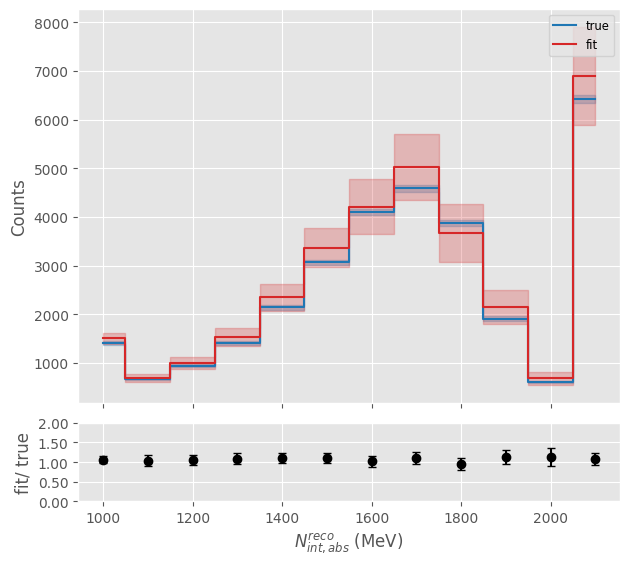

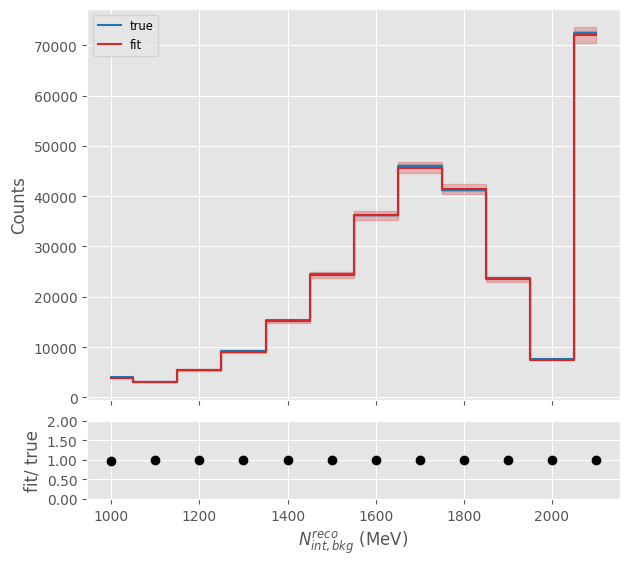

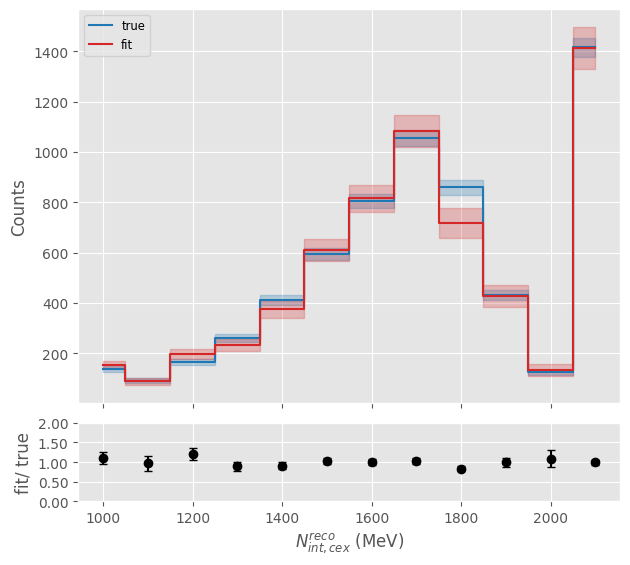

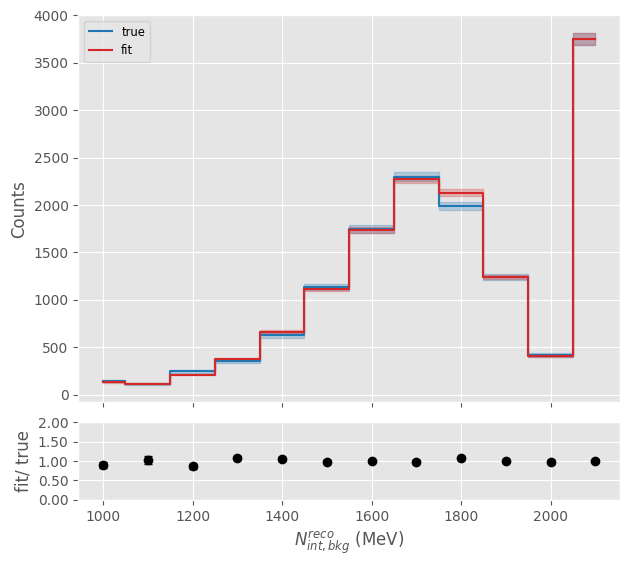

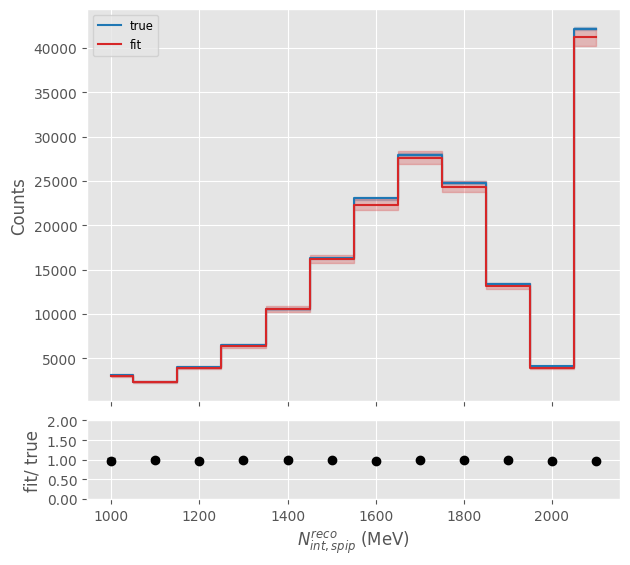

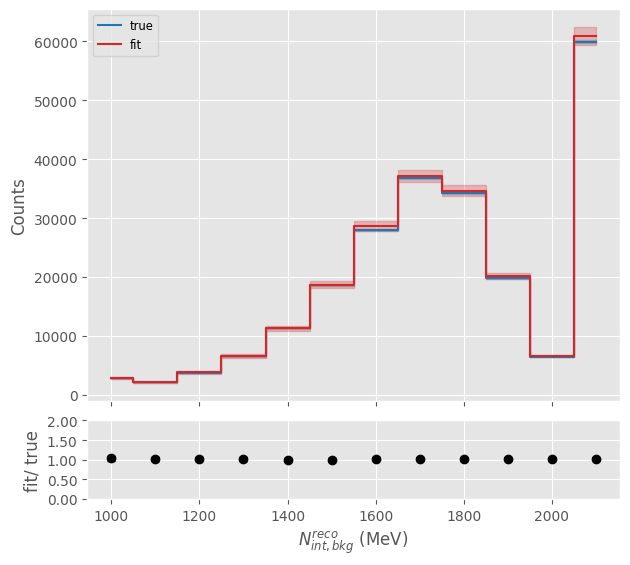

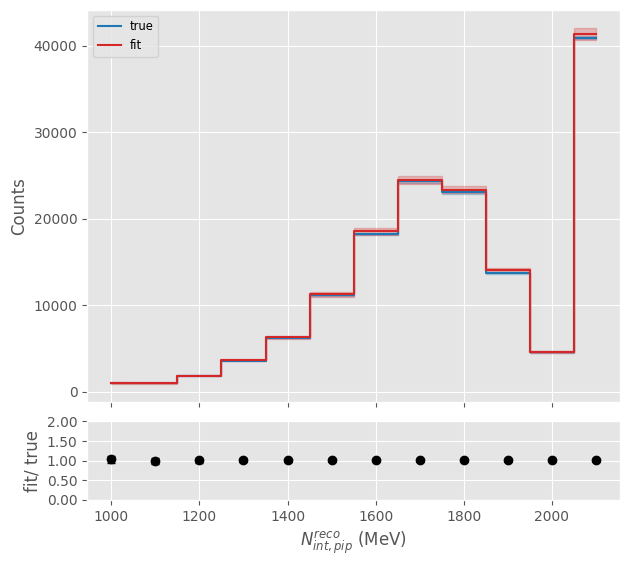

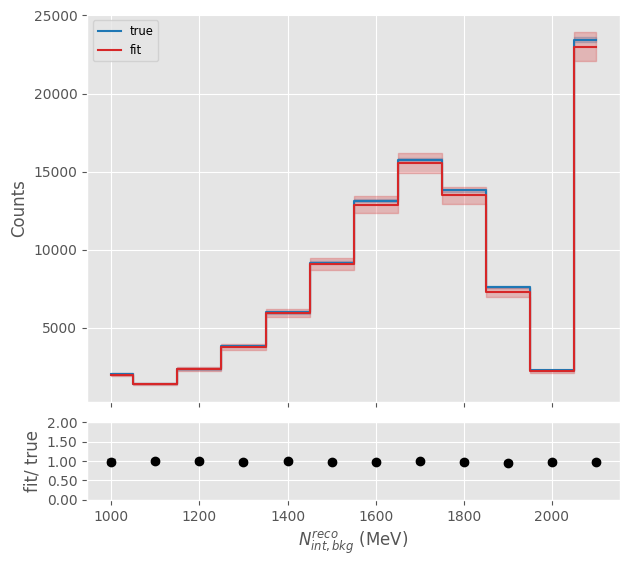

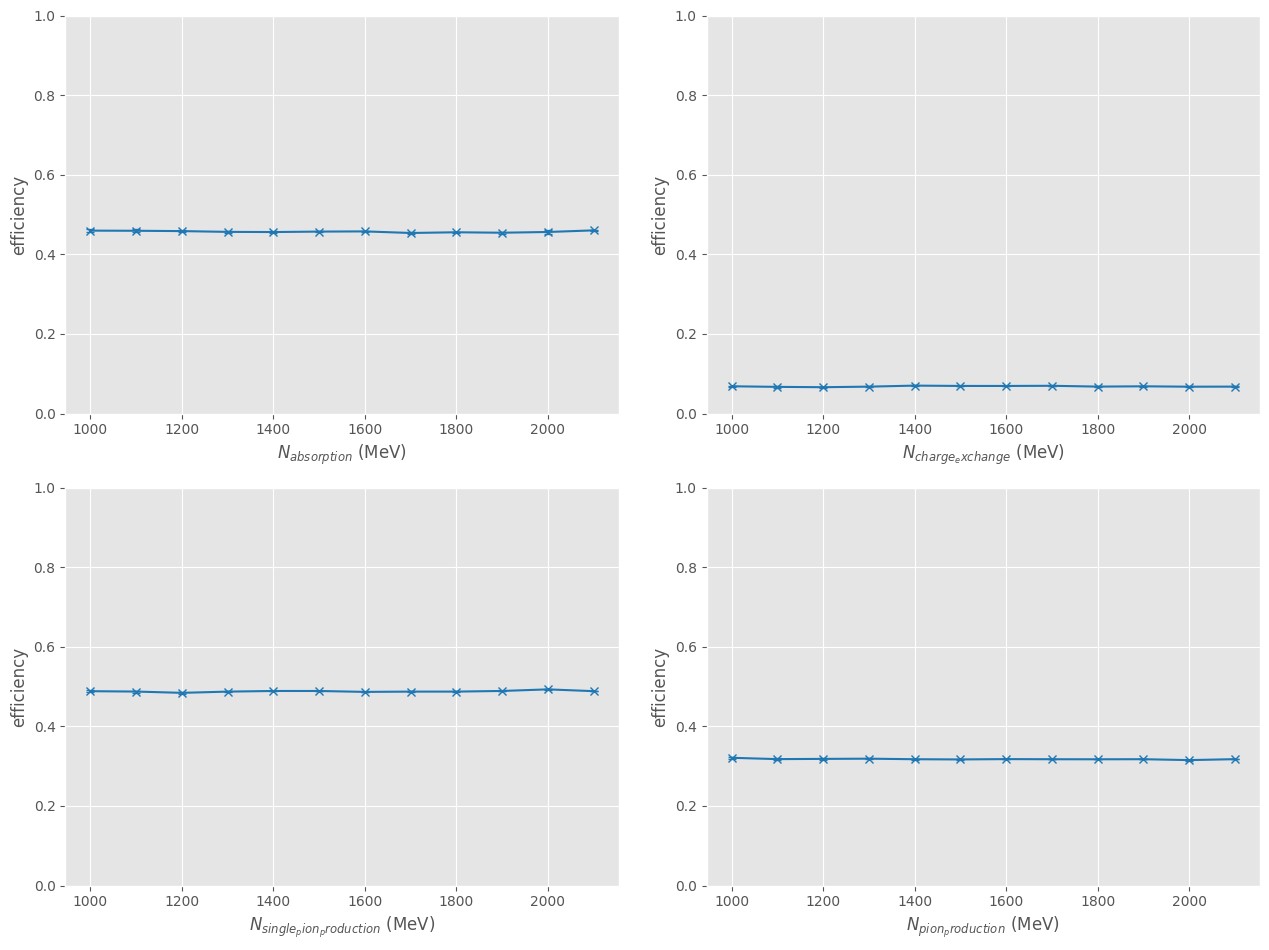

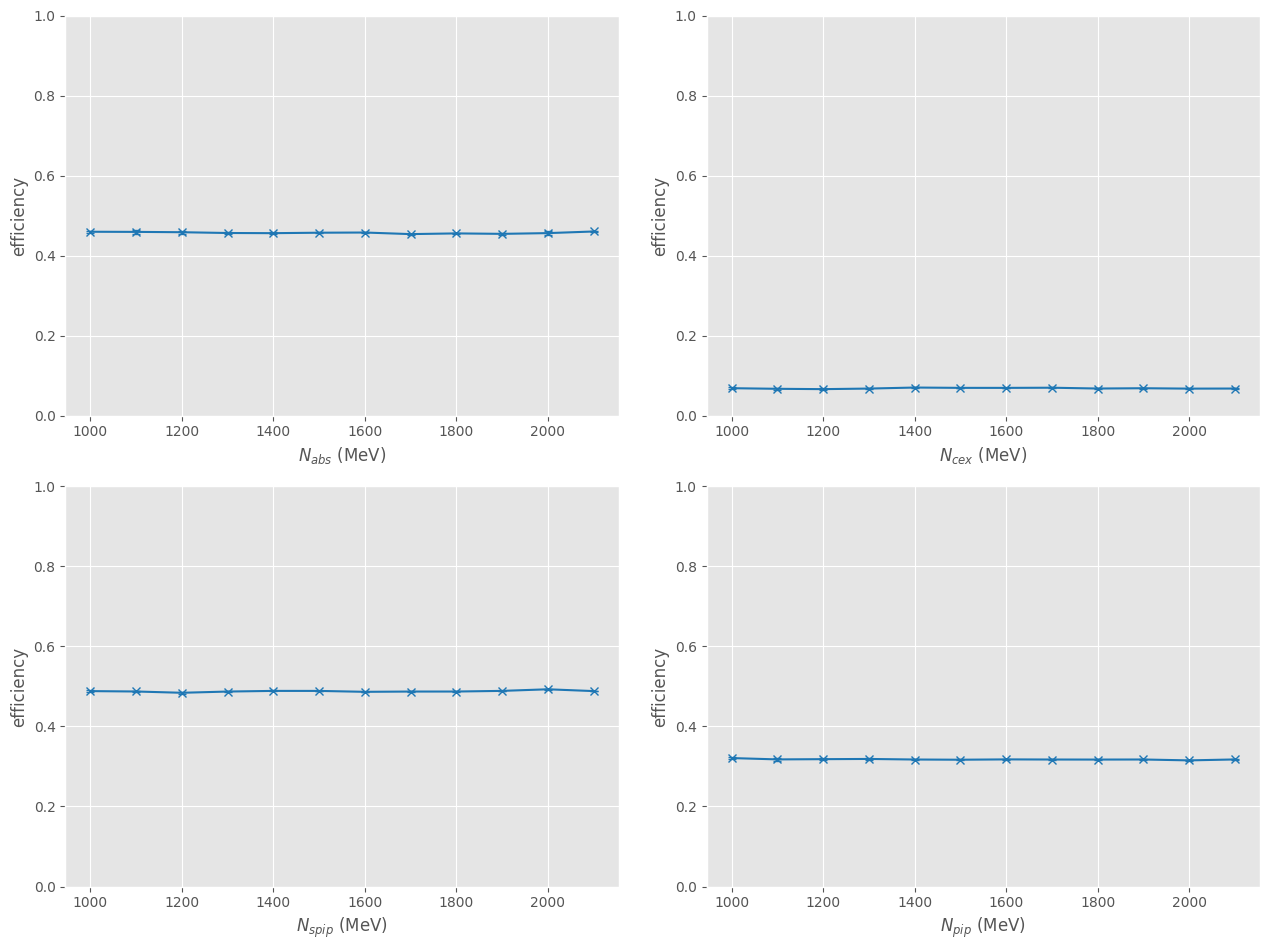

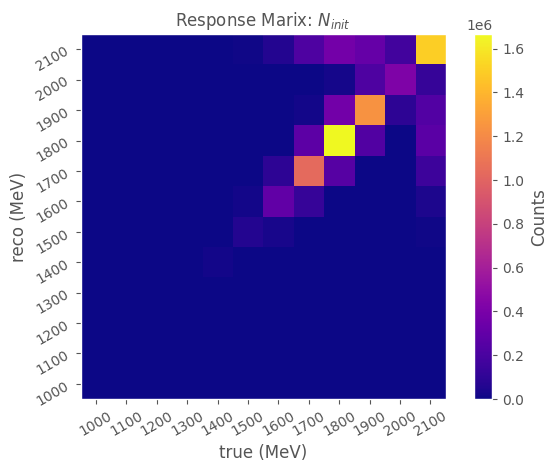

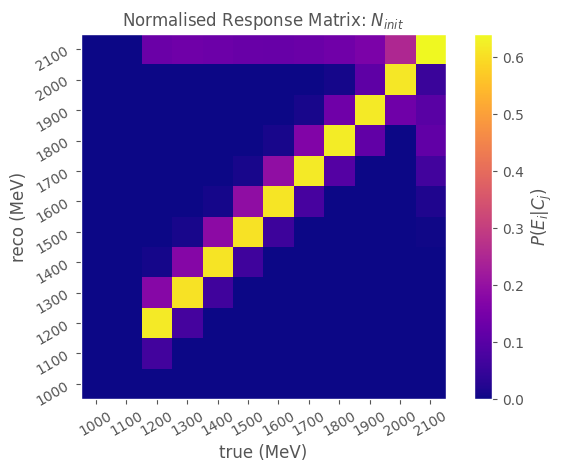

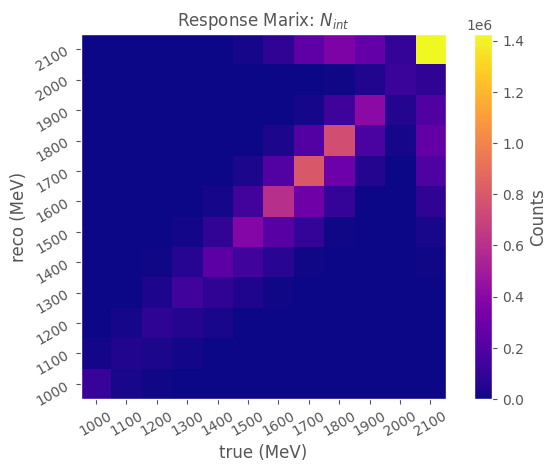

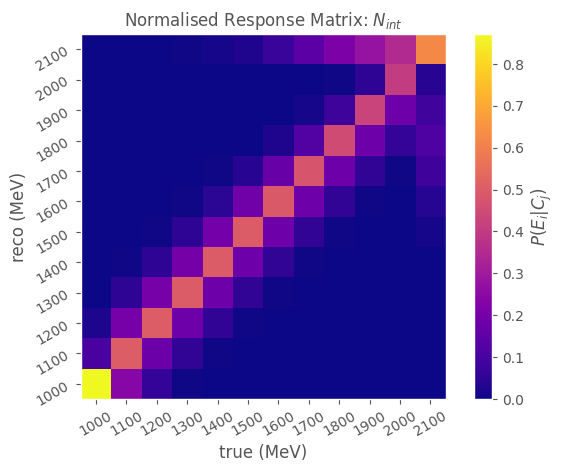

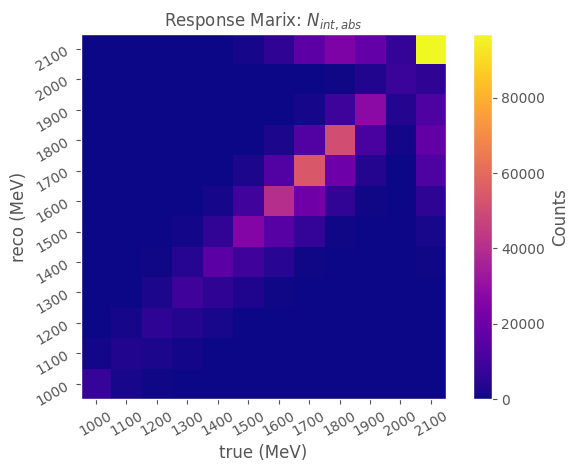

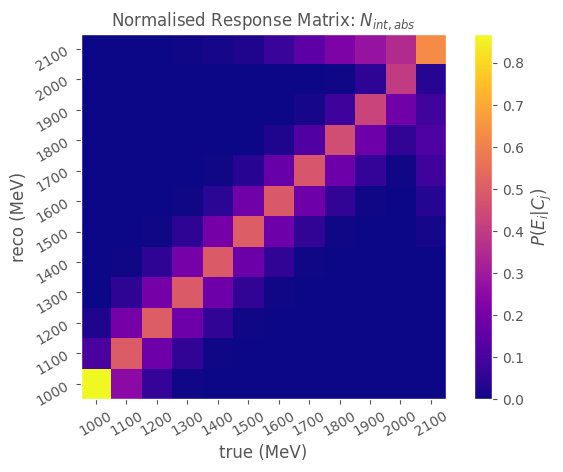

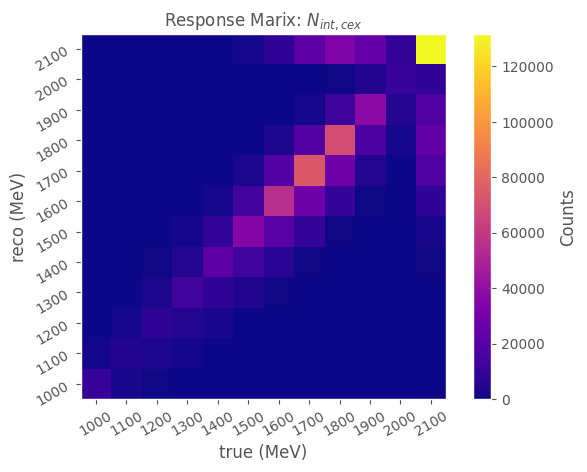

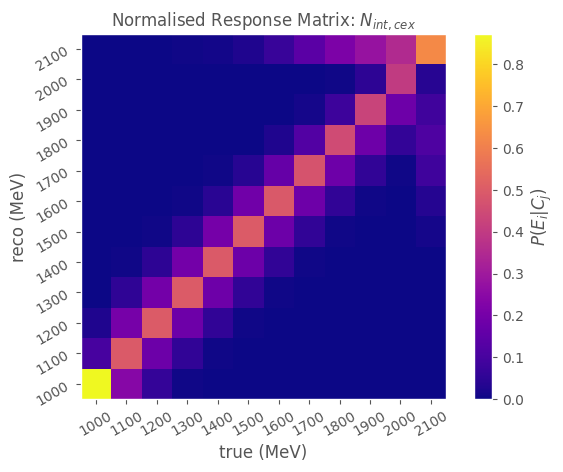

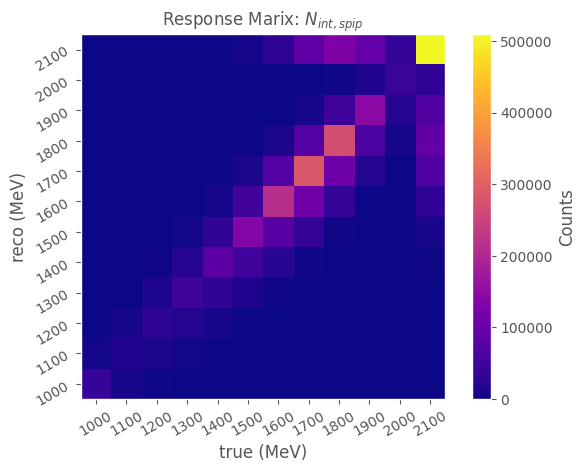

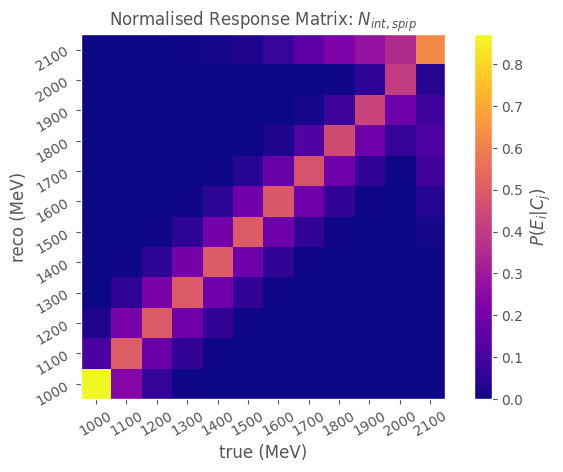

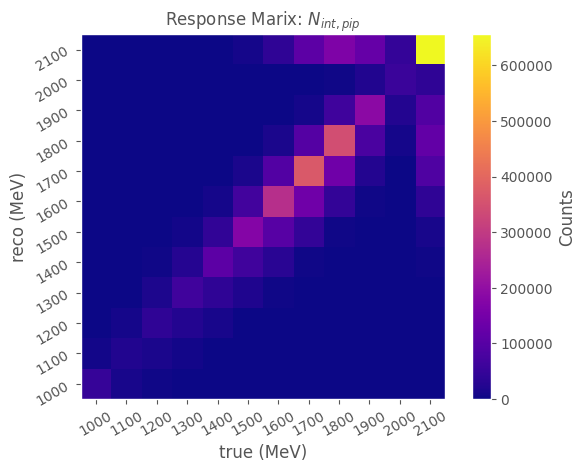

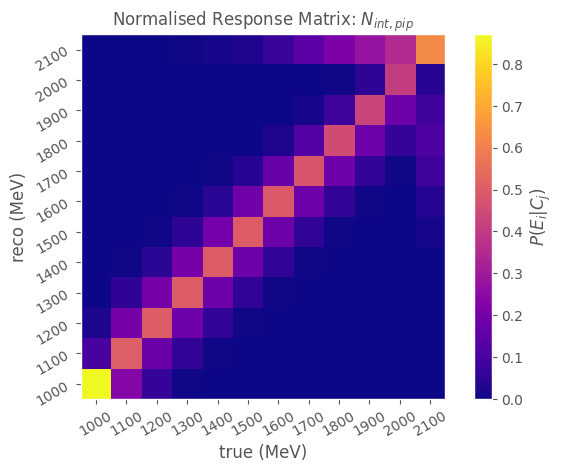

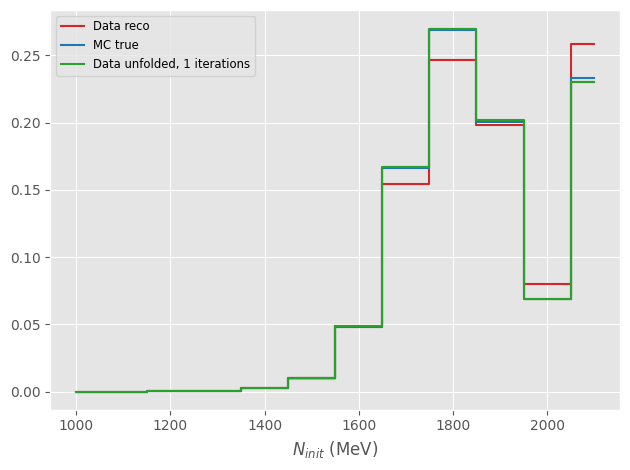

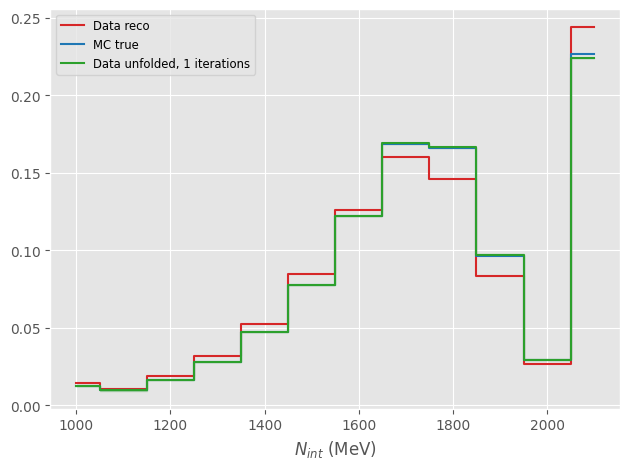

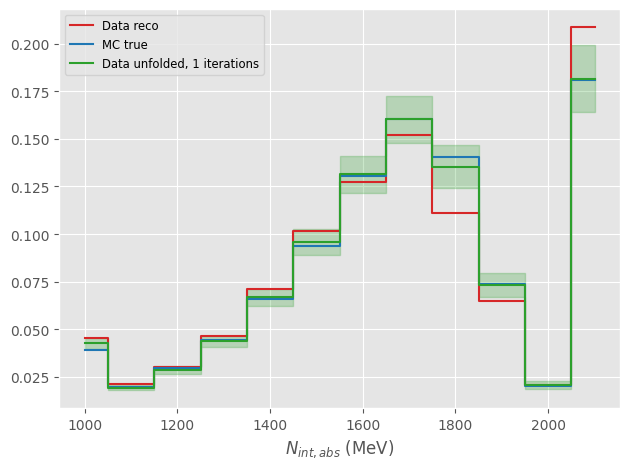

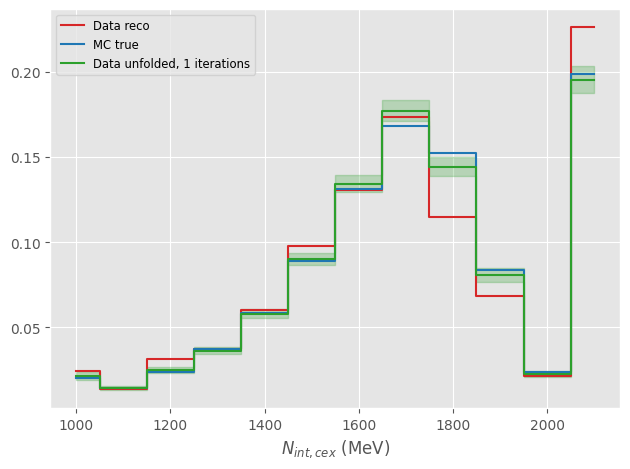

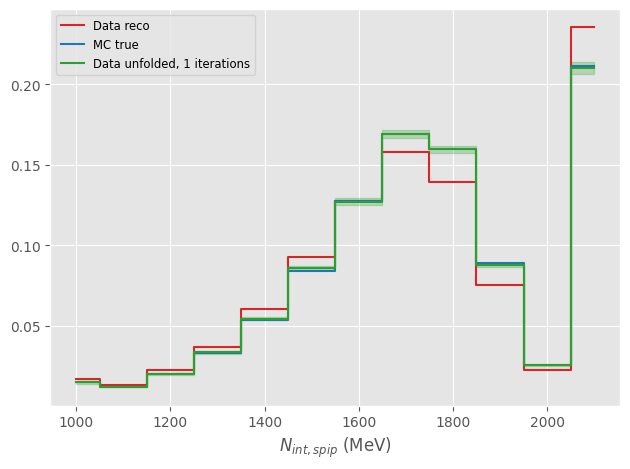

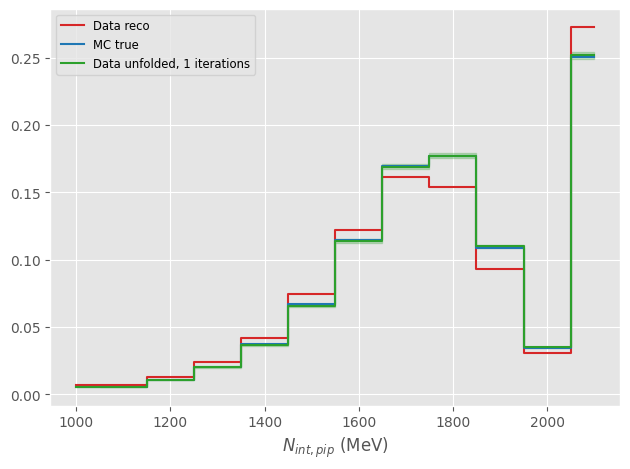

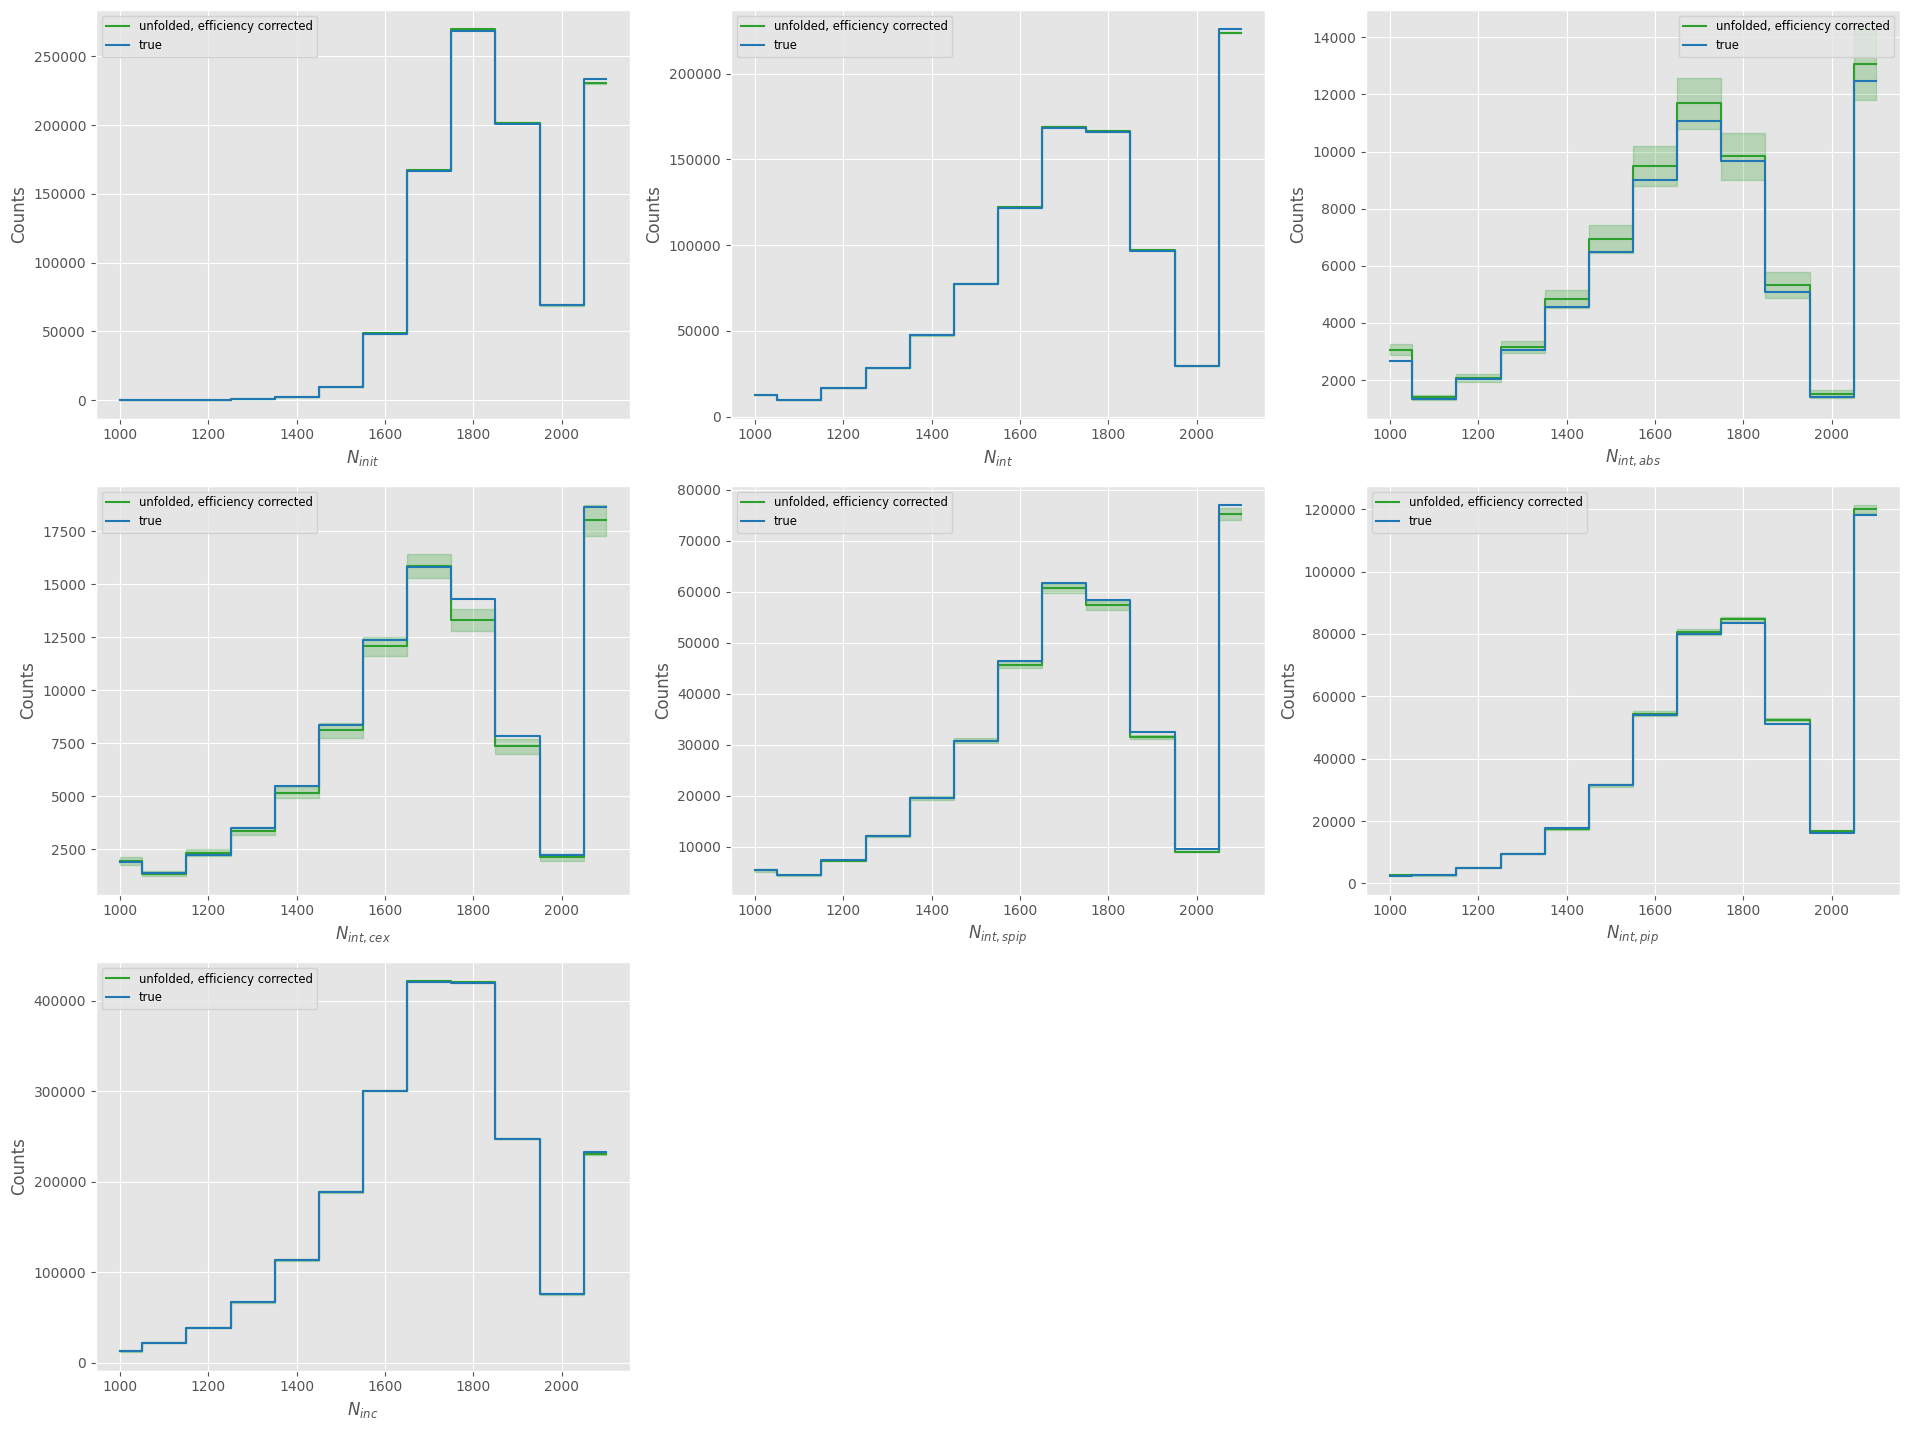

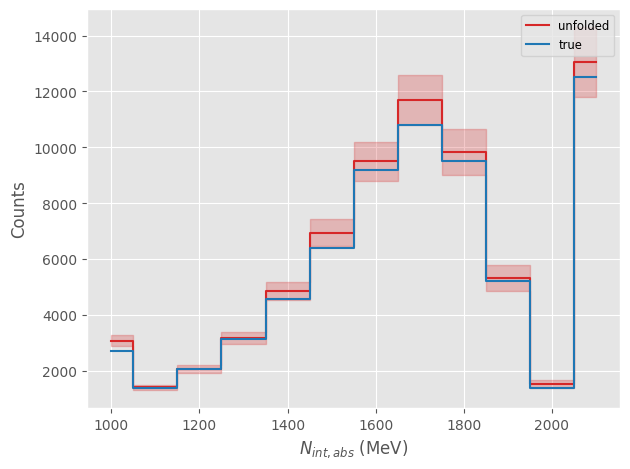

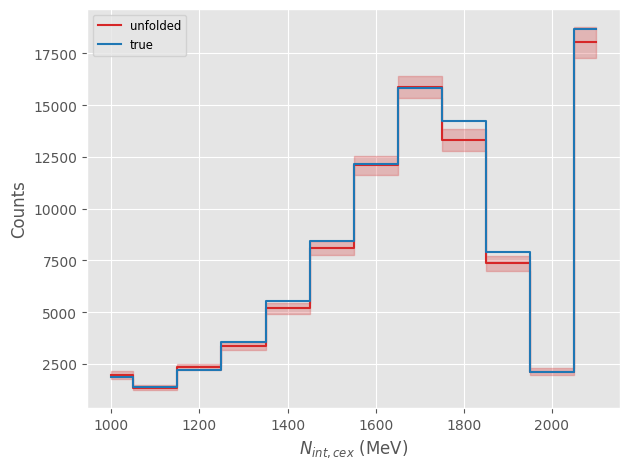

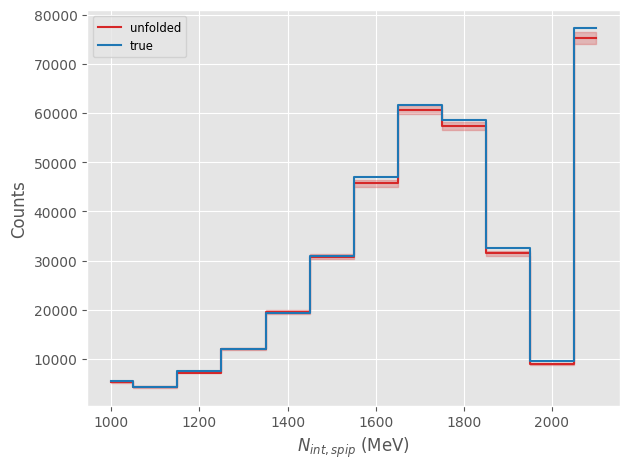

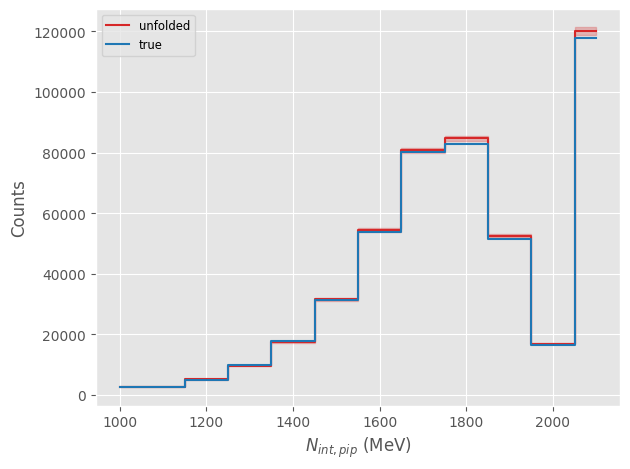

In [133]:
analysis_input_nominal = cross_section.AnalysisInput.CreateAnalysisInputToy(toy_nominal)
with Plots.PlotBook("xs_nominal", True) as book:
    xs_nominal = Analyse(analysis_input_nominal, model, args, args.energy_slices, None, book)

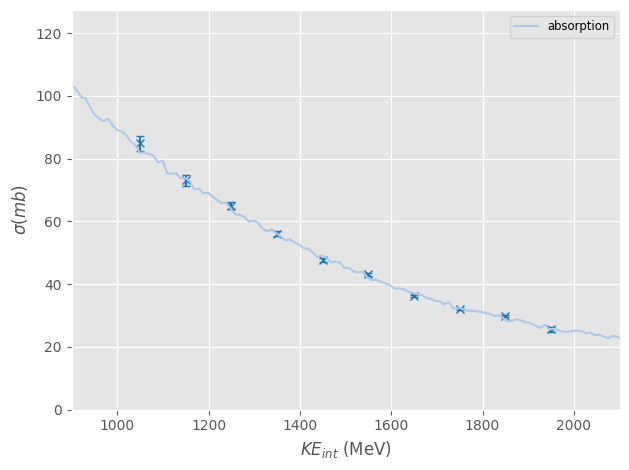

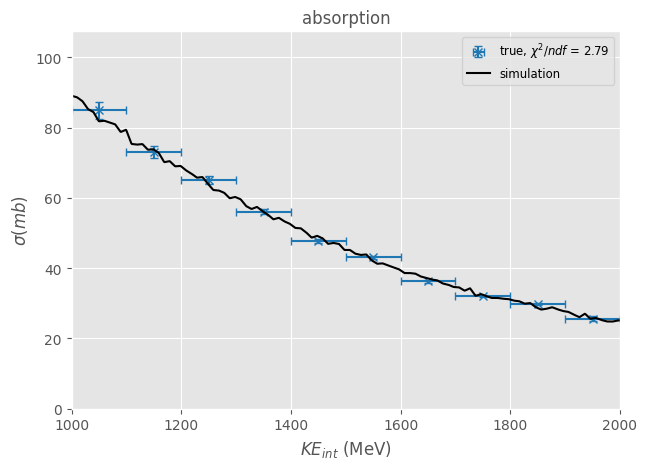

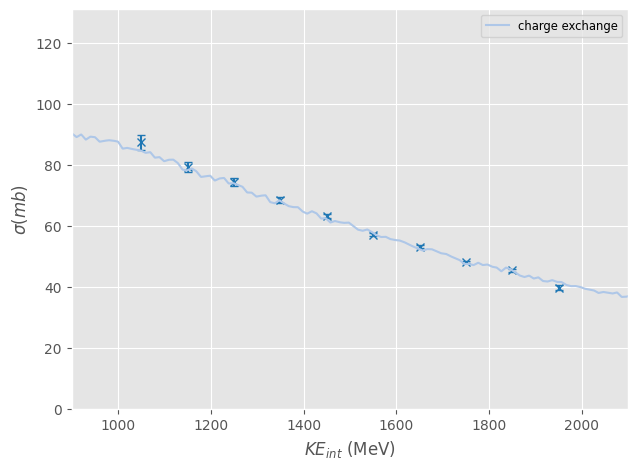

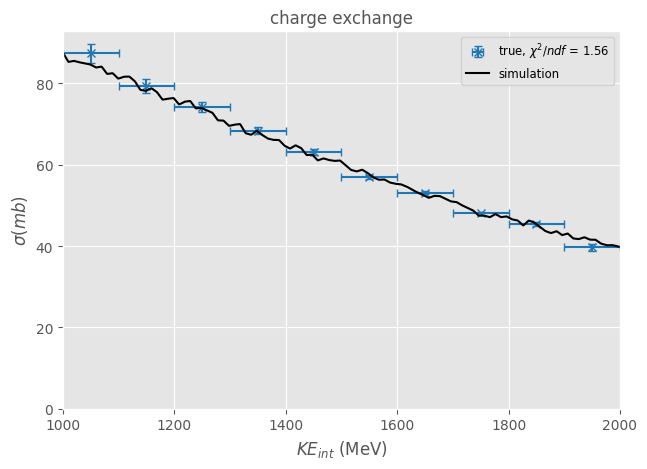

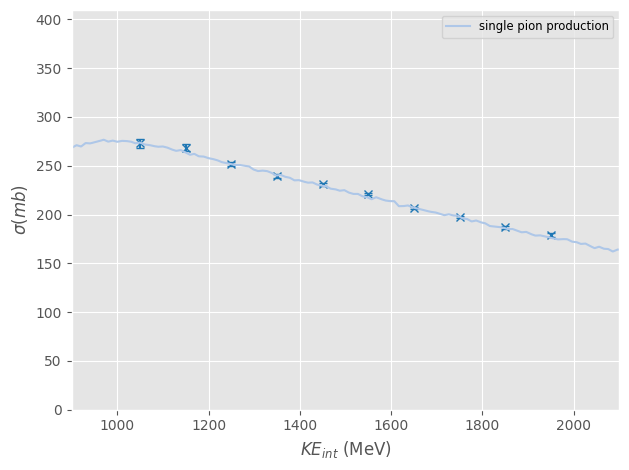

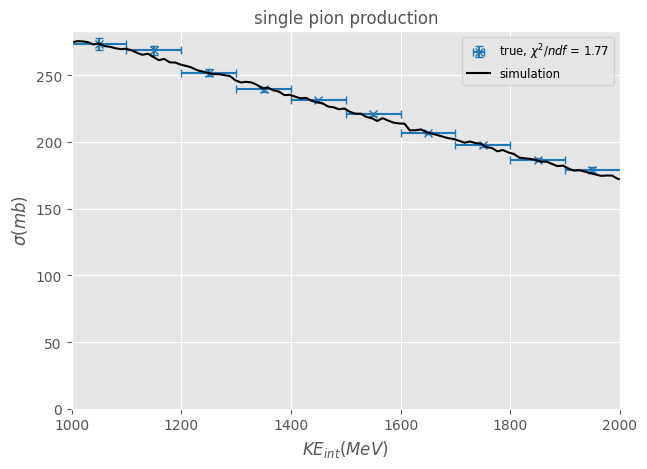

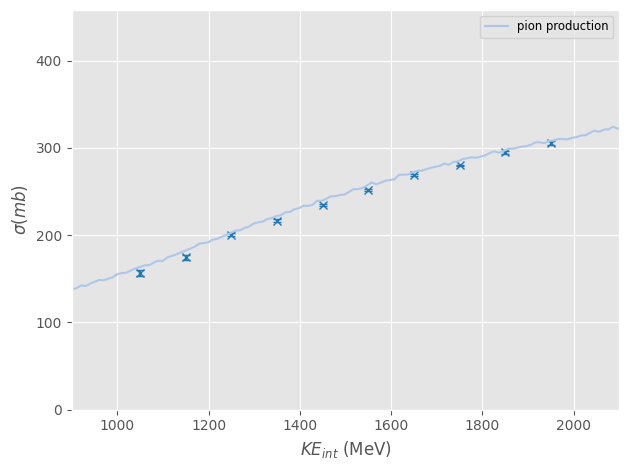

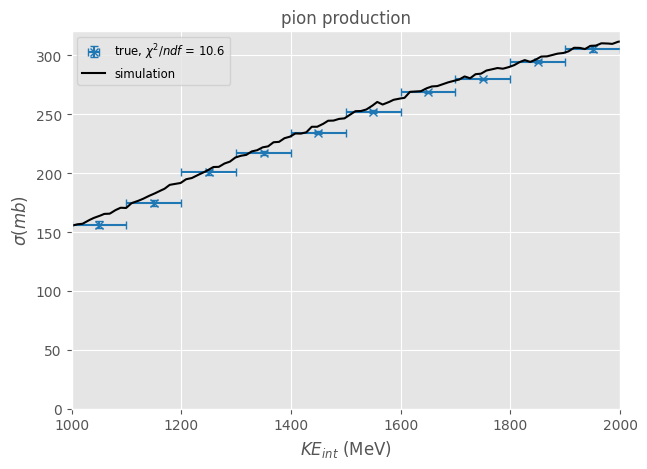

In [103]:
for p in analysis_input_nominal.exclusive_process:
    hists = analysis_input_nominal.CreateHistograms(args.energy_slices, p, False)
    xs = cross_section.EnergySlice.CrossSection(hists["int_ex"][1:-1], hists["int"][1:-1], hists["inc"][1:-1], cross_section.EnergySlice.Slice_dEdX(args.energy_slices, cross_section.Particle.from_pdgid(211))[1:], args.energy_slices.width)
    Plots.Plot(args.energy_slices.pos[:-1]- args.energy_slices.width/2, xs[0], yerr = xs[1], marker = "x", linestyle = "")
    xs_sim.Plot(p)
    Plots.plt.xlim(args.energy_slices.min_pos - args.energy_slices.width, args.energy_slices.max_pos + args.energy_slices.width)
    Plots.plt.ylim(0, 1.5 * np.nanmax(xs[0]))
    cross_section.PlotXSComparison({"true" : xs}, args.energy_slices, p)

# MC Stat uncertainty

In [16]:
def PseudoExperiment(n_experiments, n_data, n_template):
    data_config = {k : v for k, v in toy_config_nominal.items()}
    data_config["seed"] = None
    data_config["events"] = n_data

    template_config = {k : v for k, v in toy_config_nominal.items()}
    template_config["seed"] = None
    template_config["events"] = n_template

    xs = []
    for i in range(n_experiments):
        print(f"{i=}")
        ai_template = cross_section.AnalysisInput.CreateAnalysisInputToy(cross_section.Toy(df = cex_toy_generator.run(template_config)))
        ai_data = cross_section.AnalysisInput.CreateAnalysisInputToy(cross_section.Toy(df = cex_toy_generator.run(data_config)))
        xs.append(Analyse(ai_data, ai_template, args, args.energy_slices, None, None))
        clear_output()        

    return np.array(xs)

n_experiments = 101
n_data = 72780
n_template = 29452

xs = PseudoExperiment(n_experiments, n_data, n_template)

In [33]:
cross_section.SaveObject("test/mc_stat_results.dill", xs)

[ 197.55162786   44.48241306   23.86933826   13.75573954   11.01124382
   11.0247282    11.37993186   15.63823666   18.54181752   23.8417464
   31.20114062   41.7196889    44.78570444 2252.82976052]

[ 165.31481988   49.5700049    41.69310365   45.94448584   50.52706997
   54.3725391    59.37011065   63.19353946   70.26495323   74.90966112
   86.46898951   90.01963669   87.43404877 4735.94521514]

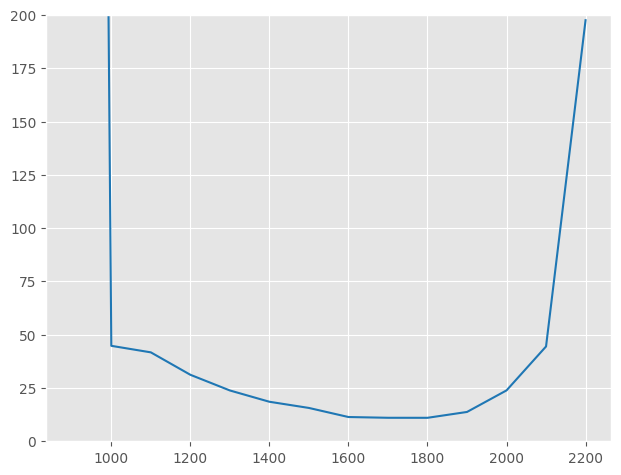

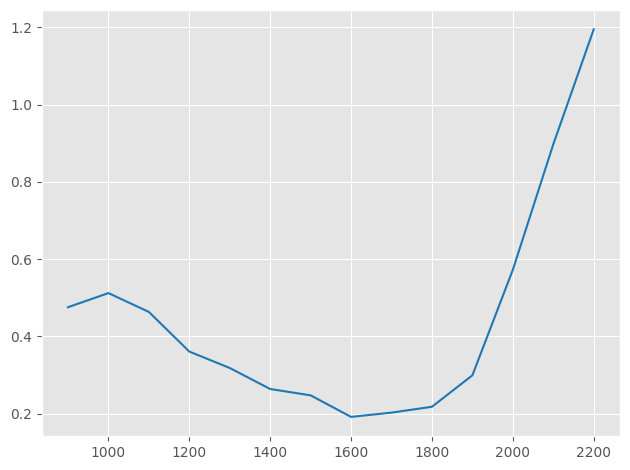

In [27]:
# cv = xs[0][0]
cv = np.nanmean(xs[:, 0], 0)
res = xs[:, 0] - cv

mean = np.nanmean(abs(res), 0)
print(mean)
print(cv)
Plots.Plot(args.energy_slices.pos, mean)
Plots.plt.ylim(0, 200)

Plots.Plot(args.energy_slices.pos, mean/cv)

# Region fit normalisation systematic

## with unfolding

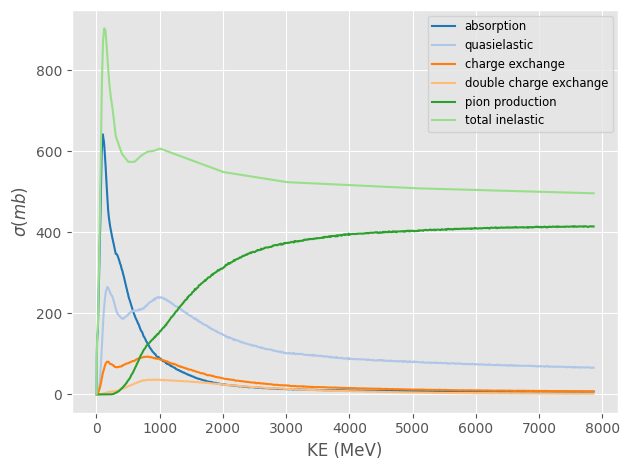

In [15]:
xs = cex_toy_generator.ModifyGeantXS(scale_factors = {"absorption" : 1, "charge_exchange" : 1, "pion_production" : 1, "double_charge_exchange" : 1, "quasielastic" : 1}, modified_PDFs = None)
xs.Plot("all")

In [134]:
def NormalisationSystematic(data_config : dict, norms = [0.8, 1.2], plot : bool = False):
    x = args.energy_slices.pos[:-1]

    exclusive_proc = ["absorption", "charge_exchange", "single_pion_production", "pion_production"]
    cvs = {}
    true_cvs = {}
    for target in exclusive_proc:
        print(f"{target=}")
        scales = {k : 1 for k in ['absorption', 'quasielastic', 'charge_exchange', 'double_charge_exchange', 'pion_production']}
        xs = {}
        xs_true = {}
        for i in norms:
            if i == 1:
                config = {k : v for k,v in data_config.items()}
            else:
                if target == "single_pion_production":
                    scales["quasielastic"] = i
                    scales["double_charge_exchange"] = i
                else:
                    scales[target] = i
                config = cex_fit_studies.CreateConfigNormalisation(scales, data_config)
            ai = cross_section.AnalysisInput.CreateAnalysisInputToy(cross_section.Toy(df = cex_toy_generator.run(config)))
            
            if plot is True:
                out = f"test/normalisation_systematic/{target}/"
                cross_section.os.makedirs(out, exist_ok = True)
                book = Plots.PlotBook(f"{out}plots_{i}")
            else:
                book = None

            xs[i] = Analyse(ai, model, args, args.energy_slices, None, book)
            if plot is True:
                book.close()
                Plots.plt.close("all")
            xs_sim_mod = cex_toy_generator.ModifyGeantXS(scale_factors = config["pdf_scale_factors"])

            if args.fit["regions"]:
                xs_true[i] = {k : xs_sim_mod.GetInterpolatedCurve(k)(x) for k in exclusive_proc}
            else:
                xs_true[i] = xs_sim_mod.GetInterpolatedCurve(args.signal_process)(x)
        cvs[target] = xs
        true_cvs[target] = xs_true
    return cvs, true_cvs
results = NormalisationSystematic(toy_config_nominal, [0.8, 1.2], True)


target='absorption'

starting batch : 0, cpus : 6

starting batch : 1, cpus : 6

starting batch : 2, cpus : 6

starting batch : 3, cpus : 6

starting batch : 4, cpus : 6

starting batch : 5, cpus : 6

starting batch : 6, cpus : 6

starting batch : 7, cpus : 6

starting batch : 8, cpus : 6

starting batch : 9, cpus : 6

starting batch : 10, cpus : 6

starting batch : 11, cpus : 6

starting batch : 12, cpus : 6

starting batch : 13, cpus : 6

starting batch : 14, cpus : 6

starting batch : 15, cpus : 6

starting batch : 16, cpus : 4

Simulating |████████████████████████████████████████| 17/17 [100%] in 54.7s (0.31/s) 


Done! Creating dataframe...

total_inelastic 999962

decay 38

pion_production 477244

quasielastic 317832

charge_exchange 95811

double_charge_exchange 52940

absorption 56135

38

'BeamSelectionEfficiency' executed in 0.0567s

'GenerateRecoRegions' executed in 1.8641s

'MeanTrackScore' executed in 3.8724s

'main' executed in 64.2766s

pdf test/normalisation_systematic/absorption/plots_0.8.pdf has been opened
model.config.suggested_init()=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
model.logpdf(pars=model.config.suggested_init(), data=observations)=array([-6697162.35238434])
W MnPosDef Matrix forced pos-def by adding to diagonal 0.029854


/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/cross_section.py:1771: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  Plots.plt.figure()


init
Iteration 1: ts = 0.0028, ts_stopping = 0.01
int
Iteration 1: ts = 0.0024, ts_stopping = 0.01
absorption
Iteration 1: ts = 0.0175, ts_stopping = 0.01
Iteration 2: ts = 0.0052, ts_stopping = 0.01
charge_exchange
Iteration 1: ts = 0.0195, ts_stopping = 0.01
Iteration 2: ts = 0.0062, ts_stopping = 0.01
single_pion_production
Iteration 1: ts = 0.0048, ts_stopping = 0.01
pion_production
Iteration 1: ts = 0.0018, ts_stopping = 0.01
pdf test/normalisation_systematic/absorption/plots_0.8.pdf has been closed


starting batch : 0, cpus : 6

starting batch : 1, cpus : 6

starting batch : 2, cpus : 6

starting batch : 3, cpus : 6

starting batch : 4, cpus : 6

starting batch : 5, cpus : 6

starting batch : 6, cpus : 6

starting batch : 7, cpus : 6

starting batch : 8, cpus : 6

starting batch : 9, cpus : 6

starting batch : 10, cpus : 6

starting batch : 11, cpus : 6

starting batch : 12, cpus : 6

starting batch : 13, cpus : 6

starting batch : 14, cpus : 6

starting batch : 15, cpus : 6

starting batch : 16, cpus : 4

Simulating |████████████████████████████████████████| 17/17 [100%] in 57.8s (0.29/s) 


Done! Creating dataframe...

total_inelastic 999962

decay 38

pion_production 464769

quasielastic 309095

charge_exchange 93432

double_charge_exchange 51225

absorption 81441

38

'BeamSelectionEfficiency' executed in 0.0500s

'GenerateRecoRegions' executed in 1.5851s

'MeanTrackScore' executed in 3.6144s

'main' executed in 66.6517s

pdf test/normalisation_systematic/absorption/plots_1.2.pdf has been opened
model.config.suggested_init()=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
model.logpdf(pars=model.config.suggested_init(), data=observations)=array([-6697162.91779748])


/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/cross_section.py:1771: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  Plots.plt.figure()


init
Iteration 1: ts = 0.0028, ts_stopping = 0.01
int
Iteration 1: ts = 0.0024, ts_stopping = 0.01
absorption
Iteration 1: ts = 0.0132, ts_stopping = 0.01
Iteration 2: ts = 0.0027, ts_stopping = 0.01
charge_exchange
Iteration 1: ts = 0.0112, ts_stopping = 0.01
Iteration 2: ts = 0.0033, ts_stopping = 0.01
single_pion_production
Iteration 1: ts = 0.0024, ts_stopping = 0.01
pion_production
Iteration 1: ts = 0.0057, ts_stopping = 0.01
pdf test/normalisation_systematic/absorption/plots_1.2.pdf has been closed


target='charge_exchange'

starting batch : 0, cpus : 6

starting batch : 1, cpus : 6

starting batch : 2, cpus : 6

starting batch : 3, cpus : 6

starting batch : 4, cpus : 6

starting batch : 5, cpus : 6

starting batch : 6, cpus : 6

starting batch : 7, cpus : 6

starting batch : 8, cpus : 6

starting batch : 9, cpus : 6

starting batch : 10, cpus : 6

starting batch : 11, cpus : 6

starting batch : 12, cpus : 6

starting batch : 13, cpus : 6

starting batch : 14, cpus : 6

starting batch : 15, cpus : 6

starting batch : 16, cpus : 4

Simulating |████████████████████████████████████████| 17/17 [100%] in 1:08.4 (0.25/s) 


Done! Creating dataframe...

total_inelastic 999962

decay 38

pion_production 479825

quasielastic 319207

charge_exchange 77159

double_charge_exchange 53306

absorption 70465

38

'BeamSelectionEfficiency' executed in 0.0458s

'GenerateRecoRegions' executed in 1.4805s

'MeanTrackScore' executed in 3.3009s

'main' executed in 76.8003s

pdf test/normalisation_systematic/charge_exchange/plots_0.8.pdf has been opened
model.config.suggested_init()=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
model.logpdf(pars=model.config.suggested_init(), data=observations)=array([-6697269.98353497])


/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/cross_section.py:1771: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  Plots.plt.figure()


init
Iteration 1: ts = 0.0028, ts_stopping = 0.01
int
Iteration 1: ts = 0.0024, ts_stopping = 0.01
absorption
Iteration 1: ts = 0.0133, ts_stopping = 0.01
Iteration 2: ts = 0.0044, ts_stopping = 0.01
charge_exchange
Iteration 1: ts = 0.0216, ts_stopping = 0.01
Iteration 2: ts = 0.0070, ts_stopping = 0.01
single_pion_production
Iteration 1: ts = 0.0043, ts_stopping = 0.01
pion_production
Iteration 1: ts = 0.0020, ts_stopping = 0.01
pdf test/normalisation_systematic/charge_exchange/plots_0.8.pdf has been closed


starting batch : 0, cpus : 6

starting batch : 1, cpus : 6

starting batch : 2, cpus : 6

starting batch : 3, cpus : 6

starting batch : 4, cpus : 6

starting batch : 5, cpus : 6

starting batch : 6, cpus : 6

starting batch : 7, cpus : 6

starting batch : 8, cpus : 6

starting batch : 9, cpus : 6

starting batch : 10, cpus : 6

starting batch : 11, cpus : 6

starting batch : 12, cpus : 6

starting batch : 13, cpus : 6

starting batch : 14, cpus : 6

starting batch : 15, cpus : 6

starting batch : 16, cpus : 4

Simulating |████████████████████████████████████████| 17/17 [100%] in 1:07.1 (0.25/s) 


Done! Creating dataframe...

total_inelastic 999962

decay 38

pion_production 462377

quasielastic 307502

charge_exchange 111386

double_charge_exchange 50879

absorption 67818

38

'BeamSelectionEfficiency' executed in 0.0558s

'GenerateRecoRegions' executed in 1.8381s

'MeanTrackScore' executed in 3.8582s

'main' executed in 76.7728s

pdf test/normalisation_systematic/charge_exchange/plots_1.2.pdf has been opened
model.config.suggested_init()=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
model.logpdf(pars=model.config.suggested_init(), data=observations)=array([-6697249.47362763])


/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/cross_section.py:1771: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  Plots.plt.figure()


init
Iteration 1: ts = 0.0028, ts_stopping = 0.01
int
Iteration 1: ts = 0.0024, ts_stopping = 0.01
absorption
Iteration 1: ts = 0.0136, ts_stopping = 0.01
Iteration 2: ts = 0.0028, ts_stopping = 0.01
charge_exchange
Iteration 1: ts = 0.0119, ts_stopping = 0.01
Iteration 2: ts = 0.0036, ts_stopping = 0.01
single_pion_production
Iteration 1: ts = 0.0016, ts_stopping = 0.01
pion_production
Iteration 1: ts = 0.0047, ts_stopping = 0.01
pdf test/normalisation_systematic/charge_exchange/plots_1.2.pdf has been closed


target='single_pion_production'

starting batch : 0, cpus : 6

starting batch : 1, cpus : 6

starting batch : 2, cpus : 6

starting batch : 3, cpus : 6

starting batch : 4, cpus : 6

starting batch : 5, cpus : 6

starting batch : 6, cpus : 6

starting batch : 7, cpus : 6

starting batch : 8, cpus : 6

starting batch : 9, cpus : 6

starting batch : 10, cpus : 6

starting batch : 11, cpus : 6

starting batch : 12, cpus : 6

starting batch : 13, cpus : 6

starting batch : 14, cpus : 6

starting batch : 15, cpus : 6

starting batch : 16, cpus : 4

Simulating |████████████████████████████████████████| 17/17 [100%] in 1:06.4 (0.26/s) 


Done! Creating dataframe...

total_inelastic 999962

decay 38

pion_production 507711

quasielastic 270564

charge_exchange 101723

double_charge_exchange 45404

absorption 74560

38

'BeamSelectionEfficiency' executed in 0.0562s

'GenerateRecoRegions' executed in 1.8395s

'MeanTrackScore' executed in 4.0506s

'main' executed in 76.4376s

pdf test/normalisation_systematic/single_pion_production/plots_0.8.pdf has been opened
model.config.suggested_init()=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
model.logpdf(pars=model.config.suggested_init(), data=observations)=array([-6697257.69838468])
W MnPosDef Matrix forced pos-def by adding to diagonal 0.00510639


/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/cross_section.py:1771: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  Plots.plt.figure()


init
Iteration 1: ts = 0.0028, ts_stopping = 0.01
int
Iteration 1: ts = 0.0024, ts_stopping = 0.01
absorption
Iteration 1: ts = 0.0233, ts_stopping = 0.01
Iteration 2: ts = 0.0062, ts_stopping = 0.01
charge_exchange
Iteration 1: ts = 0.0109, ts_stopping = 0.01
Iteration 2: ts = 0.0038, ts_stopping = 0.01
single_pion_production
Iteration 1: ts = 0.0083, ts_stopping = 0.01
pion_production
Iteration 1: ts = 0.0021, ts_stopping = 0.01
pdf test/normalisation_systematic/single_pion_production/plots_0.8.pdf has been closed


starting batch : 0, cpus : 6

starting batch : 1, cpus : 6

starting batch : 2, cpus : 6

starting batch : 3, cpus : 6

starting batch : 4, cpus : 6

starting batch : 5, cpus : 6

starting batch : 6, cpus : 6

starting batch : 7, cpus : 6

starting batch : 8, cpus : 6

starting batch : 9, cpus : 6

starting batch : 10, cpus : 6

starting batch : 11, cpus : 6

starting batch : 12, cpus : 6

starting batch : 13, cpus : 6

starting batch : 14, cpus : 6

starting batch : 15, cpus : 6

starting batch : 16, cpus : 4

Simulating |████████████████████████████████████████| 17/17 [100%] in 1:08.1 (0.25/s) 


Done! Creating dataframe...

total_inelastic 999962

decay 38

pion_production 439001

quasielastic 350137

charge_exchange 88466

double_charge_exchange 57991

absorption 64367

38

'BeamSelectionEfficiency' executed in 0.0562s

'GenerateRecoRegions' executed in 1.8980s

'MeanTrackScore' executed in 3.9571s

'main' executed in 77.9333s

pdf test/normalisation_systematic/single_pion_production/plots_1.2.pdf has been opened
model.config.suggested_init()=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
model.logpdf(pars=model.config.suggested_init(), data=observations)=array([-6697215.58814563])


/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/cross_section.py:1771: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  Plots.plt.figure()


init
Iteration 1: ts = 0.0028, ts_stopping = 0.01
int
Iteration 1: ts = 0.0024, ts_stopping = 0.01
absorption
Iteration 1: ts = 0.0150, ts_stopping = 0.01
Iteration 2: ts = 0.0035, ts_stopping = 0.01
charge_exchange
Iteration 1: ts = 0.0128, ts_stopping = 0.01
Iteration 2: ts = 0.0025, ts_stopping = 0.01
single_pion_production
Iteration 1: ts = 0.0033, ts_stopping = 0.01
pion_production
Iteration 1: ts = 0.0067, ts_stopping = 0.01
pdf test/normalisation_systematic/single_pion_production/plots_1.2.pdf has been closed


target='pion_production'

starting batch : 0, cpus : 6

starting batch : 1, cpus : 6

starting batch : 2, cpus : 6

starting batch : 3, cpus : 6

starting batch : 4, cpus : 6

starting batch : 5, cpus : 6

starting batch : 6, cpus : 6

starting batch : 7, cpus : 6

starting batch : 8, cpus : 6

starting batch : 9, cpus : 6

starting batch : 10, cpus : 6

starting batch : 11, cpus : 6

starting batch : 12, cpus : 6

starting batch : 13, cpus : 6

starting batch : 14, cpus : 6

starting batch : 15, cpus : 6

starting batch : 16, cpus : 4

Simulating |████████████████████████████████████████| 17/17 [100%] in 1:05.2 (0.26/s) 


Done! Creating dataframe...

total_inelastic 999962

decay 38

pion_production 416259

quasielastic 345899

charge_exchange 104405

double_charge_exchange 57541

absorption 75858

38

'BeamSelectionEfficiency' executed in 0.0568s

'GenerateRecoRegions' executed in 1.8435s

'MeanTrackScore' executed in 3.8538s

'main' executed in 74.9006s

pdf test/normalisation_systematic/pion_production/plots_0.8.pdf has been opened
model.config.suggested_init()=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
model.logpdf(pars=model.config.suggested_init(), data=observations)=array([-6697278.58053021])
W MnPosDef Matrix forced pos-def by adding to diagonal 0.018459


/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/cross_section.py:1771: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  Plots.plt.figure()


init
Iteration 1: ts = 0.0028, ts_stopping = 0.01
int
Iteration 1: ts = 0.0024, ts_stopping = 0.01
absorption
Iteration 1: ts = 0.0329, ts_stopping = 0.01
Iteration 2: ts = 0.0073, ts_stopping = 0.01
charge_exchange
Iteration 1: ts = 0.0045, ts_stopping = 0.01
single_pion_production
Iteration 1: ts = 0.0091, ts_stopping = 0.01
pion_production
Iteration 1: ts = 0.0115, ts_stopping = 0.01
Iteration 2: ts = 0.0029, ts_stopping = 0.01
pdf test/normalisation_systematic/pion_production/plots_0.8.pdf has been closed


starting batch : 0, cpus : 6

starting batch : 1, cpus : 6

starting batch : 2, cpus : 6

starting batch : 3, cpus : 6

starting batch : 4, cpus : 6

starting batch : 5, cpus : 6

starting batch : 6, cpus : 6

starting batch : 7, cpus : 6

starting batch : 8, cpus : 6

starting batch : 9, cpus : 6

starting batch : 10, cpus : 6

starting batch : 11, cpus : 6

starting batch : 12, cpus : 6

starting batch : 13, cpus : 6

starting batch : 14, cpus : 6

starting batch : 15, cpus : 6

starting batch : 16, cpus : 4

Simulating |████████████████████████████████████████| 17/17 [100%] in 1:03.7 (0.27/s) 


Done! Creating dataframe...

total_inelastic 999962

decay 38

pion_production 515927

quasielastic 286370

charge_exchange 86320

double_charge_exchange 47911

absorption 63434

38

'BeamSelectionEfficiency' executed in 0.0481s

'GenerateRecoRegions' executed in 1.5123s

'MeanTrackScore' executed in 3.3312s

'main' executed in 72.2220s

pdf test/normalisation_systematic/pion_production/plots_1.2.pdf has been opened
model.config.suggested_init()=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
model.logpdf(pars=model.config.suggested_init(), data=observations)=array([-6697257.82830776])


/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/cross_section.py:1771: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  Plots.plt.figure()


init
Iteration 1: ts = 0.0028, ts_stopping = 0.01
int
Iteration 1: ts = 0.0024, ts_stopping = 0.01
absorption
Iteration 1: ts = 0.0416, ts_stopping = 0.01
Iteration 2: ts = 0.0092, ts_stopping = 0.01
charge_exchange
Iteration 1: ts = 0.0134, ts_stopping = 0.01
Iteration 2: ts = 0.0042, ts_stopping = 0.01
single_pion_production
Iteration 1: ts = 0.0121, ts_stopping = 0.01
Iteration 2: ts = 0.0031, ts_stopping = 0.01
pion_production
Iteration 1: ts = 0.0040, ts_stopping = 0.01
pdf test/normalisation_systematic/pion_production/plots_1.2.pdf has been closed


In [111]:
xs_nominal

{'absorption': (array([27.17249923, 29.46708928, 32.37822382, 38.82170629, 44.6429891 ,
         52.61842501, 61.69405998, 69.11669897, 78.22283716, 93.08612985]),
  array([2.72855542, 2.5587698 , 2.69521193, 2.96771743, 3.29037073,
         3.69815648, 4.22502272, 4.89657201, 5.97725682, 8.05656556])),
 'charge_exchange': (array([38.22594669, 40.71164982, 43.8413592 , 52.72041688, 56.84577588,
         61.55227218, 65.93502791, 73.43060358, 88.93358259, 90.21919526]),
  array([2.95658748, 2.01744889, 1.73360655, 1.83255117, 2.11683854,
         2.61630961, 3.35339069, 4.52919155, 6.60297981, 8.94628243])),
 'single_pion_production': (array([162.02869427, 174.13392011, 188.74008383, 201.5315466 ,
         214.99220031, 233.26448473, 248.68759333, 262.34660324,
         274.48153266, 288.69555838]),
  array([ 3.17314153,  2.63381263,  2.71297815,  2.97205371,  3.41734074,
          4.11971564,  5.2466207 ,  7.19425543, 10.80342509, 18.10937136])),
 'pion_production': (array([301.2382331

pdf test/normalisation_systematic/raw_results.pdf has been opened
pdf test/normalisation_systematic/raw_results.pdf has been closed


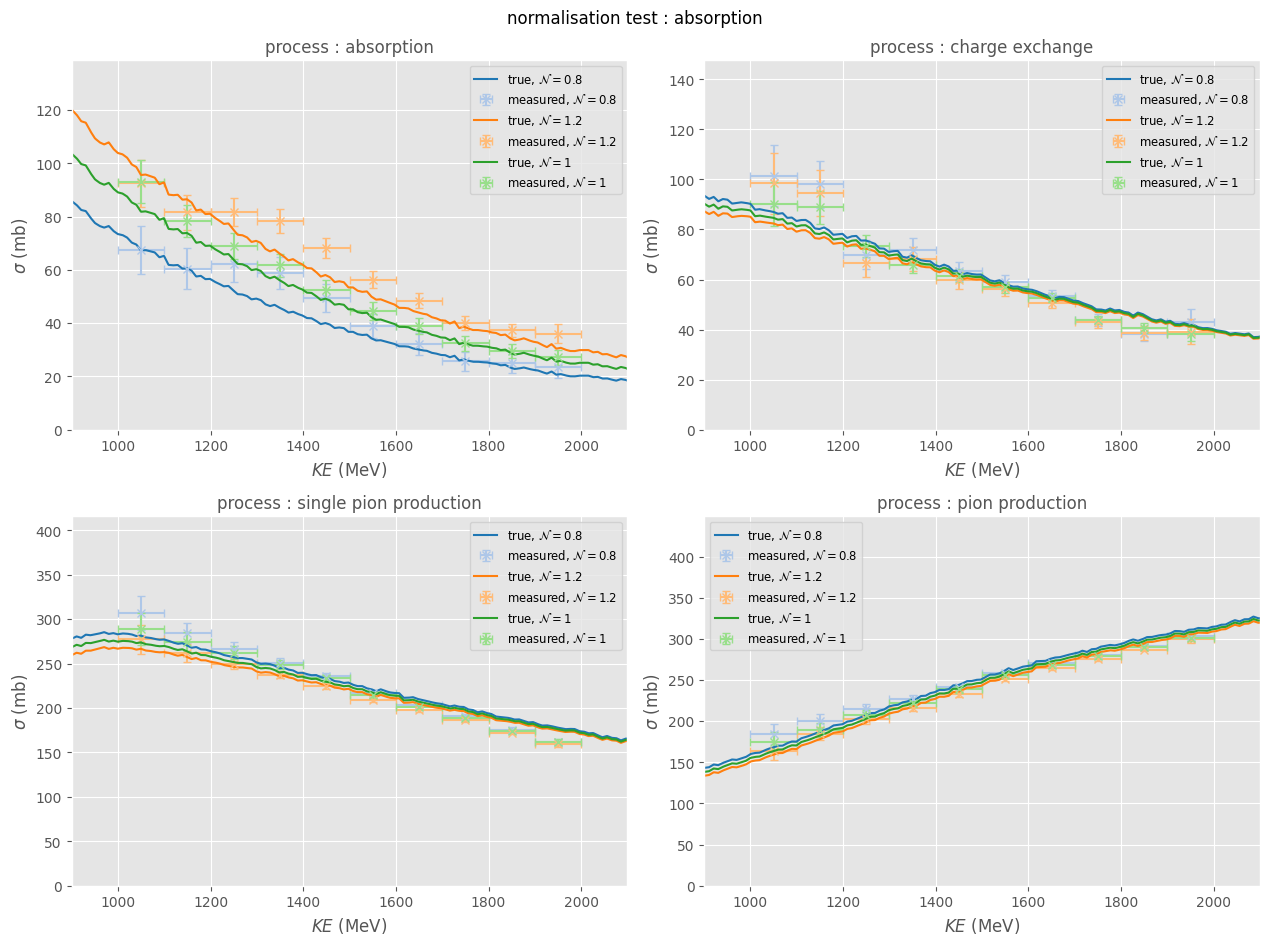

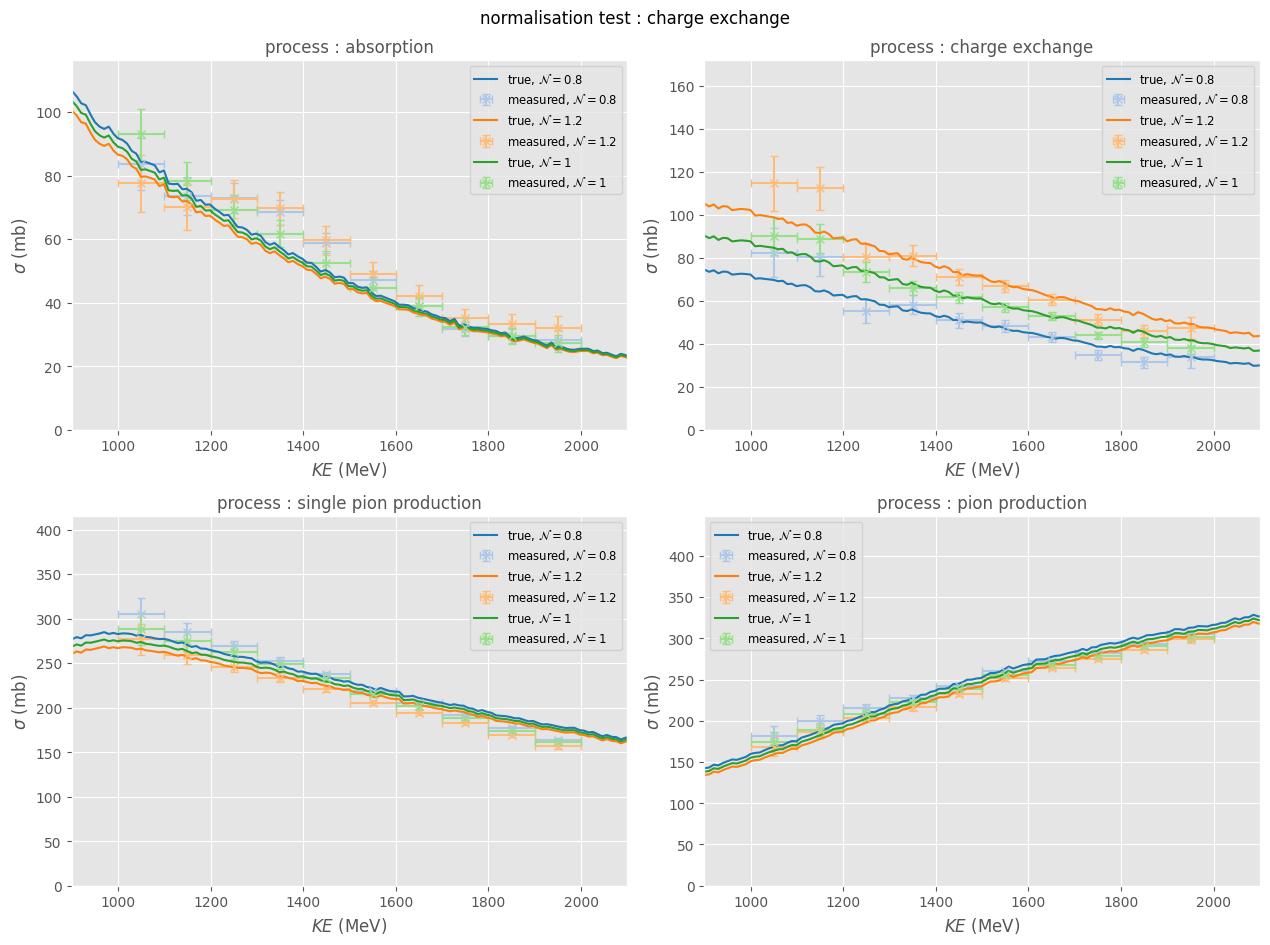

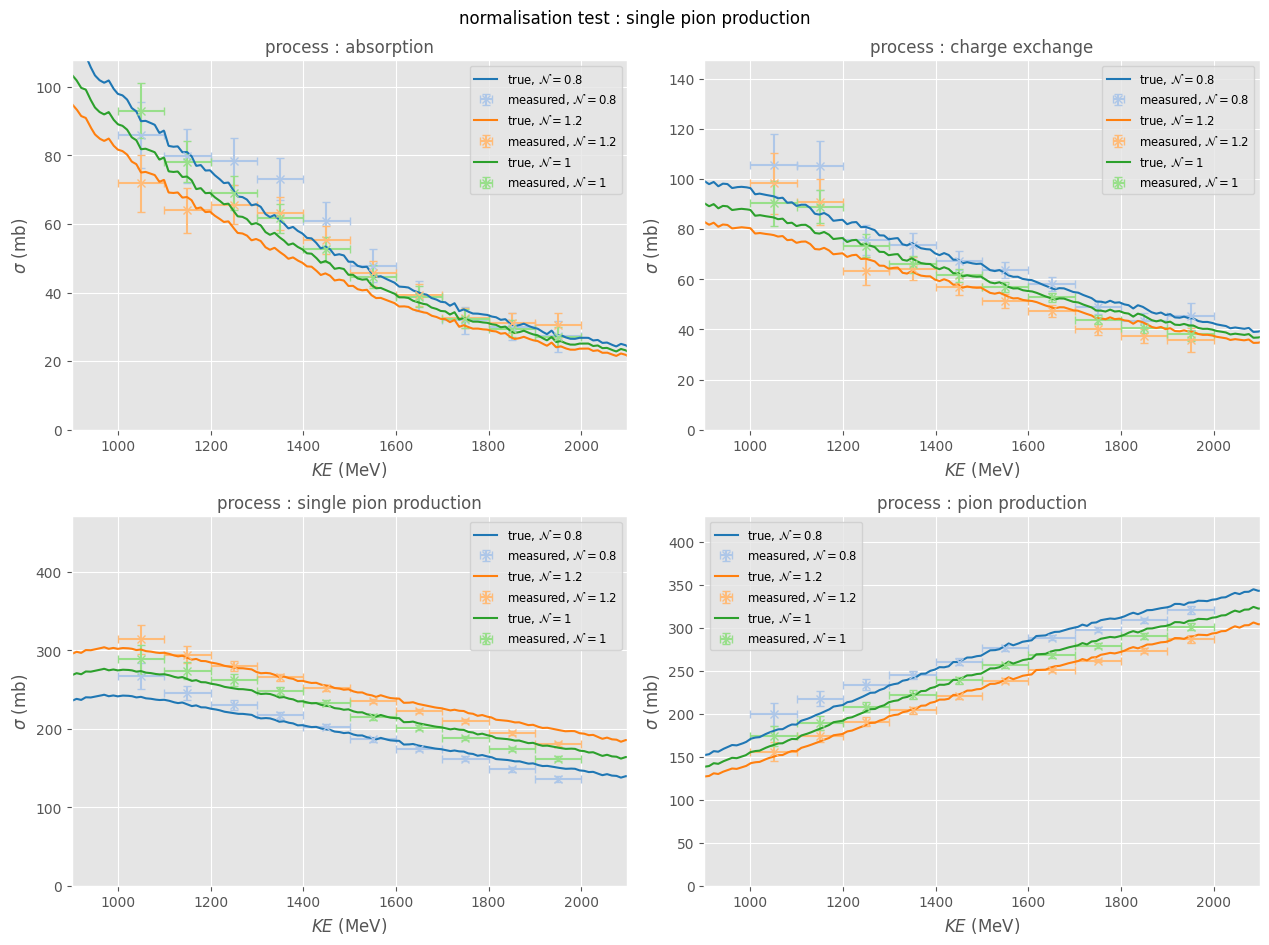

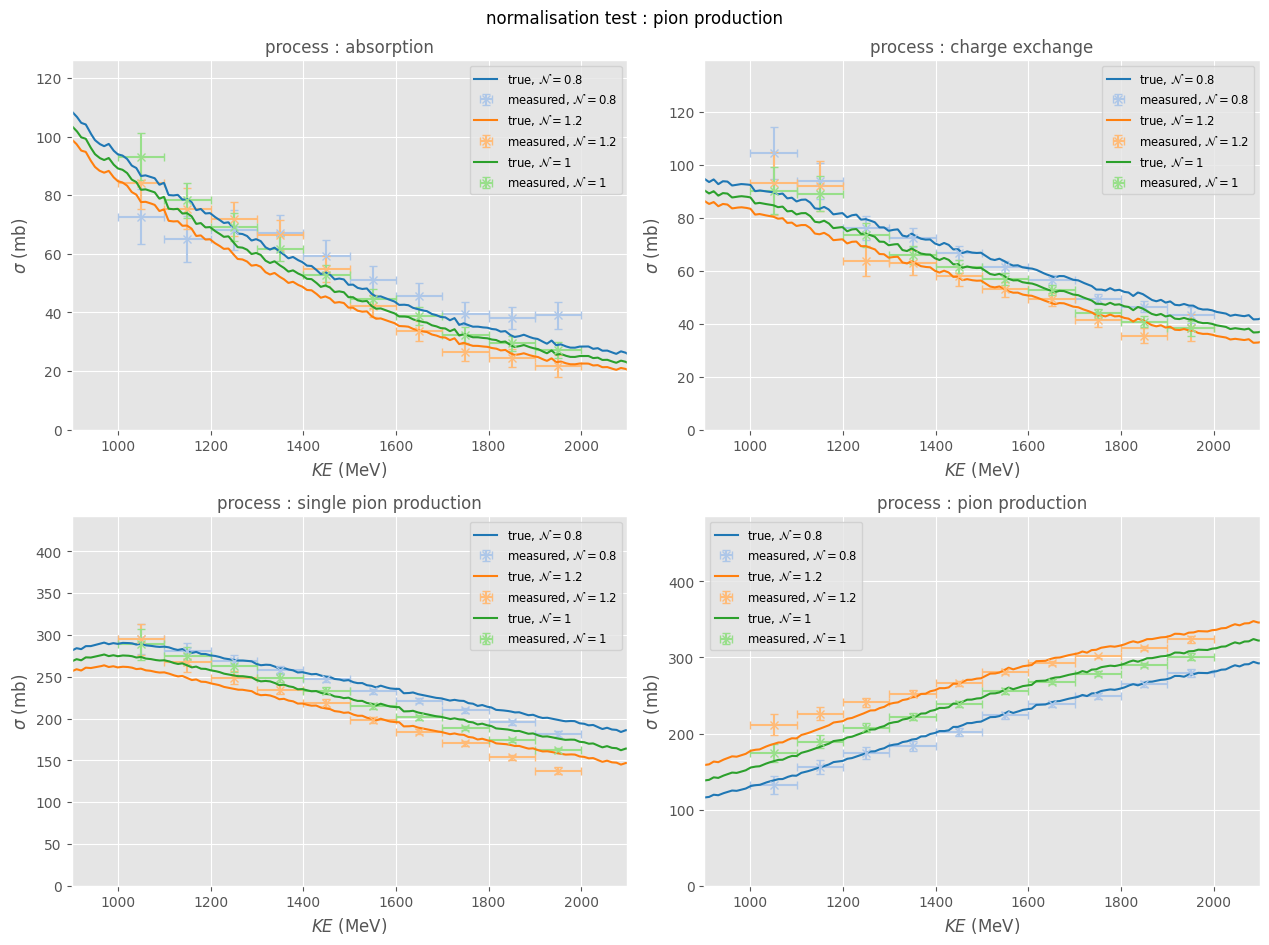

In [117]:
with Plots.PlotBook("test/normalisation_systematic/raw_results") as book:
    scale_factors = {"absorption" : 1, "charge_exchange" : 1, "pion_production" : 1, "double_charge_exchange" : 1, "quasielastic" : 1}
    for r in results[0]:
        for _, p in Plots.IterMultiPlot(results[0][r][0.8]):
            for n in results[0][r]:
                mod_norm = {k : v for k, v in scale_factors.items()}
                if r == "single_pion_production":
                    mod_norm["double_charge_exchange"] = n
                    mod_norm["quasielastic"] = n
                else:
                    mod_norm[r] = n
                mod_sim = cex_toy_generator.ModifyGeantXS(scale_factors = mod_norm, modified_PDFs = None)

                if p == "single_pion_production":
                    gxs = getattr(mod_sim, "double_charge_exchange") + getattr(mod_sim, "quasielastic")
                else:
                    gxs = getattr(mod_sim, p)

                Plots.Plot(mod_sim.KE, gxs, newFigure = False, label = f"true, $\mathcal{{N}} = {n}$", title = f"process : {cross_section.remove_(p)}", ylabel = "$\sigma$ (mb)", xlabel = "$KE$ (MeV)")
                Plots.Plot(args.energy_slices.pos[:-1] - args.energy_slices.width/2, results[0][r][n][p][0], yerr = results[0][r][n][p][1], xerr = args.energy_slices.width/2, marker = "x", linestyle = "", label = f"measured, $\mathcal{{N}} = {n}$", newFigure = False)
                Plots.plt.xlim(args.energy_slices.min_pos - args.energy_slices.width, args.energy_slices.max_pos + args.energy_slices.width)
                Plots.plt.ylim(0, 1.5 * max(results[0][r][n][p][0]))
            if p == "single_pion_production":
                gxs = getattr(xs_sim, "double_charge_exchange") + getattr(xs_sim, "quasielastic")
            else:
                gxs = getattr(xs_sim, p)
            Plots.Plot(mod_sim.KE, gxs, newFigure = False, label = f"true, $\mathcal{{N}} = 1$")
            Plots.Plot(args.energy_slices.pos[:-1] - args.energy_slices.width/2, xs_nominal[p][0], yerr = xs_nominal[p][1], xerr = args.energy_slices.width/2, marker = "x", linestyle = "", label = f"measured, $\mathcal{{N}} = 1$", newFigure = False)
        Plots.plt.suptitle(f"normalisation test : {cross_section.remove_(r)}")
        Plots.plt.tight_layout()
        book.Save()

In [ ]:
results = cross_section.SaveObject("test/normalisation_systematic_2GeV.dill")

In [17]:
book = Plots.PlotBook("normalisation_sys.pdf", False)

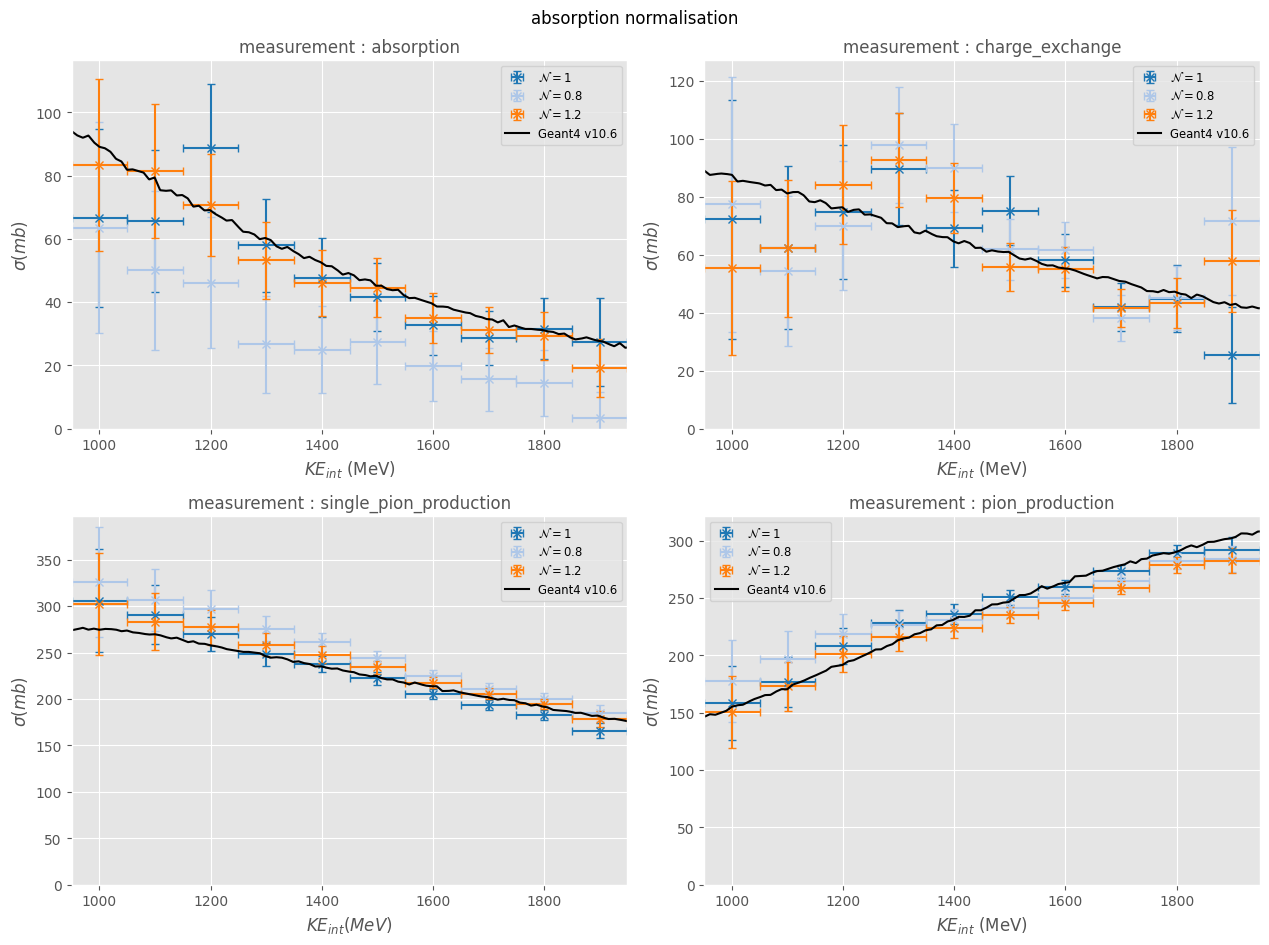

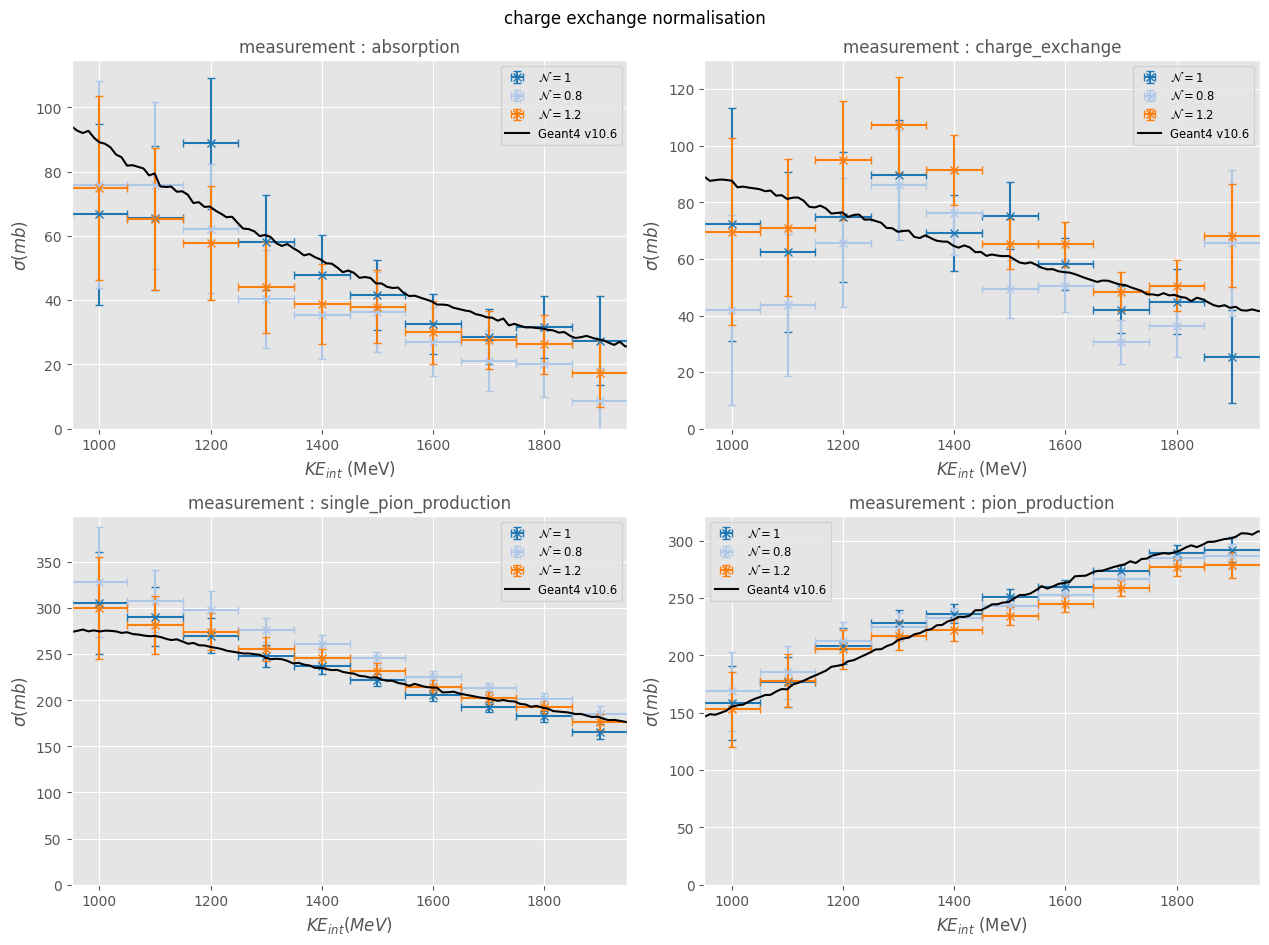

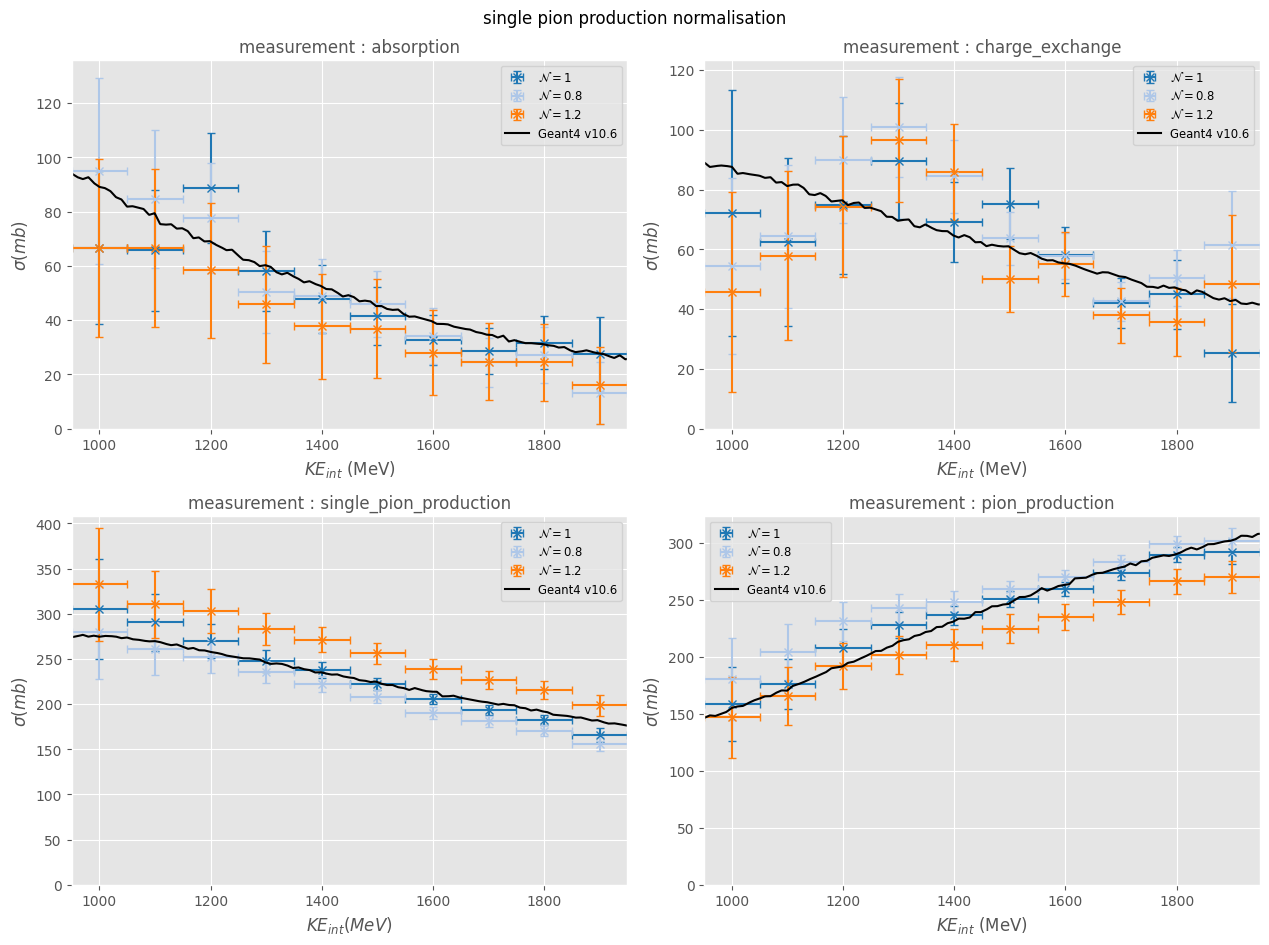

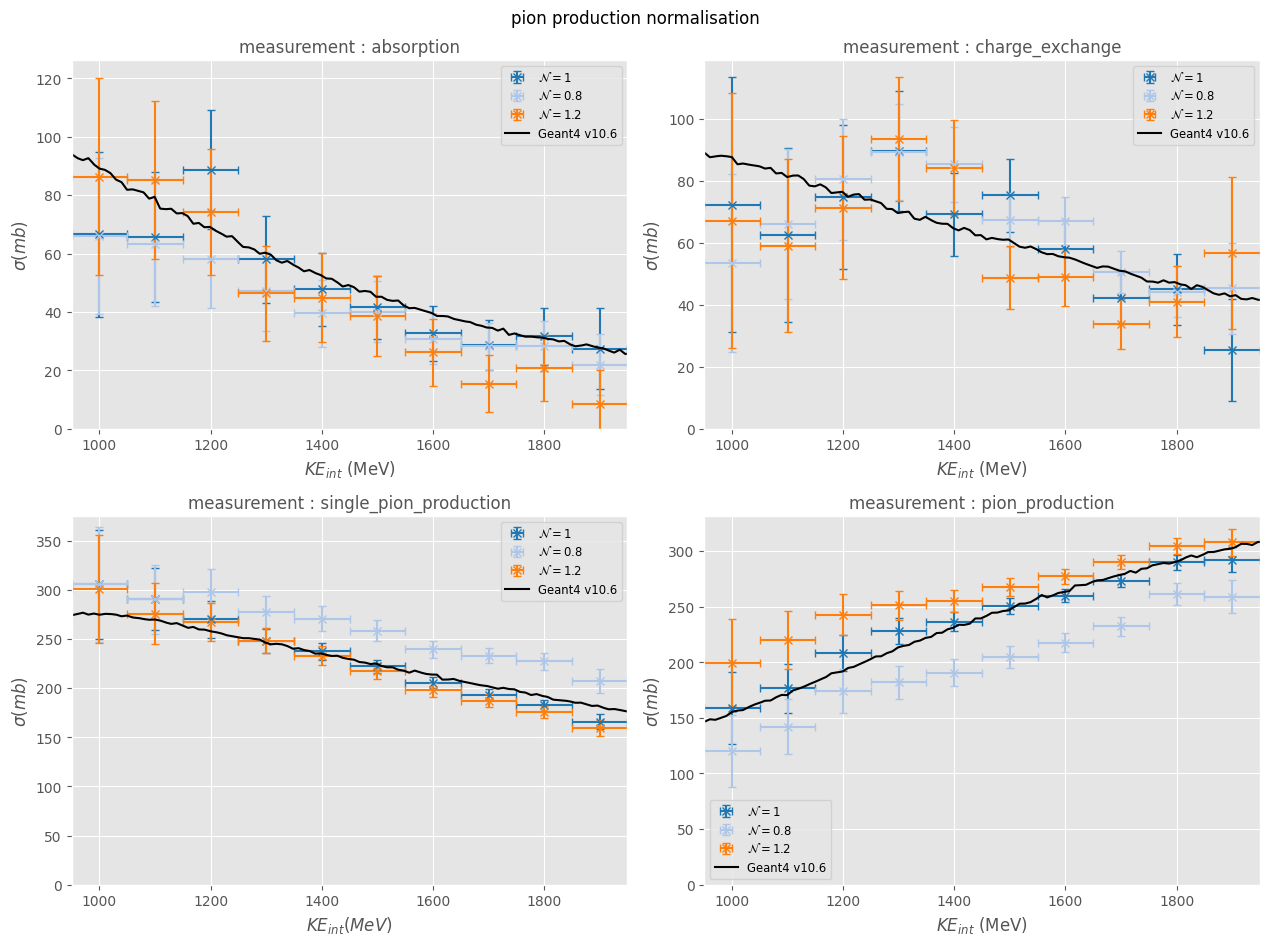

In [18]:
xs_sim = cross_section.GeantCrossSections()

for r in results[0]:
    for _, p in Plots.IterMultiPlot(analysis_input_nominal.exclusive_process):
        cross_section.PlotXSComparison({"$\mathcal{N}=1$" : xs_nominal[p], "$\mathcal{N}=0.8$" : results[0][r][0.8][p], "$\mathcal{N}=1.2$" : results[0][r][1.2][p]}, args.energy_slices, p, title = f"measurement : {p}", newFigure = False, chi2 = False, simulation_label = "Geant4 v10.6")
        
        if p == "single_pion_production":
            gxs = getattr(xs_sim, "double_charge_exchange") + getattr(xs_sim, "quasielastic")
        else:
            gxs = getattr(xs_sim, p)

        # Plots.plt.fill_between(xs_sim.KE, gxs * 0.8, gxs * 1.2, color = "k", alpha = 0.5, label = "theory uncertainty ($\pm20\%$)", zorder = 1)
        Plots.plt.legend()
    Plots.plt.suptitle(f"{cross_section.remove_(r)} normalisation")
    Plots.plt.tight_layout()
    book.Save()

In [43]:
sys_err_low = {}
sys_err_high = {}
for r in results[0]:
    sys_err_low[r] = {p : results[0][r][0.8][p][0] - results[1][r][0.8][p] for p in results[0][r][0.8]}
    sys_err_high[r] = {p : results[0][r][1.2][p][0] - results[1][r][1.2][p] for p in results[0][r][1.2]}


In [63]:
norm_sys_qs = {}
for p in analysis_input_nominal.exclusive_process:
    norm_sys_qs[p] = [
        cross_section.quadsum([sys_err_low[r][p] for r in sys_err_low[p]], 0),
        cross_section.quadsum([sys_err_high[r][p] for r in sys_err_high[p]], 0)
    ]

norm_sys_max = {}
for p in analysis_input_nominal.exclusive_process:
    norm_sys_max[p] = [
        np.max([sys_err_low[r][p] for r in sys_err_low[p]], 0),
        np.max([sys_err_high[r][p] for r in sys_err_high[p]], 0)
    ]


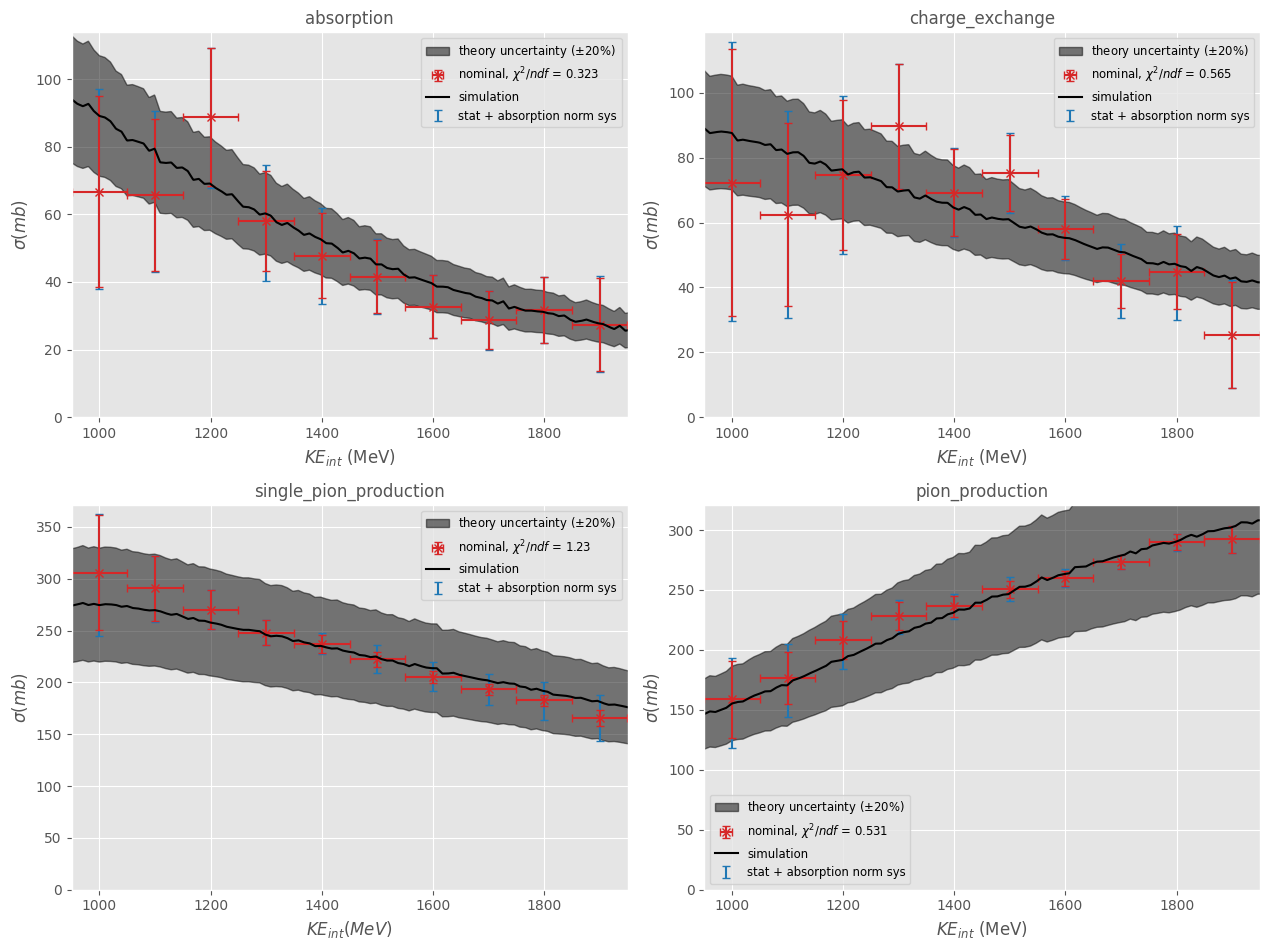

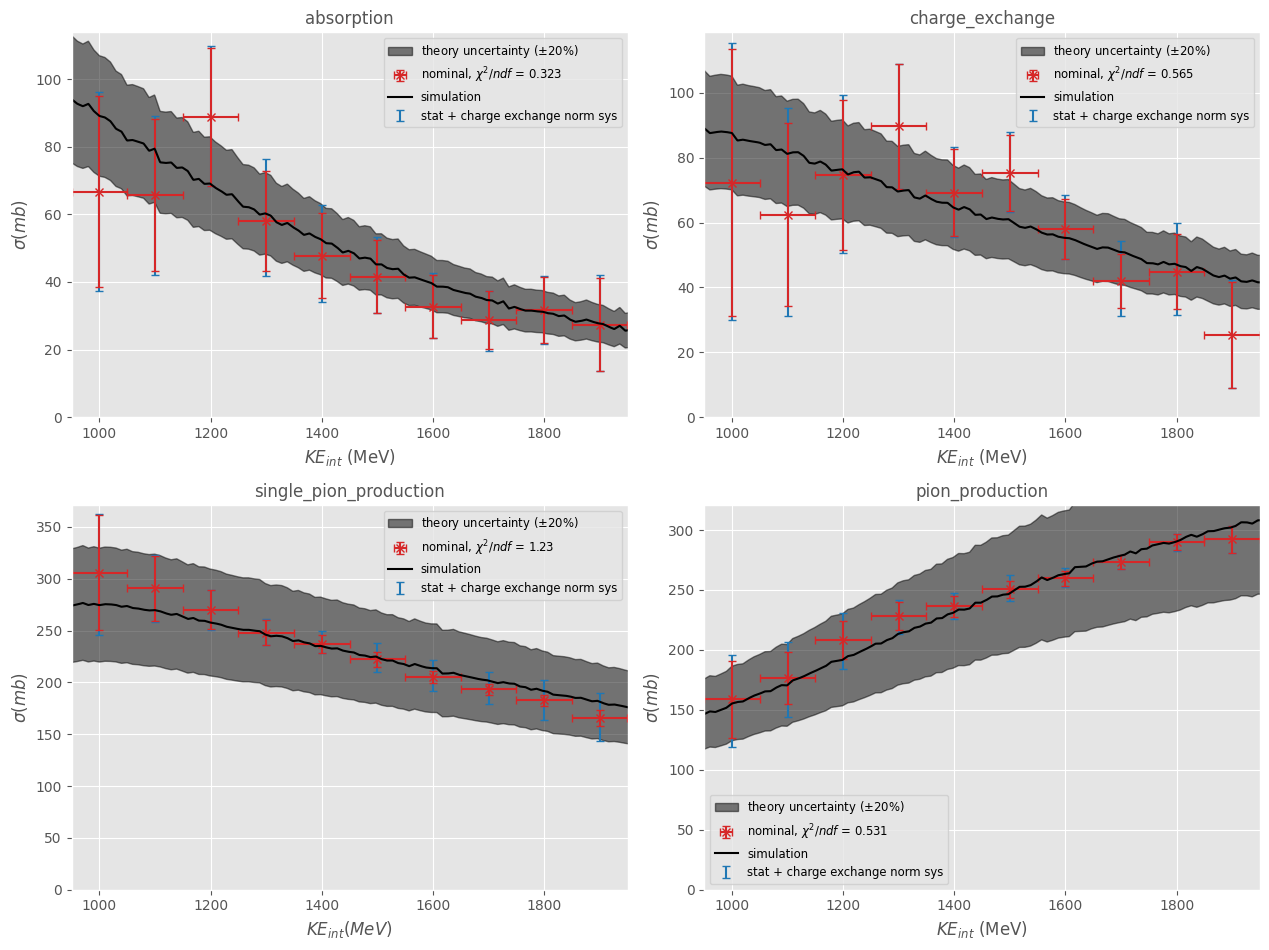

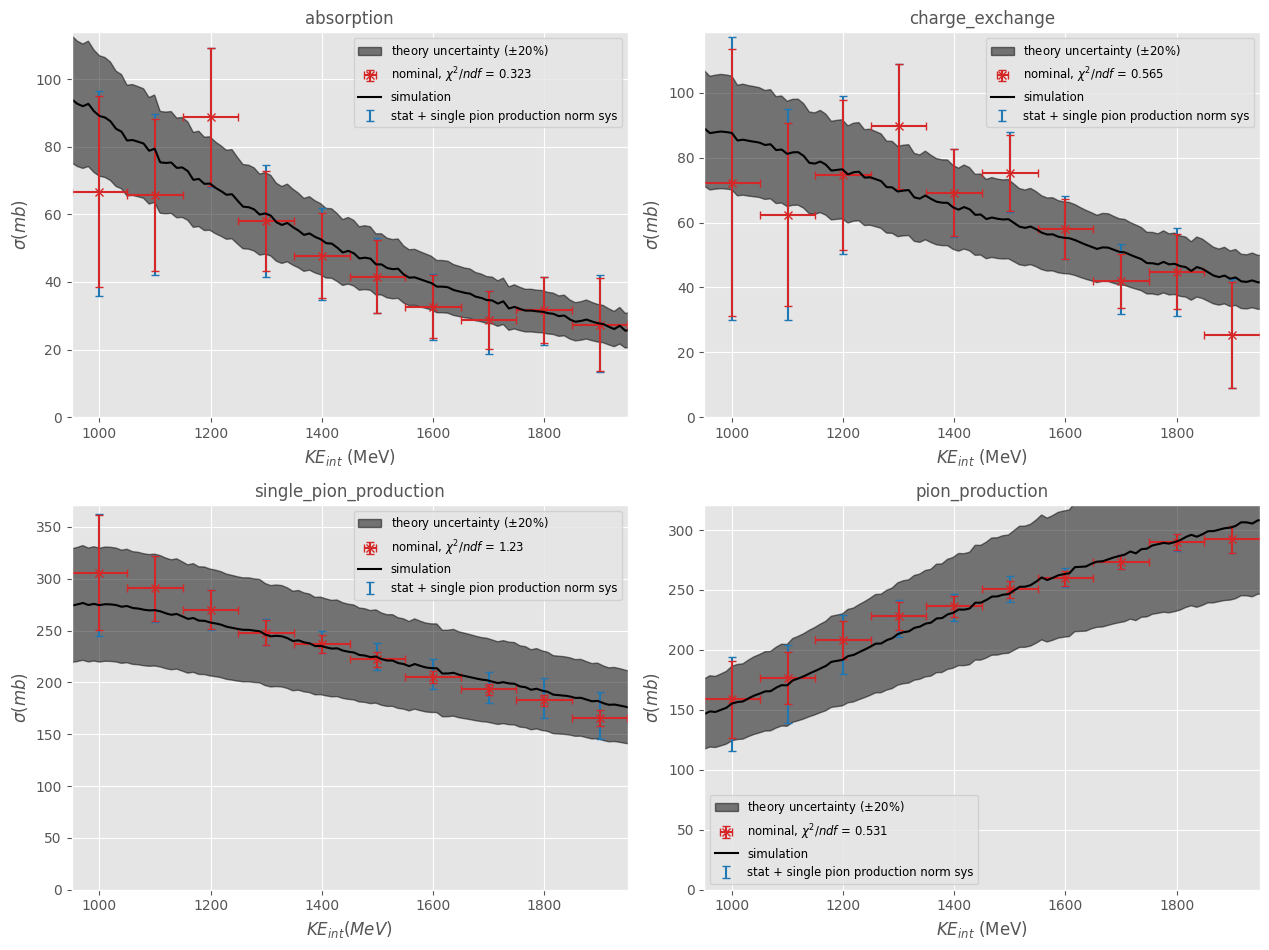

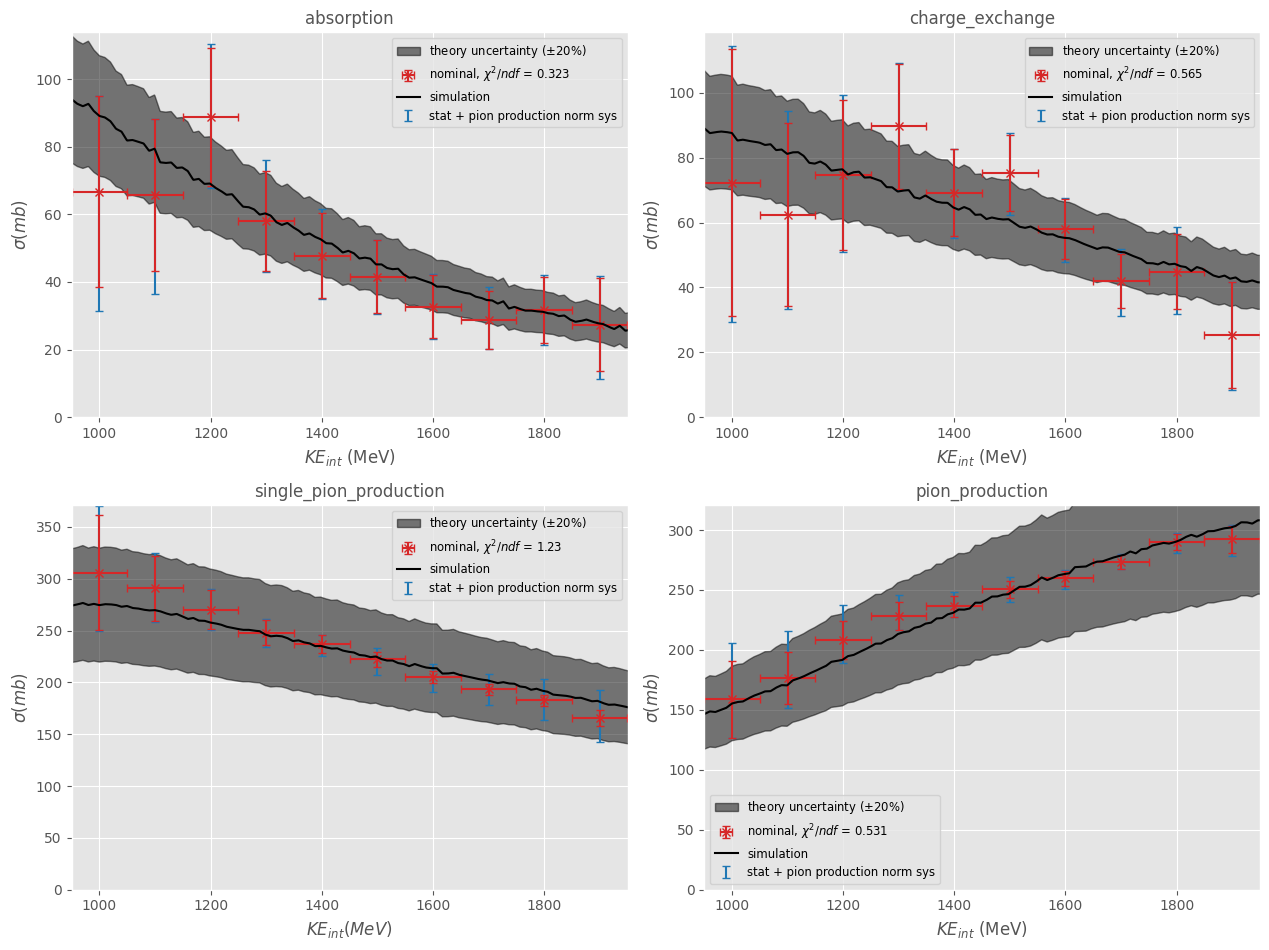

In [89]:
for r in results[0]:    
    for _, p in Plots.IterMultiPlot(analysis_input_nominal.exclusive_process):
        total_err_low = cross_section.quadsum([xs_nominal[p][1], sys_err_low[r][p]], 0)
        total_err_high = cross_section.quadsum([xs_nominal[p][1], sys_err_high[r][p]], 0)

        cross_section.PlotXSComparison({"nominal" : xs_nominal[p]}, args.energy_slices, p, {"nominal" : "C6"}, xs_sim_color = "k", title = p, newFigure = False)
        Plots.Plot(args.energy_slices.pos[1:], xs_nominal[p][0], yerr = [total_err_low, total_err_high], linestyle = "", marker = "", label = f"stat + {cross_section.remove_(r)} norm sys", newFigure = False, zorder = 1.5)

        if p == "single_pion_production":
            gxs = getattr(xs_sim, "double_charge_exchange") + getattr(xs_sim, "quasielastic")
        else:
            gxs = getattr(xs_sim, p)

        Plots.plt.fill_between(xs_sim.KE, gxs * 0.8, gxs * 1.2, color = "k", alpha = 0.5, label = "theory uncertainty ($\pm20\%$)", zorder = 1)
        Plots.plt.legend()
        book.Save()


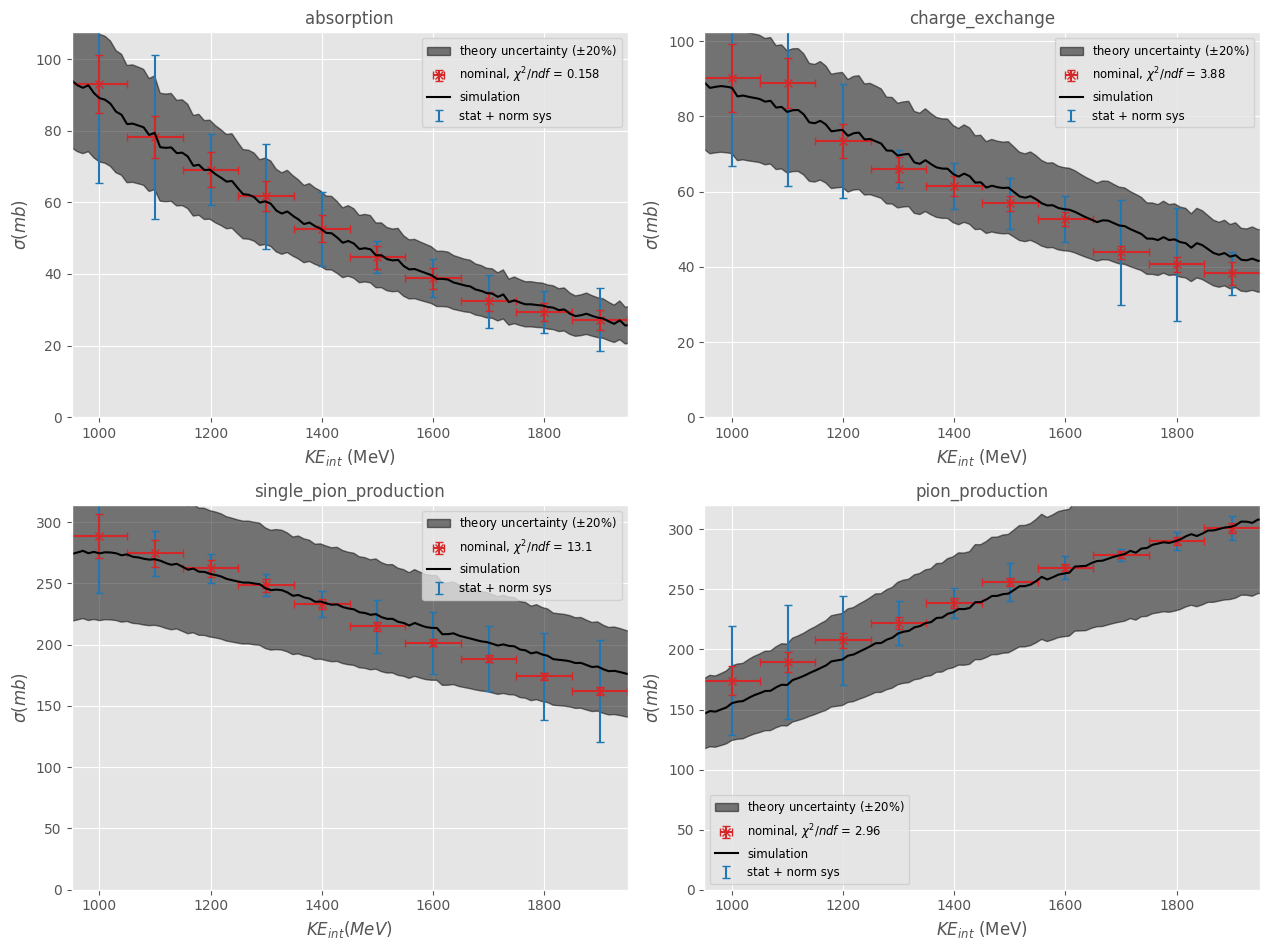

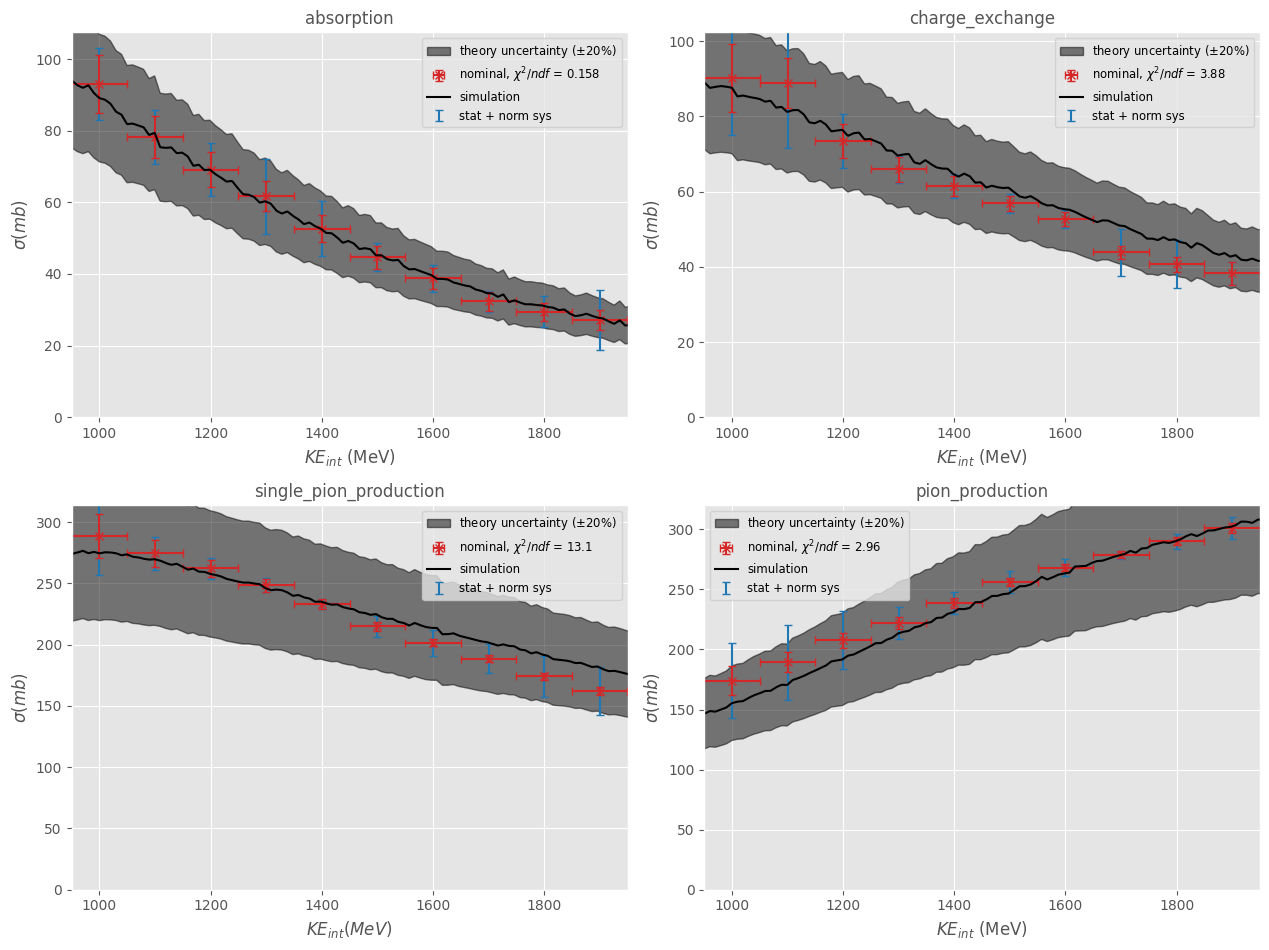

In [64]:
for _, p in Plots.IterMultiPlot(norm_sys_qs):
    total_err = [cross_section.quadsum([xs_nominal[p][1], norm_sys_qs[p][0]], 0) for i in range(2)]

    cross_section.PlotXSComparison({"nominal" : xs_nominal[p]}, args.energy_slices, p, {"nominal" : "C6"}, xs_sim_color = "k", title = p, newFigure = False)
    Plots.Plot(args.energy_slices.pos[1:], xs_nominal[p][0], yerr = total_err, linestyle = "", marker = "", label = f"stat + norm sys", newFigure = False, zorder = 1.5)

    if p == "single_pion_production":
        gxs = getattr(xs_sim, "double_charge_exchange") + getattr(xs_sim, "quasielastic")
    else:
        gxs = getattr(xs_sim, p)

    Plots.plt.fill_between(xs_sim.KE, gxs * 0.8, gxs * 1.2, color = "k", alpha = 0.5, label = "theory uncertainty ($\pm20\%$)", zorder = 1)
    Plots.plt.legend()
    book.Save()

for _, p in Plots.IterMultiPlot(norm_sys_max):
    total_err = [cross_section.quadsum([xs_nominal[p][1], norm_sys_max[p][0]], 0) for i in range(2)]

    cross_section.PlotXSComparison({"nominal" : xs_nominal[p]}, args.energy_slices, p, {"nominal" : "C6"}, xs_sim_color = "k", title = p, newFigure = False)
    Plots.Plot(args.energy_slices.pos[1:], xs_nominal[p][0], yerr = total_err, linestyle = "", marker = "", label = f"stat + norm sys", newFigure = False, zorder = 1.5)

    if p == "single_pion_production":
        gxs = getattr(xs_sim, "double_charge_exchange") + getattr(xs_sim, "quasielastic")
    else:
        gxs = getattr(xs_sim, p)

    Plots.plt.fill_between(xs_sim.KE, gxs * 0.8, gxs * 1.2, color = "k", alpha = 0.5, label = "theory uncertainty ($\pm20\%$)", zorder = 1)
    Plots.plt.legend()
    book.Save()

# norm_sys = []
# for r in results[0]:
#     err_low = SysErr(results[1][r][1.2], results[0][r][1.2][0])
#     err_high = SysErr(results[1][r][0.8], results[0][r][0.8][0])

#     sys_err_low = np.max([err_low[0], err_high[0]], 0)
#     sys_err_high = np.max([err_low[1], err_high[1]], 0)

#     norm_sys.append([sys_err_low, sys_err_high])

# total_norm_sys = cross_section.quadsum(norm_sys, 0)
# total_sys = [cross_section.quadsum([xs_nominal[1], total_norm_sys[0]], 0), cross_section.quadsum([xs_nominal[1], total_norm_sys[1]], 0)]

# cross_section.PlotXSComparison({"nominal" : xs_nominal}, args.energy_slices, "charge_exchange", {"nominal" : "C6"}, xs_sim_color = "k")
# Plots.Plot(args.energy_slices.pos - args.energy_slices.width/2, xs_nominal[0], yerr = total_sys, linestyle = "", marker = "", label = f"stat + sys", newFigure = False, zorder = 1.5)
# Plots.plt.fill_between(xs_sim.KE, getattr(xs_sim, args.signal_process) * 0.8, getattr(xs_sim, args.signal_process) * 1.2, color = "k", alpha = 0.5, label = "theory uncertainty ($\pm20\%$)", zorder = 1)
# Plots.plt.legend()

# book.Save()

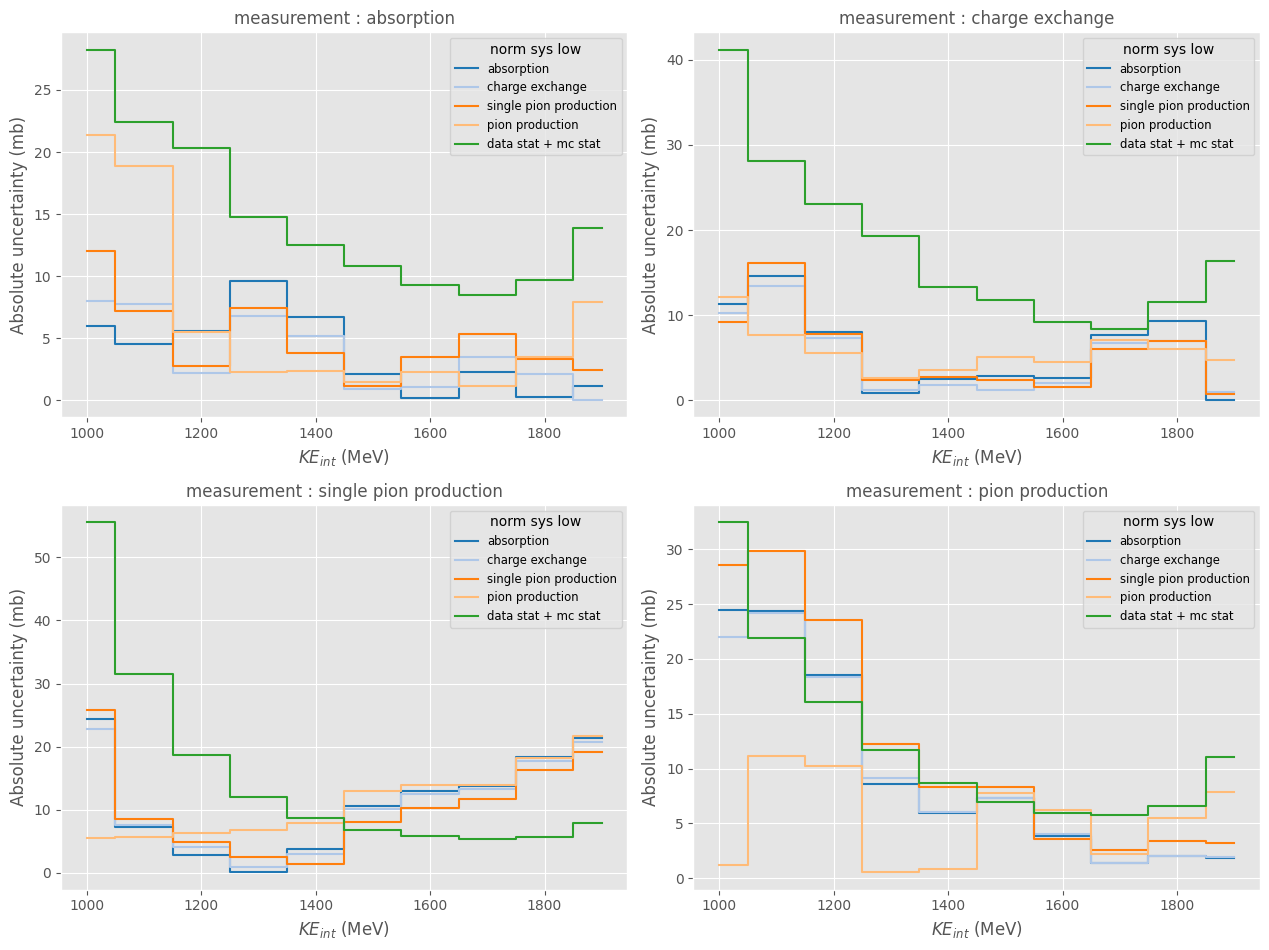

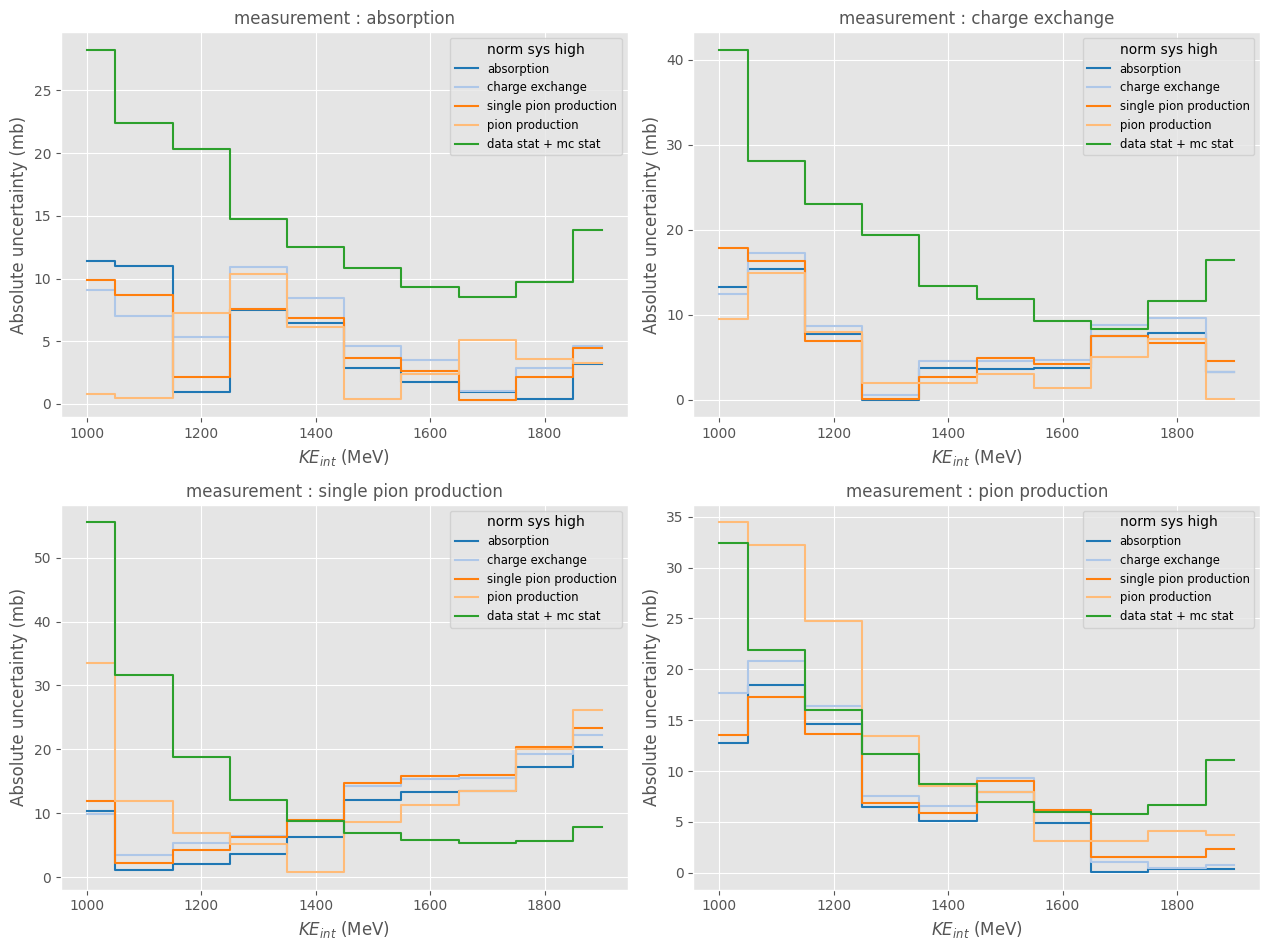

In [86]:
def PlotSys(sys, name : str):
    x = args.energy_slices.pos[1:]
    for _, p in Plots.IterMultiPlot(analysis_input_nominal.exclusive_process):
        for r in sys:
            Plots.Plot(x, abs(sys[r][p]), label = cross_section.remove_(r), title = f"measurement : {cross_section.remove_(p)}", xlabel = "$KE_{int}$ (MeV)", ylabel = "Absolute uncertainty (mb)", newFigure = False, style = "step")
        Plots.Plot(x, xs_nominal[p][1], label = "data stat + mc stat", newFigure = False, style = "step")
        Plots.plt.legend(title = name)

PlotSys(sys_err_low, "norm sys low")
PlotSys(sys_err_high, "norm sys high")

In [27]:
book.close()

/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Plots.py:890: UserWarning: pdf has not been opened.
  warnings.warn("pdf has not been opened.")


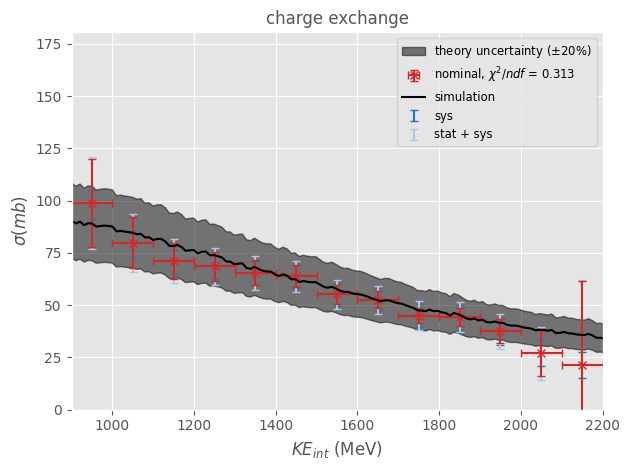

In [33]:
import itertools

def err_cov(norm):
    epsilon_sqr = None
    for r1, r2 in itertools.product(results, results):
        epsilon_1 = results[r1][norm][0] - xs_nominal[0]
        epsilon_2 = results[r2][norm][0] - xs_nominal[0]

        prod = epsilon_1 * epsilon_2

        if epsilon_sqr is None:
            epsilon_sqr = prod
        else:
            epsilon_sqr = epsilon_sqr + prod
    return np.sqrt(epsilon_sqr)

err_cov_total = np.array([err_cov(0.8), err_cov(1.2)])

cross_section.PlotXSComparison({"nominal" : xs_nominal}, args.energy_slices, "charge_exchange", {"nominal" : "C6"}, xs_sim_color = "k")
Plots.Plot(args.energy_slices.pos - args.energy_slices.width/2, xs_nominal[0], yerr = err_cov_total, linestyle = "", marker = "", label = f"sys", newFigure = False, zorder = 1.5)
Plots.Plot(args.energy_slices.pos - args.energy_slices.width/2, xs_nominal[0], yerr = cross_section.quadsum([xs_nominal[1], err_cov_total], 0), linestyle = "", marker = "", label = f"stat + sys", newFigure = False, zorder = 1.5)
Plots.plt.fill_between(xs_sim.KE, getattr(xs_sim, args.signal_process) * 0.8, getattr(xs_sim, args.signal_process) * 1.2, color = "k", alpha = 0.5, label = "theory uncertainty ($\pm20\%$)", zorder = 1)
Plots.plt.legend()


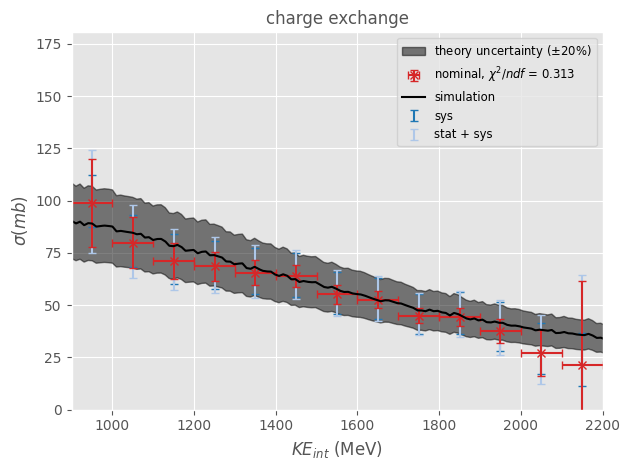

In [34]:
np.max(np.array(norm_sys)[:, 0], 0)
np.max(np.array(norm_sys)[:, 1], 0)

max_err = np.max(np.array(norm_sys), 0)

cross_section.PlotXSComparison({"nominal" : xs_nominal}, args.energy_slices, "charge_exchange", {"nominal" : "C6"}, xs_sim_color = "k")
Plots.Plot(args.energy_slices.pos - args.energy_slices.width/2, xs_nominal[0], yerr = max_err, linestyle = "", marker = "", label = f"sys", newFigure = False, zorder = 1.5)
Plots.Plot(args.energy_slices.pos - args.energy_slices.width/2, xs_nominal[0], yerr = cross_section.quadsum([xs_nominal[1], max_err], 0), linestyle = "", marker = "", label = f"stat + sys", newFigure = False, zorder = 1.5)
Plots.plt.fill_between(xs_sim.KE, getattr(xs_sim, args.signal_process) * 0.8, getattr(xs_sim, args.signal_process) * 1.2, color = "k", alpha = 0.5, label = "theory uncertainty ($\pm20\%$)", zorder = 1)
Plots.plt.legend()

(0.0, 20.0)

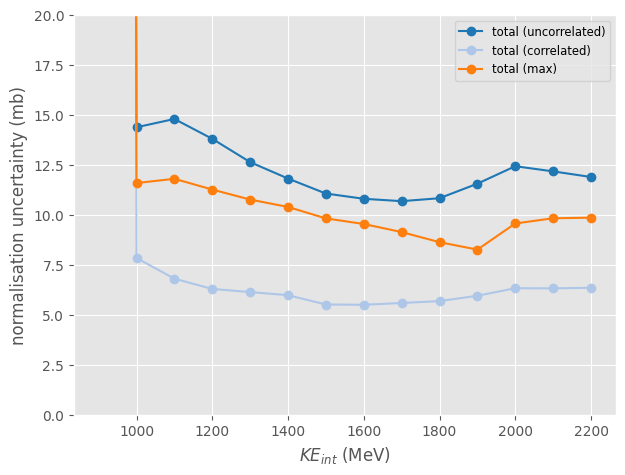

In [37]:
Plots.Plot(args.energy_slices.pos, total_norm_sys[0], label = "total (uncorrelated)", marker = "o")
Plots.Plot(args.energy_slices.pos, err_cov_total[0], label = "total (correlated)", marker = "o", newFigure = False)
Plots.Plot(args.energy_slices.pos, max_err[0], label = "total (max)", xlabel = "$KE_{int}$ (MeV)", ylabel = "normalisation uncertainty (mb)", marker = "o", newFigure = False)
Plots.plt.ylim(0, 20)

## without unfolding

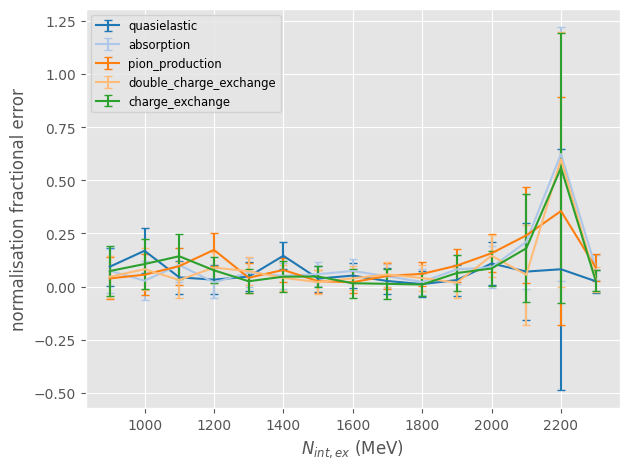

In [30]:
directory = "test/region_fit_studies_2GeV/normalisation_test_normal/"

s_fe_max, b_fe_max, s_fe_total_max, b_fe_total_max = cex_fit_studies.BackgroundSubtractionSummary(directory, model, "charge_exchange", args.toy_template, "normalisation")

for k in s_fe_max:
    Plots.Plot(energy_overflow, s_fe_max[k][0], yerr = s_fe_max[k][1], label = k, ylabel = "normalisation fractional error", xlabel = "$N_{int,ex}$ (MeV)", newFigure = False)
book.Save()

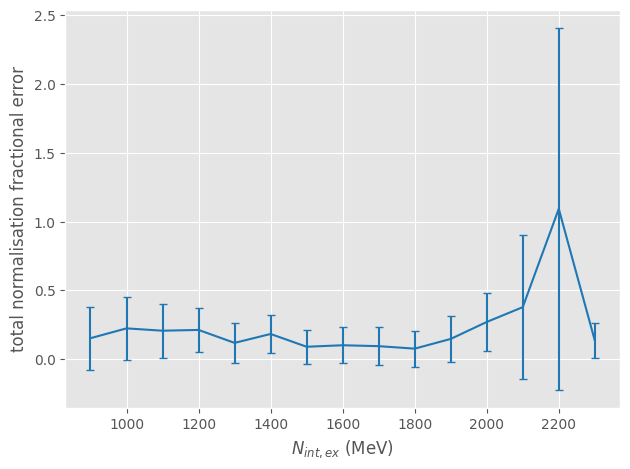

In [31]:
s_fe_sum = cross_section.quadsum([s_fe_max[i][0] for i in s_fe_max], 0)

s_fe_sum_err = cross_section.quadsum([s_fe_max[i][1] for i in s_fe_max], 0)

Plots.Plot(energy_overflow, s_fe_sum, yerr = s_fe_sum_err, ylabel = "total normalisation fractional error", xlabel = "$N_{int,ex}$ (MeV)")
book.Save()

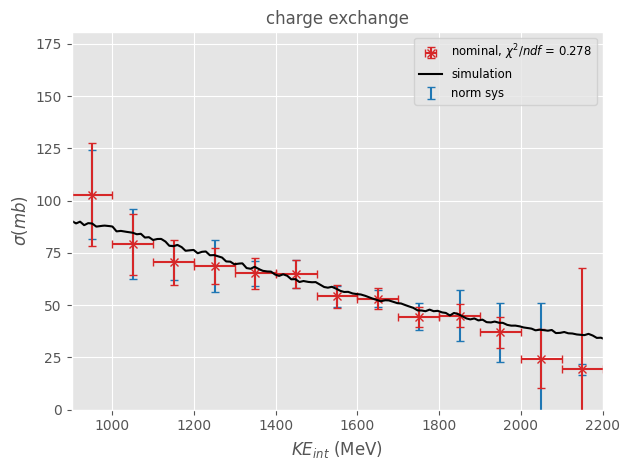

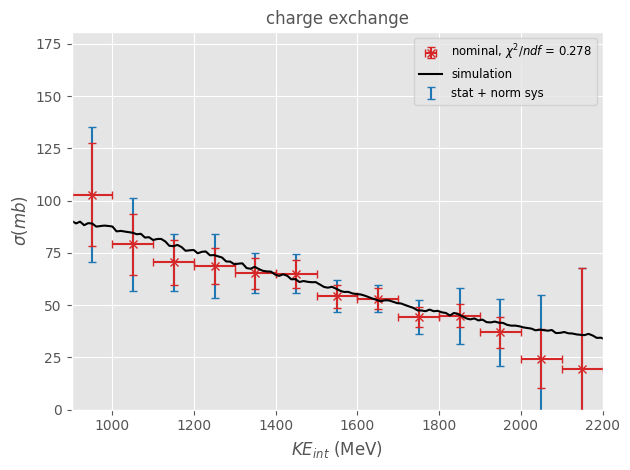

In [39]:
norm_err = abs(s_fe_sum[:-1] * xs_nominal[0])
cross_section.PlotXSComparison({"nominal" : xs_nominal}, args.energy_slices, "charge_exchange", {"nominal" : "C6"}, xs_sim_color = "k")
Plots.Plot(args.energy_slices.pos - args.energy_slices.width/2, xs_nominal[0], yerr = norm_err, linestyle = "", marker = "", label = "norm sys", newFigure = False, zorder = 1)
book.Save()
cross_section.PlotXSComparison({"nominal" : xs_nominal}, args.energy_slices, "charge_exchange", {"nominal" : "C6"}, xs_sim_color = "k")
Plots.Plot(args.energy_slices.pos - args.energy_slices.width/2, xs_nominal[0], yerr = cross_section.quadsum([norm_err, xs_nominal[1]], 0), linestyle = "", marker = "", label = "stat + norm sys", newFigure = False, zorder = 1)
book.Save()

# cross_section.PlotXSComparison({"nominal" : xs_nominal}, args.energy_slices, "charge_exchange", {"nominal" : "C0"}, xs_sim_color = "k")

In [33]:
book.close()

pdf normalisation_sys.pdf has been closed


# Detector parameterisation systematic

In [40]:
def CreateNewAnalysisInput(toy : cross_section.Toy, new_smearing : cross_section.pd.DataFrame):
    new_smeared = cex_toy_generator.ApplySmearing(toy.df, new_smearing)
    analysis_input = cross_section.AnalysisInput.CreateAnalysisInputToy(toy)
    analysis_input.KE_init_reco = new_smeared.KE_init_smeared
    analysis_input.track_length_reco = new_smeared.z_int_smeared
    analysis_input.KE_int_reco = new_smeared.KE_int_smeared
    return analysis_input


In [41]:
smearing_params = {
    "KE_init" : cross_section.LoadConfiguration("/home/sb16165/Documents/pi0-analysis/analysis/work/2023/PDSPProd4a_MC_2GeV_reco1_sce_datadriven_v1_ntuple_v09_41_00_03/toy_parameters/smearing/KE_init/double_crystal_ball.json"),
    "KE_int" : cross_section.LoadConfiguration("/home/sb16165/Documents/pi0-analysis/analysis/work/2023/PDSPProd4a_MC_2GeV_reco1_sce_datadriven_v1_ntuple_v09_41_00_03/toy_parameters/smearing/KE_int/double_crystal_ball.json"),
    "z_int" : cross_section.LoadConfiguration("/home/sb16165/Documents/pi0-analysis/analysis/work/2023/PDSPProd4a_MC_2GeV_reco1_sce_datadriven_v1_ntuple_v09_41_00_03/toy_parameters/smearing/z_int/double_crystal_ball.json")
    }

p_high = {}
p_low = {}
for i, j in smearing_params.items():
    p_high[i] = {k : j["values"][k] + j["errors"][k] for k in j["values"]}
    p_low[i] = {k : j["values"][k] - j["errors"][k] for k in j["values"]}

smearing = cross_section.pd.DataFrame({f"{k}_smearing" : cross_section.Fitting.RejectionSampling(len(toy_nominal.df), min(v["range"]), max(v["range"]), getattr(cross_section.Fitting, v["function"]), v["values"], rng = np.random.default_rng(1)) for k, v in smearing_params.items()})
analysis_input_nominal = CreateNewAnalysisInput(toy_nominal, smearing)


model.config.suggested_init()=[1.0, 1.0, 1.0, 1.0]
model.logpdf(pars=model.config.suggested_init(), data=observations)=array([-6697481.07954271])


signal: charge_exchange

Iteration 1: ts = 0.0002, ts_stopping = 0.0001
Iteration 2: ts = 0.0001, ts_stopping = 0.0001
Iteration 3: ts = 0.0001, ts_stopping = 0.0001
Iteration 1: ts = 0.0002, ts_stopping = 0.0001
Iteration 2: ts = 0.0001, ts_stopping = 0.0001
Iteration 3: ts = 0.0001, ts_stopping = 0.0001
Iteration 4: ts = 0.0001, ts_stopping = 0.0001
Iteration 5: ts = 0.0001, ts_stopping = 0.0001
Iteration 6: ts = 0.0001, ts_stopping = 0.0001
Iteration 1: ts = 0.0063, ts_stopping = 0.0001
Iteration 2: ts = 0.0028, ts_stopping = 0.0001
Iteration 3: ts = 0.0014, ts_stopping = 0.0001
Iteration 4: ts = 0.0008, ts_stopping = 0.0001
Iteration 5: ts = 0.0009, ts_stopping = 0.0001
Iteration 6: ts = 0.0009, ts_stopping = 0.0001
Iteration 7: ts = 0.0008, ts_stopping = 0.0001
Iteration 8: ts = 0.0007, ts_stopping = 0.0001
Iteration 9: ts = 0.0006, ts_stopping = 0.0001
Iteration 10: ts = 0.0006, ts_stopping = 0.0001


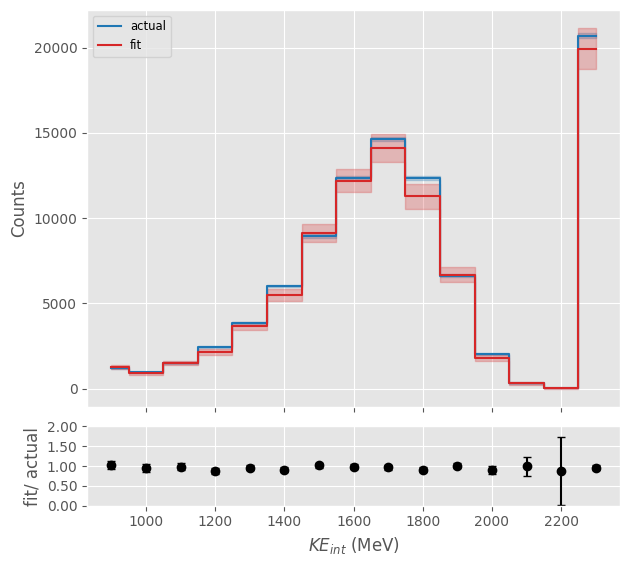

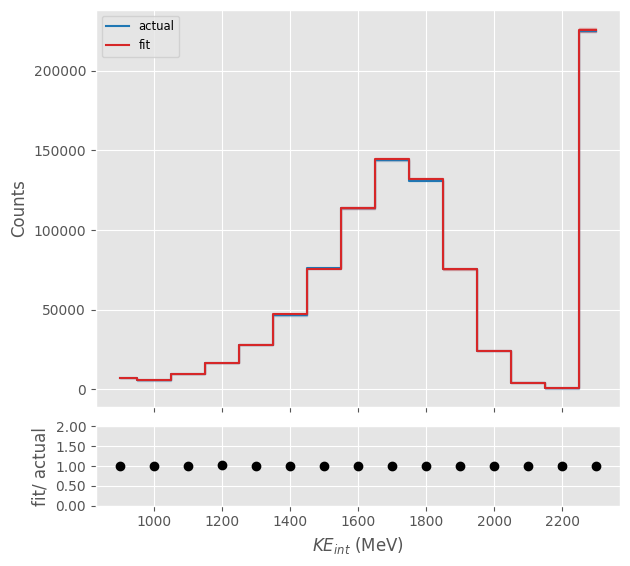

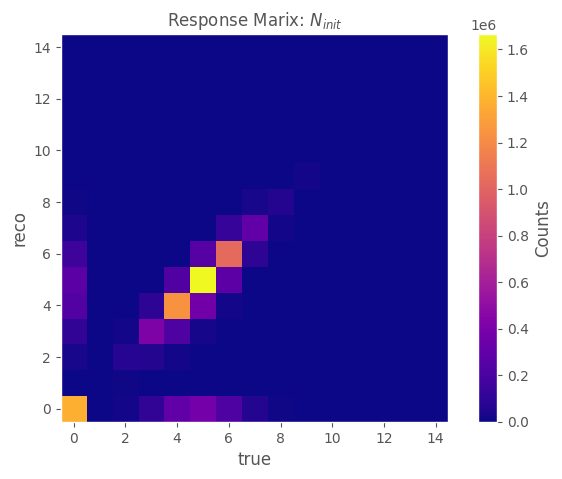

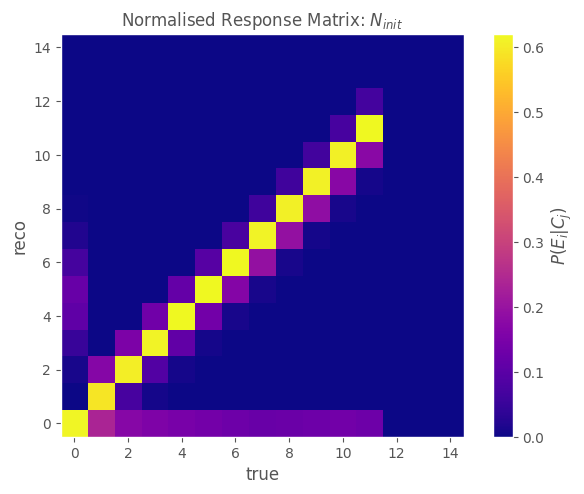

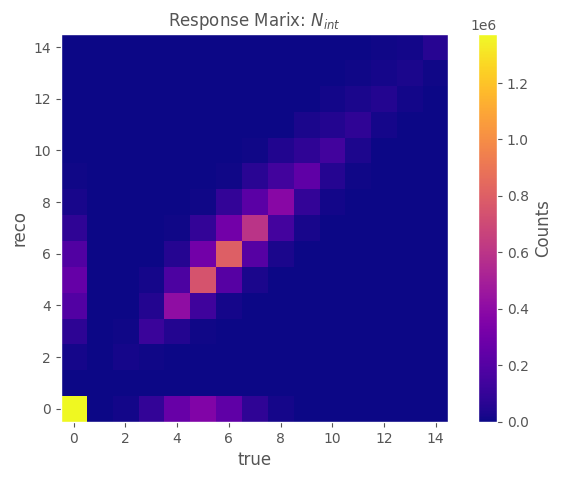

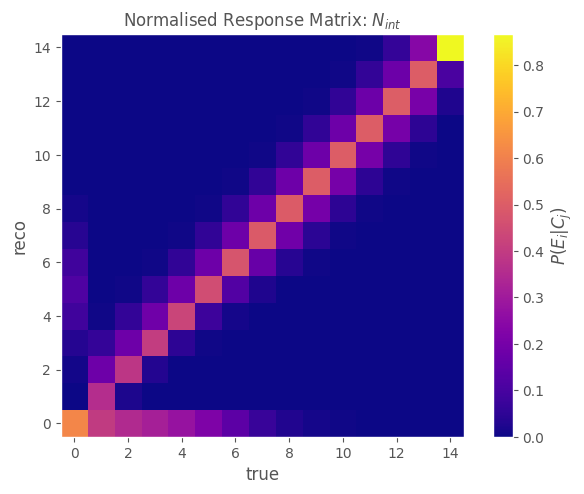

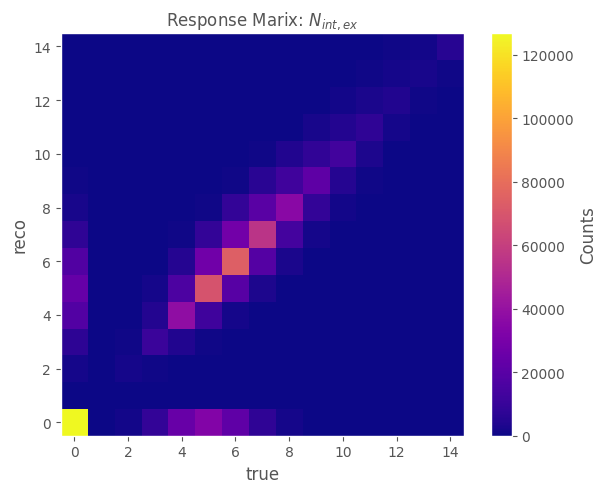

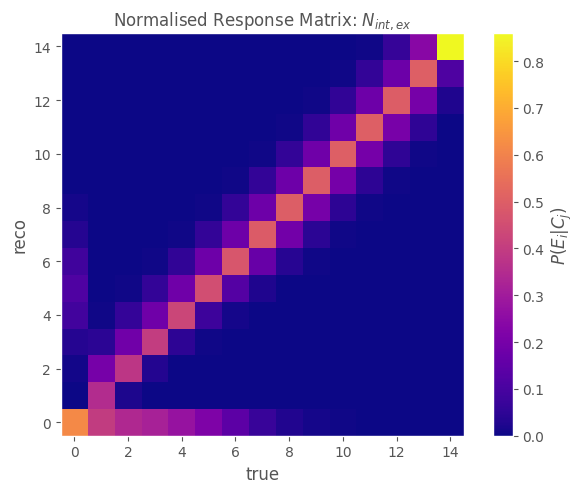

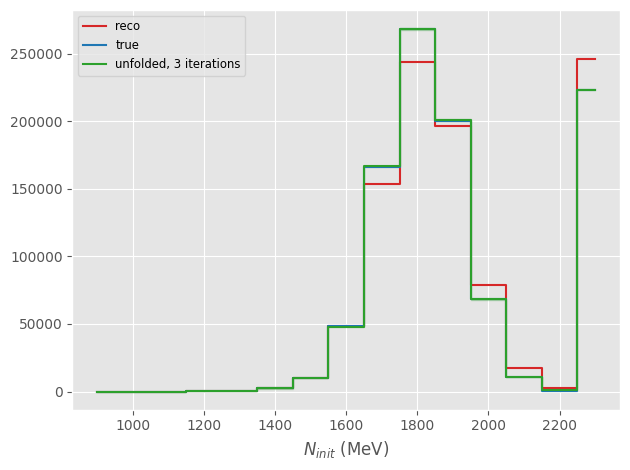

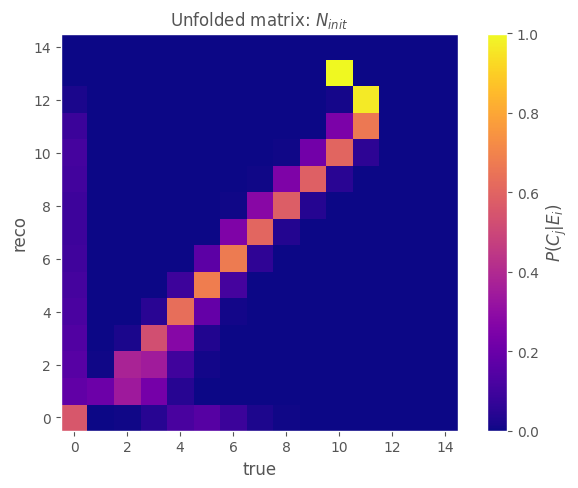

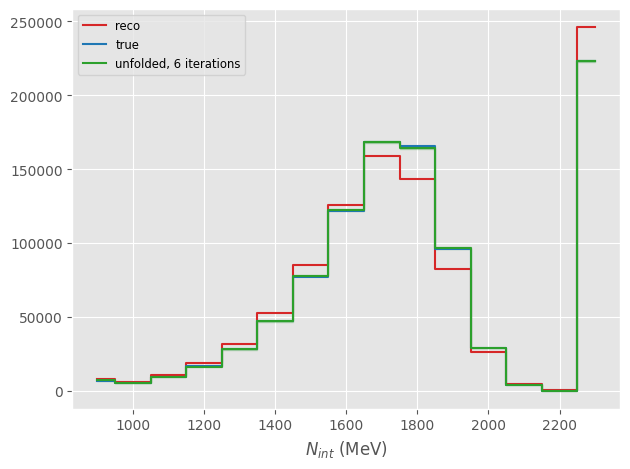

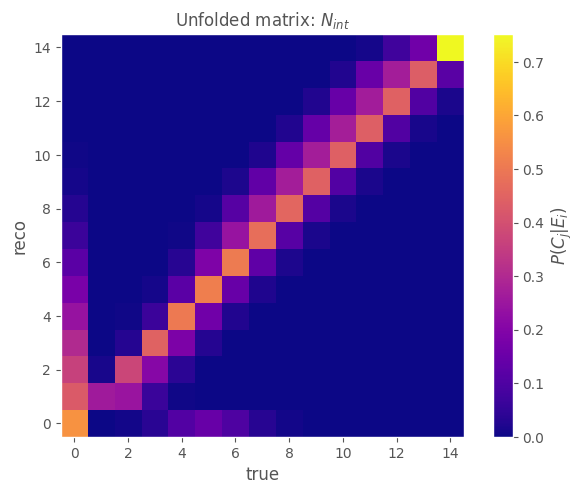

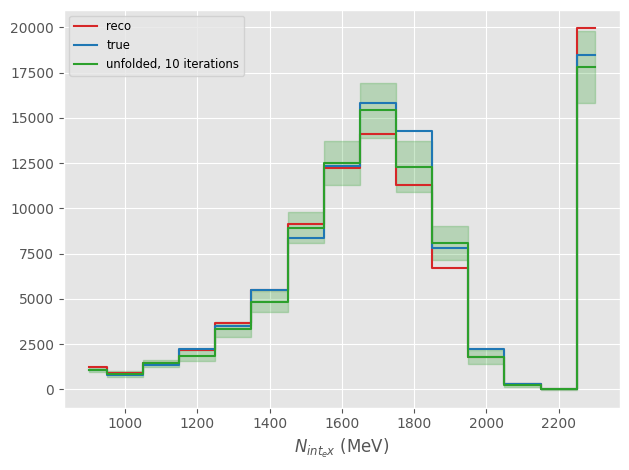

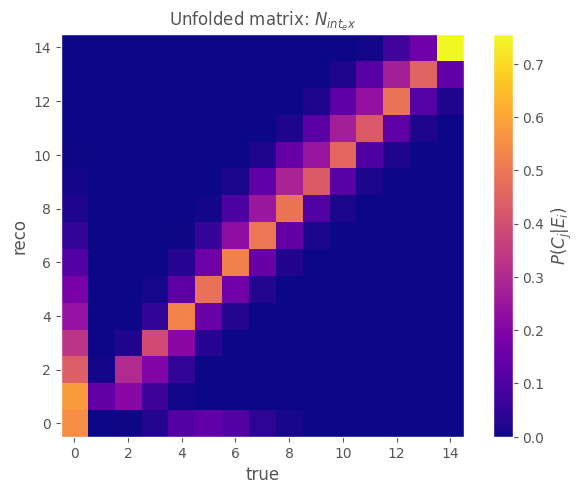

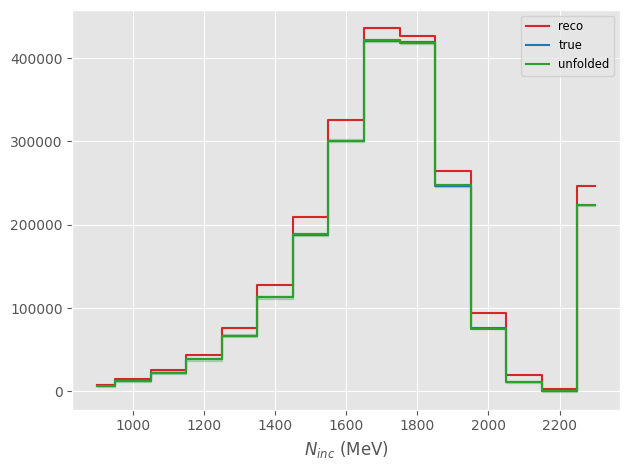

In [42]:
xs_nominal = Analyse(analysis_input_nominal, model, args, args.energy_slices, None)

model.config.suggested_init()=[1.0, 1.0, 1.0, 1.0]
model.logpdf(pars=model.config.suggested_init(), data=observations)=array([-6697490.2922123])


signal: charge_exchange

Iteration 1: ts = 0.0008, ts_stopping = 0.0001
Iteration 2: ts = 0.0005, ts_stopping = 0.0001
Iteration 3: ts = 0.0003, ts_stopping = 0.0001
Iteration 4: ts = 0.0002, ts_stopping = 0.0001
Iteration 5: ts = 0.0001, ts_stopping = 0.0001
Iteration 6: ts = 0.0001, ts_stopping = 0.0001
Iteration 7: ts = 0.0001, ts_stopping = 0.0001
Iteration 1: ts = 0.0009, ts_stopping = 0.0001
Iteration 2: ts = 0.0003, ts_stopping = 0.0001
Iteration 3: ts = 0.0003, ts_stopping = 0.0001
Iteration 4: ts = 0.0003, ts_stopping = 0.0001
Iteration 5: ts = 0.0002, ts_stopping = 0.0001
Iteration 6: ts = 0.0002, ts_stopping = 0.0001
Iteration 7: ts = 0.0002, ts_stopping = 0.0001
Iteration 8: ts = 0.0002, ts_stopping = 0.0001
Iteration 9: ts = 0.0001, ts_stopping = 0.0001
Iteration 10: ts = 0.0001, ts_stopping = 0.0001
Iteration 1: ts = 0.0036, ts_stopping = 0.0001
Iteration 2: ts = 0.0036, ts_stopping = 0.0001
Iteration 3: ts = 0.0033, ts_stopping = 0.0001
Iteration 4: ts = 0.0029, ts_stopping = 0.0001
Iteration 5:

signal: charge_exchange

Iteration 1: ts = 0.0007, ts_stopping = 0.0001
Iteration 2: ts = 0.0005, ts_stopping = 0.0001
Iteration 3: ts = 0.0004, ts_stopping = 0.0001
Iteration 4: ts = 0.0003, ts_stopping = 0.0001
Iteration 5: ts = 0.0002, ts_stopping = 0.0001
Iteration 6: ts = 0.0002, ts_stopping = 0.0001
Iteration 7: ts = 0.0001, ts_stopping = 0.0001
Iteration 8: ts = 0.0001, ts_stopping = 0.0001
Iteration 9: ts = 0.0001, ts_stopping = 0.0001
Iteration 1: ts = 0.0015, ts_stopping = 0.0001
Iteration 2: ts = 0.0004, ts_stopping = 0.0001
Iteration 3: ts = 0.0004, ts_stopping = 0.0001
Iteration 4: ts = 0.0004, ts_stopping = 0.0001
Iteration 5: ts = 0.0003, ts_stopping = 0.0001
Iteration 6: ts = 0.0003, ts_stopping = 0.0001
Iteration 7: ts = 0.0003, ts_stopping = 0.0001
Iteration 8: ts = 0.0002, ts_stopping = 0.0001
Iteration 9: ts = 0.0002, ts_stopping = 0.0001
Iteration 10: ts = 0.0002, ts_stopping = 0.0001
Iteration 1: ts = 0.0138, ts_stopping = 0.0001
Iteration 2: ts = 0.0041, ts_stopping = 0.0001
Iteration 3:

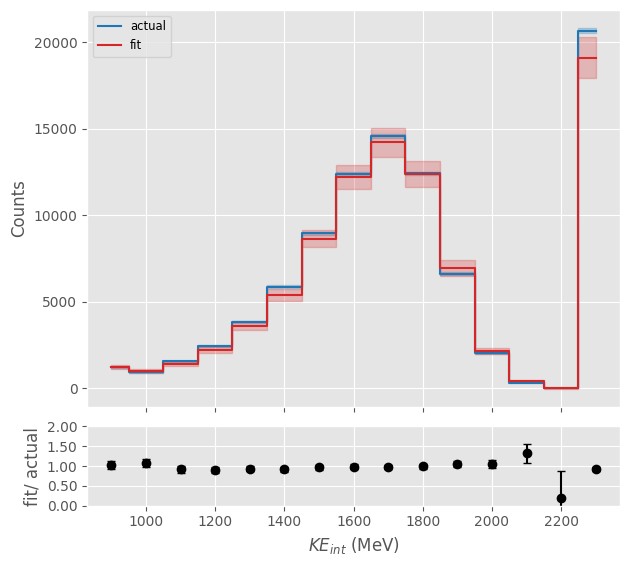

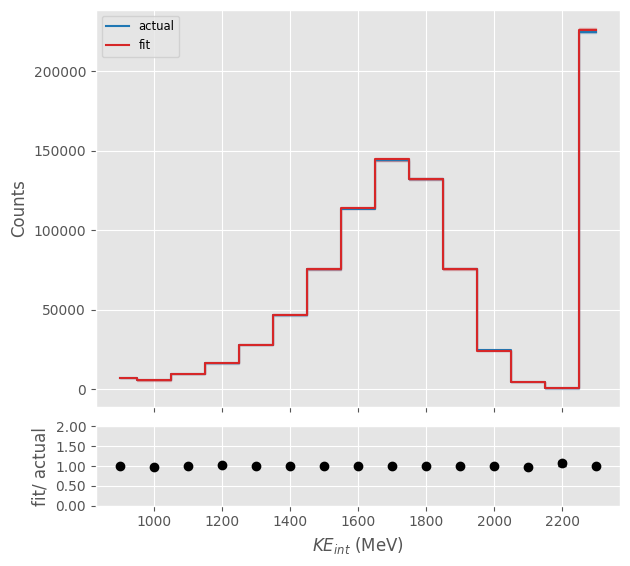

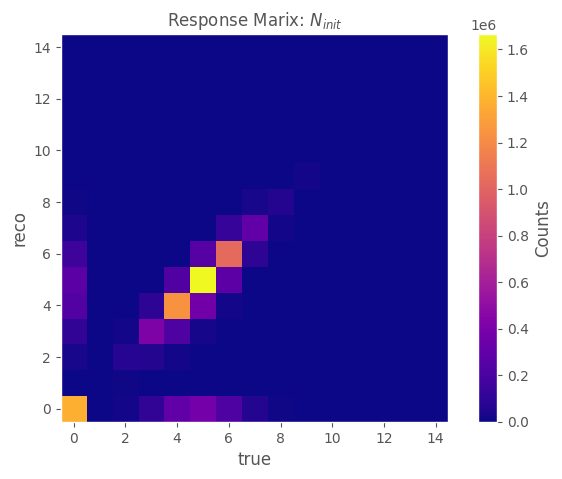

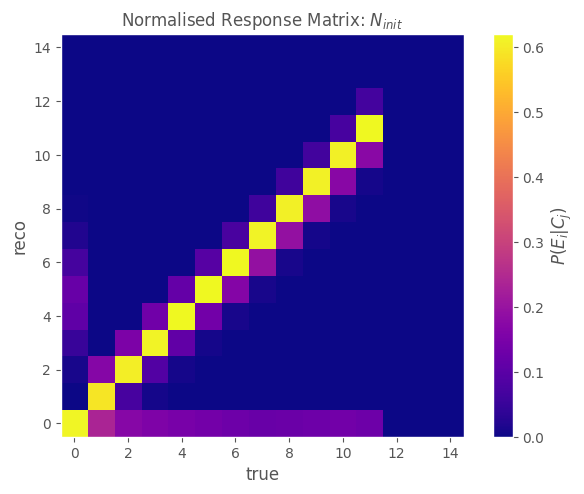

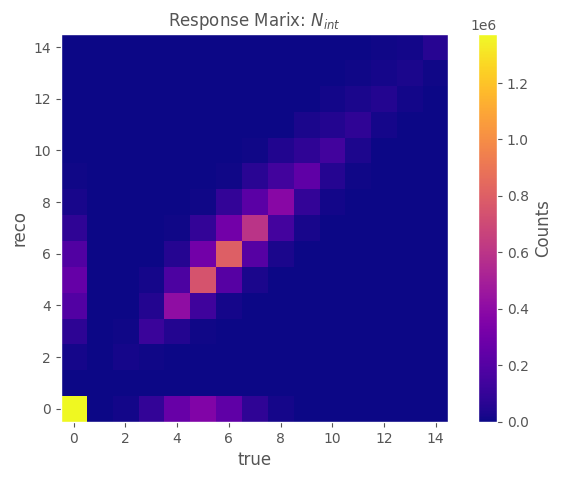

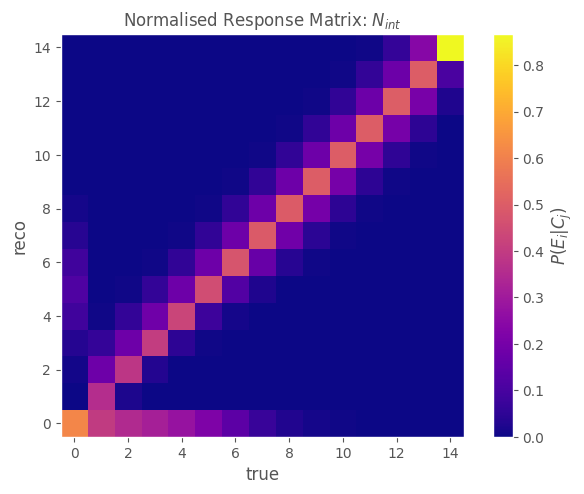

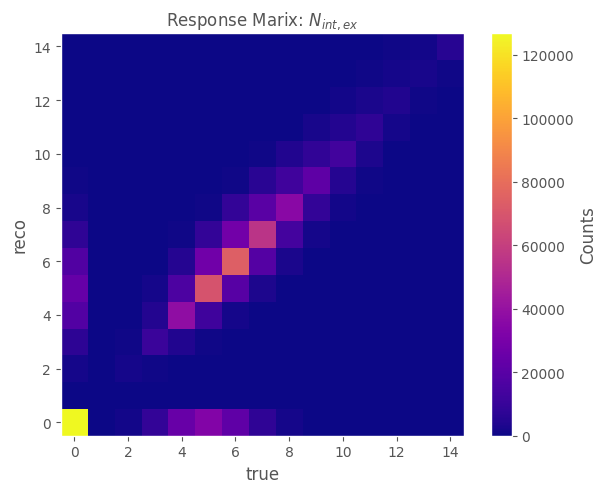

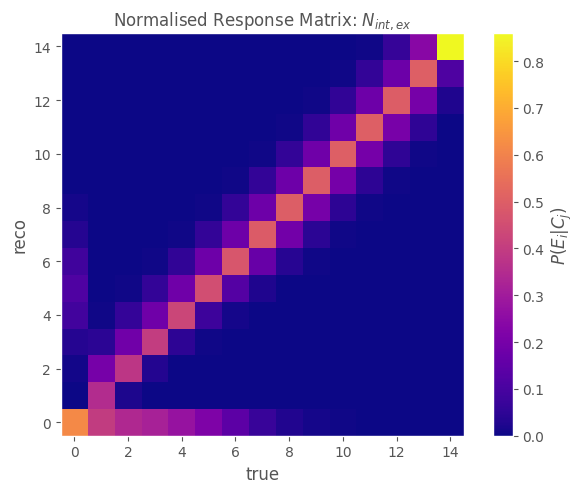

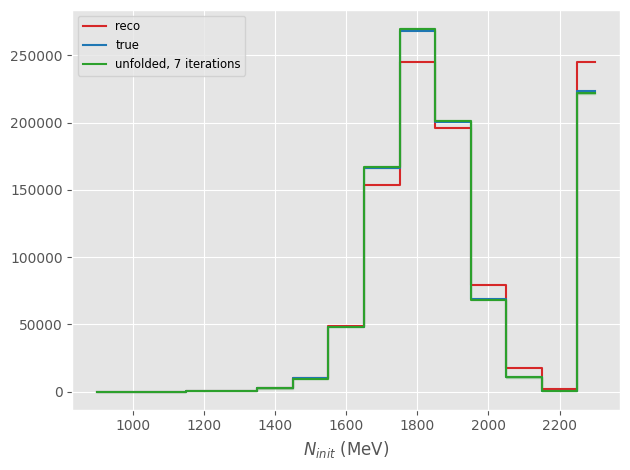

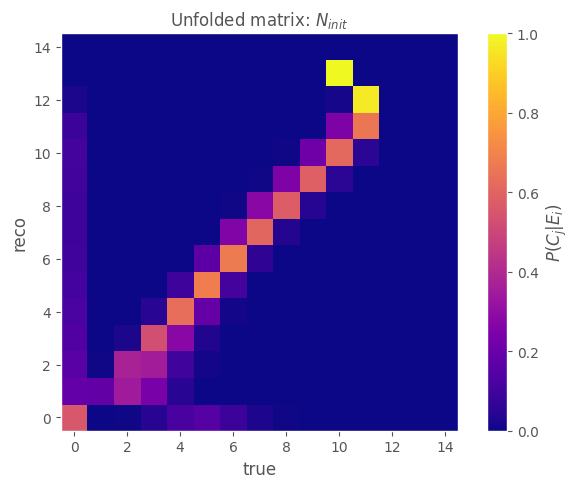

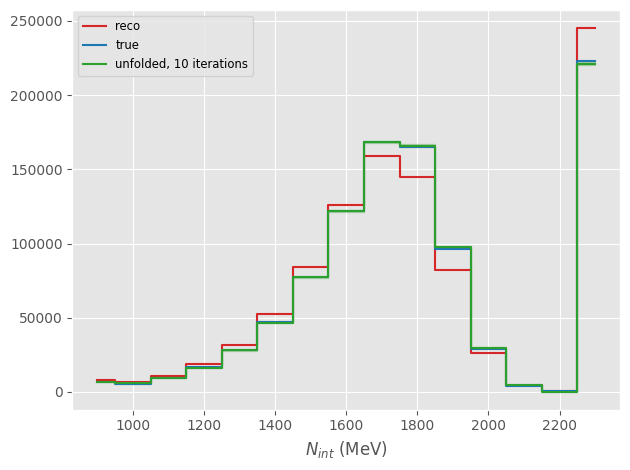

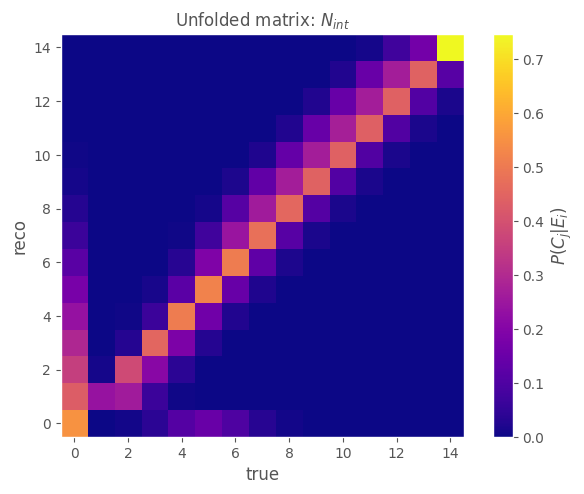

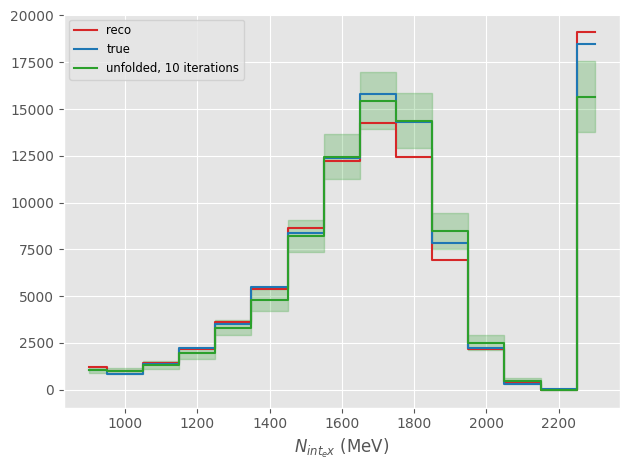

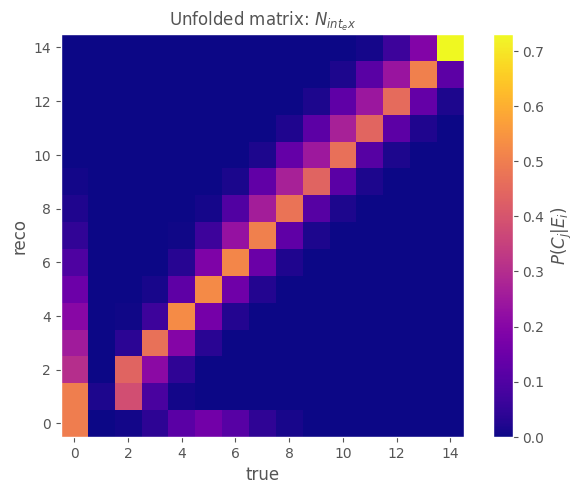

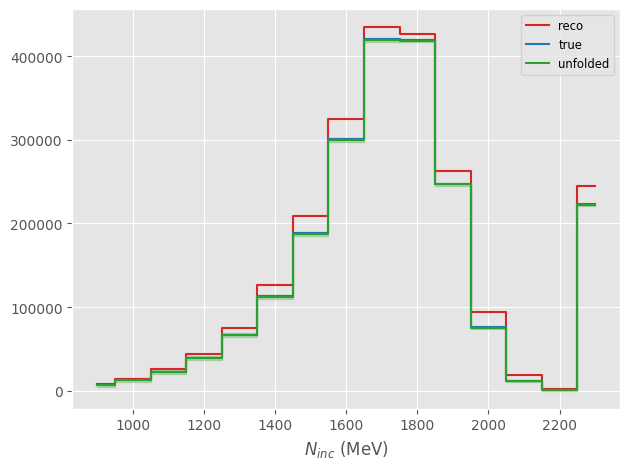

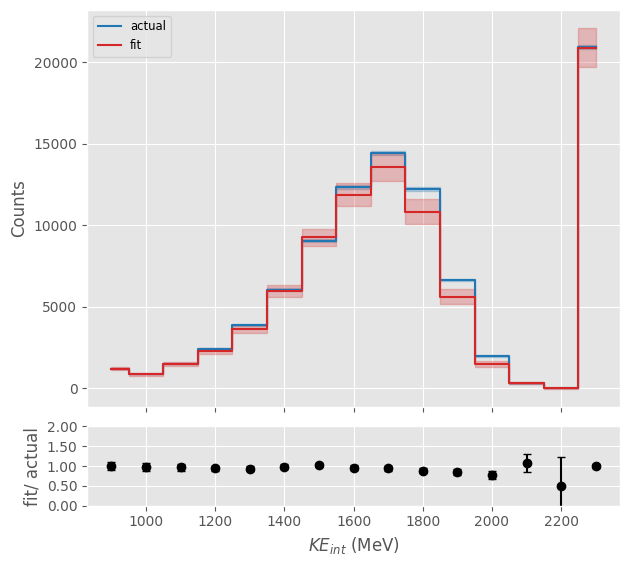

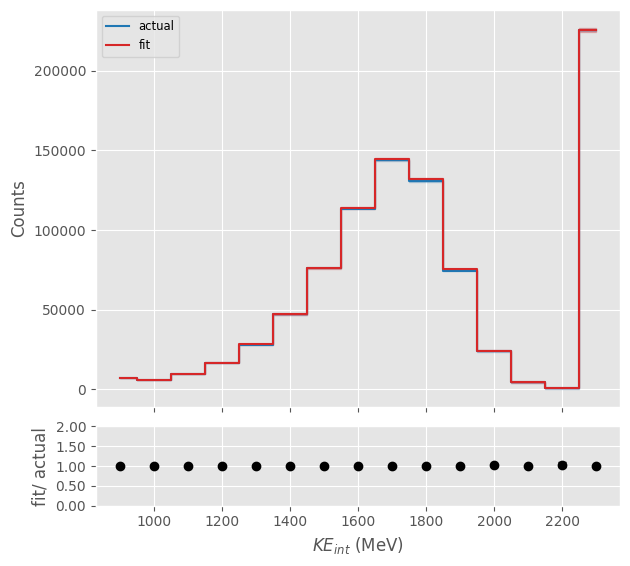

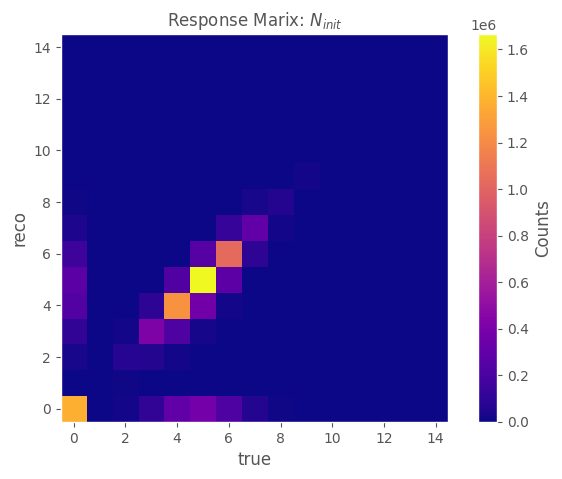

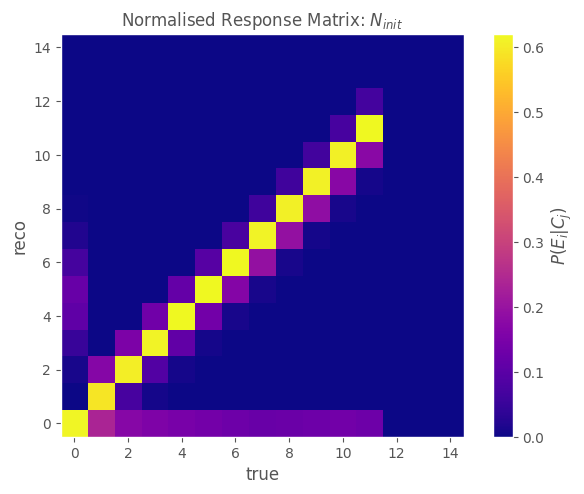

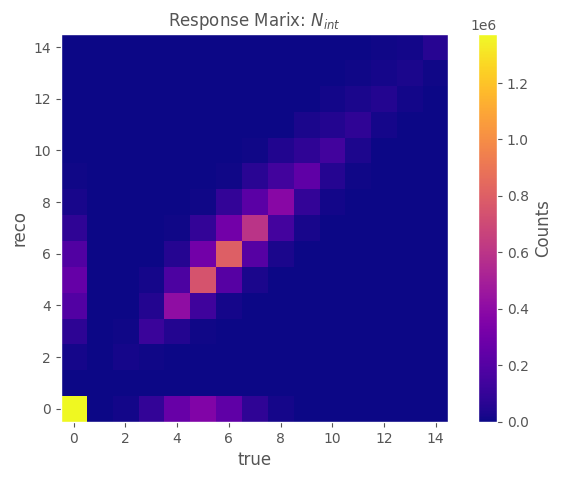

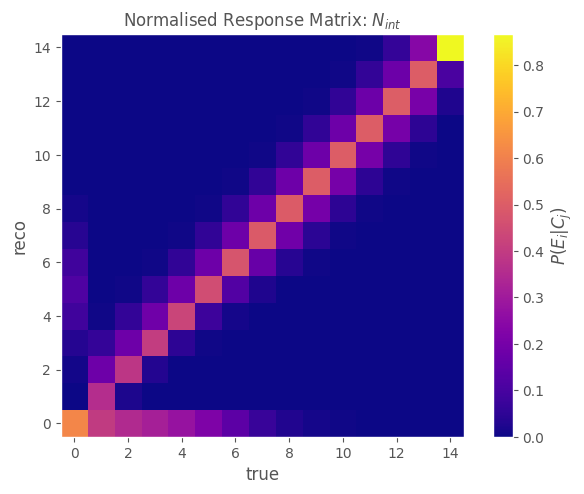

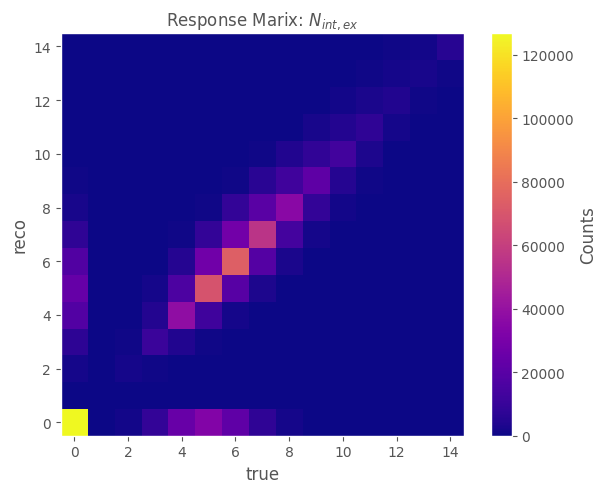

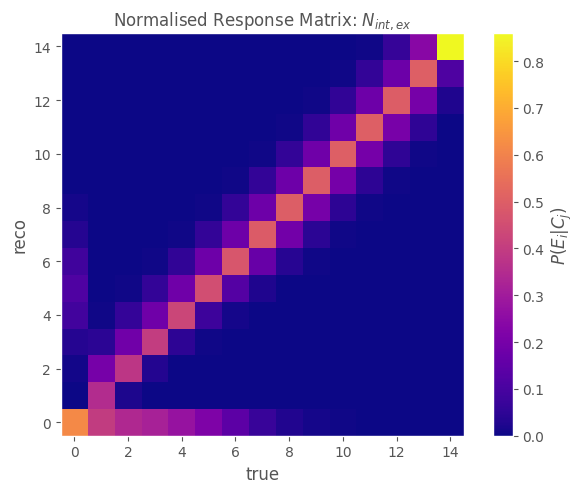

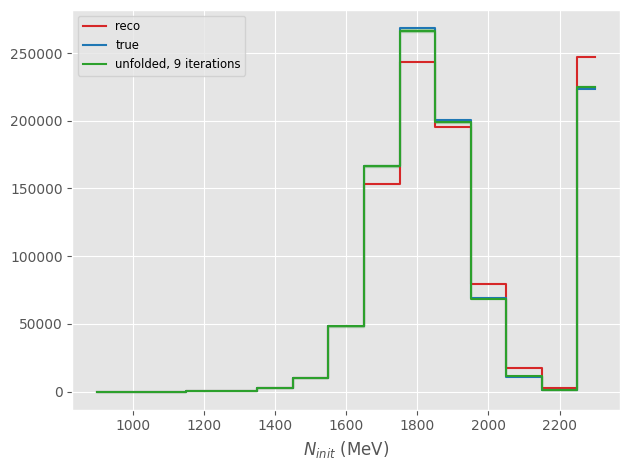

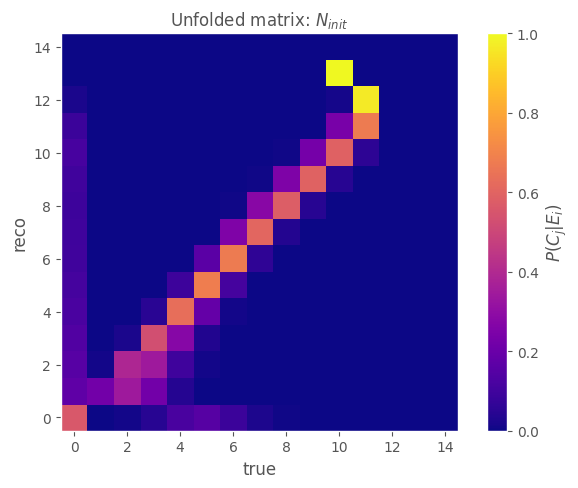

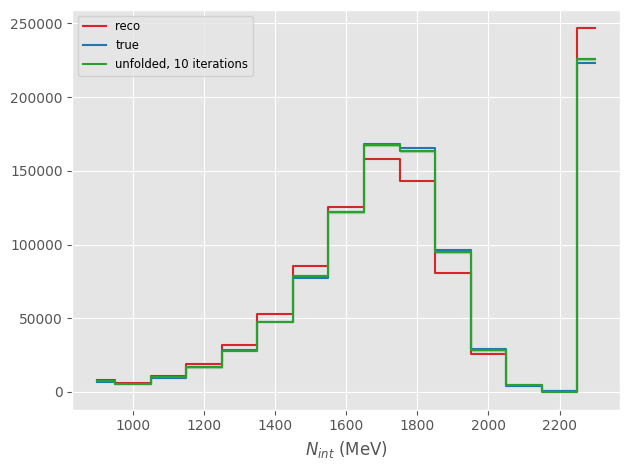

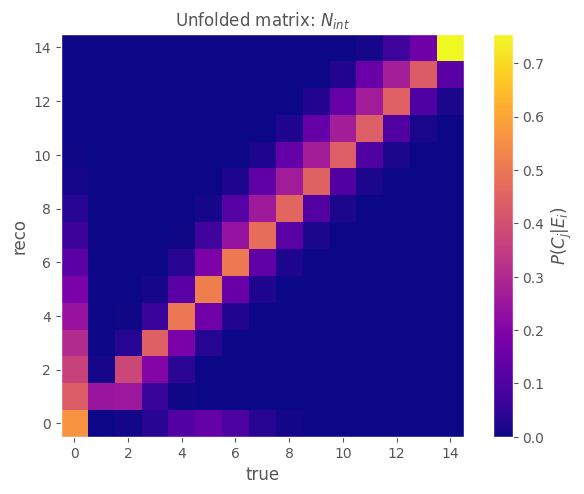

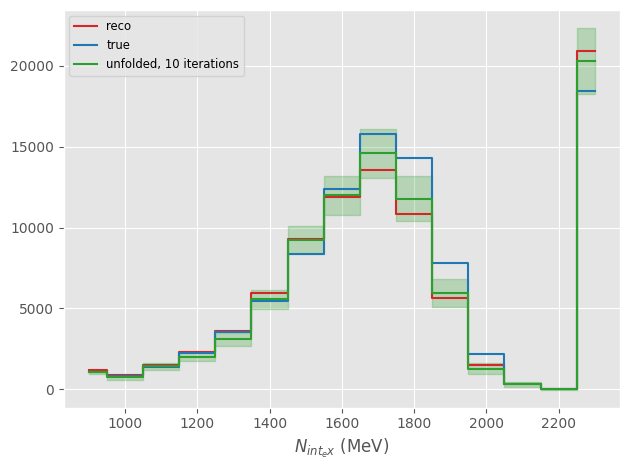

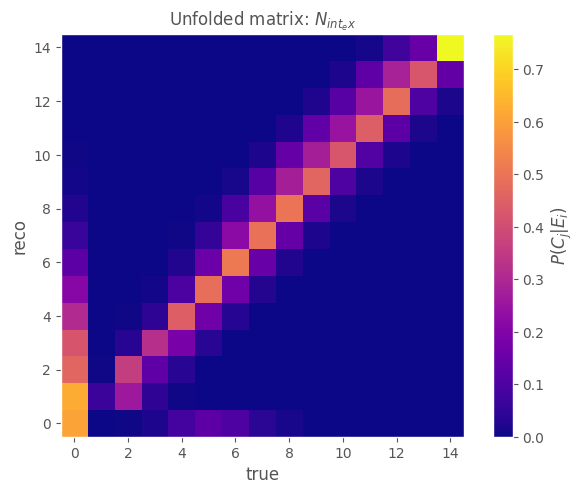

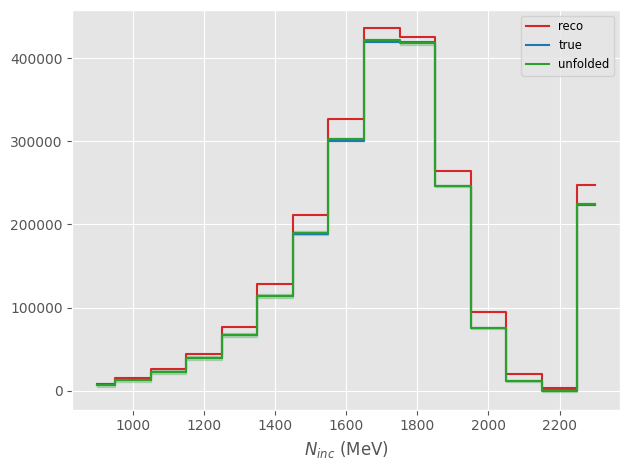

In [43]:
smearing_high = cross_section.pd.DataFrame({f"{k}_smearing" : cross_section.Fitting.RejectionSampling(len(toy_nominal.df), min(v["range"]), max(v["range"]), getattr(cross_section.Fitting, v["function"]), p_high[k], rng = np.random.default_rng(1)) for k, v in smearing_params.items()})
smearing_low = cross_section.pd.DataFrame({f"{k}_smearing" : cross_section.Fitting.RejectionSampling(len(toy_nominal.df), min(v["range"]), max(v["range"]), getattr(cross_section.Fitting, v["function"]), p_low[k], rng = np.random.default_rng(1)) for k, v in smearing_params.items()})
analysis_input_high = CreateNewAnalysisInput(toy_nominal, smearing_high)
analysis_input_low = CreateNewAnalysisInput(toy_nominal, smearing_low)

xs_high = Analyse(analysis_input_high, model, args, args.energy_slices, None)
xs_low = Analyse(analysis_input_low, model, args, args.energy_slices, None)

In [44]:
book = Plots.PlotBook("detector_sys_5E6.pdf", False)

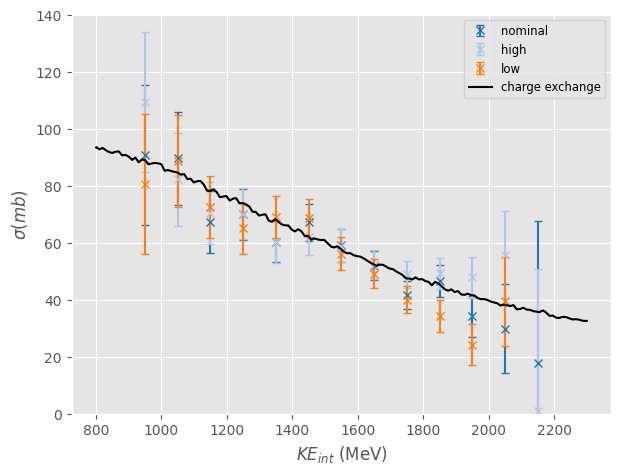

In [45]:
geant_xs = cross_section.GeantCrossSections(energy_range = [args.energy_slices.min_pos - args.energy_slices.width, args.energy_slices.max_pos + args.energy_slices.width])

Plots.Plot(args.energy_slices.pos - args.energy_slices.width/2, xs_nominal[0], yerr = xs_nominal[1], linestyle = "", marker = "x", label = "nominal")
Plots.Plot(args.energy_slices.pos - args.energy_slices.width/2, xs_high[0], yerr = xs_nominal[1], linestyle = "", marker = "x", label = "high", newFigure = False)
Plots.Plot(args.energy_slices.pos - args.energy_slices.width/2, xs_low[0], yerr = xs_nominal[1], linestyle = "", marker = "x", label = "low", newFigure = False)
geant_xs.Plot("charge_exchange", color = "k")

Plots.plt.ylim(0, 1.5 * max(getattr(geant_xs, "charge_exchange")))

book.Save()

(
    array([ 0.        ,  0.        , 10.02803284, 12.38589057,  1.70268539,
        2.89292147,  2.84414743,  0.        ,  0.        ,  4.92595399,
        0.        ,  0.91869747, 10.1797197 ,  0.        ]),
    array([0.        , 9.57268829, 0.        , 0.        , 0.        ,
       0.        , 0.        , 1.54099236, 8.62814821, 0.        ,
       5.35825788, 0.        , 0.        , 0.        ])
)

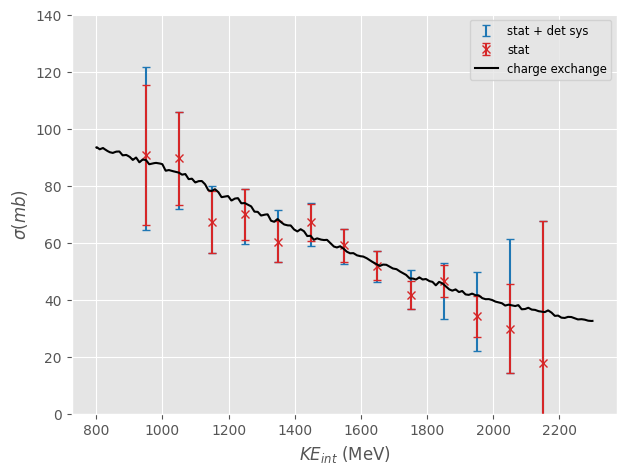

In [47]:
def quadsum(*arg):
    return np.sqrt(sum([a**2 for a in arg]))

err_high_var = SysErr(xs_nominal[0], xs_high[0])
err_low_var = SysErr(xs_nominal[0], xs_low[0])

sys_err_low = quadsum(err_low_var[0], err_high_var[0])
sys_err_high = quadsum(err_low_var[1], err_high_var[1])

print(err_low_var)

total_err_low = quadsum(xs_nominal[1], sys_err_low)
total_err_high = quadsum(xs_nominal[1], sys_err_high)

Plots.Plot(args.energy_slices.pos - args.energy_slices.width/2, xs_nominal[0], yerr = (total_err_low, total_err_high), linestyle = "", marker = "", label = "stat + det sys", newFigure = False)
# Plots.Plot(energy_slices.pos - energy_slices.width/2, xs_nominal[0], yerr = (sys_err_low, sys_err_high), linestyle = "", marker = "", label = "sys", newFigure = False)
Plots.Plot(args.energy_slices.pos - args.energy_slices.width/2, xs_nominal[0], yerr = xs_nominal[1], linestyle = "", marker = "x", label = "stat", color = "C6", newFigure = False)
geant_xs.Plot("charge_exchange", "k")
Plots.plt.ylim(0, 1.5 * max(getattr(geant_xs, "charge_exchange")))

book.Save()
book.close()